# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.






## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "VDNEW4"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz4.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz4.ipynb
/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
#from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [16]:
def tophat2D(r):
    
    d=2*int(r)+1
    Y, X = np.ogrid[:d, :d]
    c=int(r)
    k = (np.sqrt((X-c)**2 +  (Y-c)**2) <= r)*1 
    
    return k/k.sum()

    
    

In [17]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [18]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, tophat2D(rand_scale_factor))
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        
        k=tophat2D(int(self.kernel_size)/2.0)
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [20]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [21]:
tophat2D(2)

array([[0.        , 0.        , 0.07692308, 0.        , 0.        ],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.        , 0.        , 0.07692308, 0.        , 0.        ]])

In [22]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


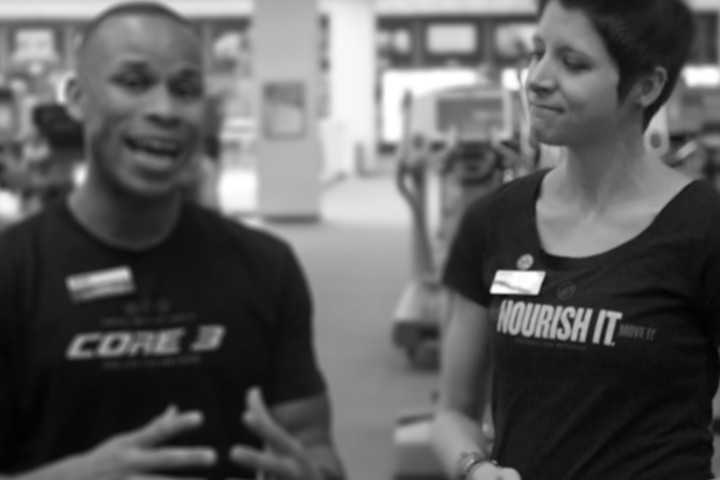

In [23]:
#test the CropRescale transform
im=load_frame(instances[10])
im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,10), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [24]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [25]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =20
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,10)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [26]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [27]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [28]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [29]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([4, 1, 480, 720])


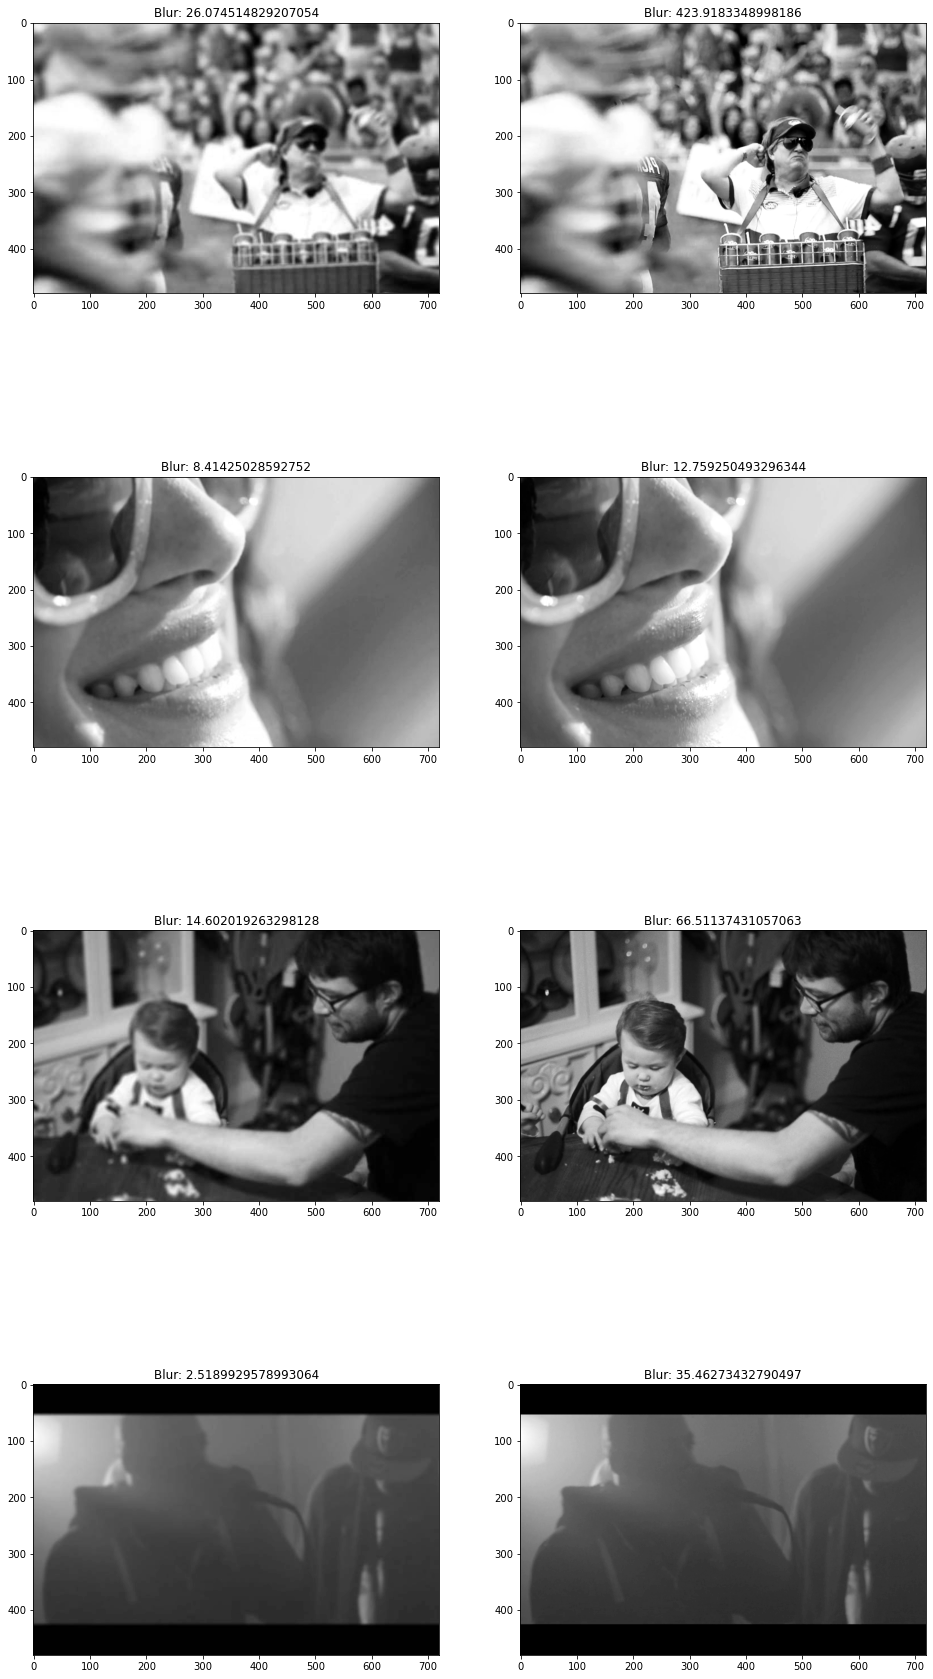

In [30]:
show_batch(training_data_loader,size =8)

# VDSR with 3 Channel Color

In [31]:
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from functools import partial

class Conv_ReLU_Block(nn.Module):
    def __init__(self,channels=64):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))

class VDSRNet(nn.Module):
    def __init__(self, image_channels=3, blocks=18, feature_channels=64):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(partial(Conv_ReLU_Block,channels=feature_channels), blocks)
        self.input = nn.Conv2d(in_channels=image_channels, out_channels=feature_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=feature_channels, out_channels=image_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    def forward8(self, x):
        #residual = x
        out = self.relu(self.input(x.float()))
        out = self.residual_layer(out)
        out = self.output(out).int8()
        out = torch.add(out,x).clamp(0,255)
        return out

# Build the model

In [32]:
model = VDSRNet(image_channels=1, blocks=18, feature_channels=64)
model.cuda()


VDSRNet(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (6): Conv_ReL

In [33]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]

#modelbw = torch.load("/media/SSD/superres/checkpoint/percepmodel3_epoch_25.pth")["model"]

/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [34]:
num_pixels = crop_size[0] * crop_size[1]

In [35]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [36]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    def forward(self,x,y):
        
        return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        
        totloss.add_(self.lossfn.forward(x,y))
        
        
        return totloss


In [37]:
criterion = Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [38]:
init_lr = .001
lr_step = 4
gradient_clip = 0.4
epochs = 4*20

In [39]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [40]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [41]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [42]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [43]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [44]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [45]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        if epoch>1:
            swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%20 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
   
    print("Epoch Loss:", cum_loss2/ct2)        

In [46]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-15 07:37:40.882135
Epoch = 1, lr = 0.001
===> Time: 2020-10-15 07:38:04.721944 Epoch[1](20/3169): LR: 0.001 : Loss: 0.0436706543
===> Time: 2020-10-15 07:38:27.739996 Epoch[1](40/3169): LR: 0.001 : Loss: 0.0379638672
===> Time: 2020-10-15 07:38:51.360521 Epoch[1](60/3169): LR: 0.001 : Loss: 0.0357971191
===> Time: 2020-10-15 07:39:14.734668 Epoch[1](80/3169): LR: 0.001 : Loss: 0.0373840332
===> Time: 2020-10-15 07:39:38.177158 Epoch[1](100/3169): LR: 0.001 : Loss: 0.0406494141
===> Time: 2020-10-15 07:40:01.528838 Epoch[1](120/3169): LR: 0.001 : Loss: 0.0374450684
===> Time: 2020-10-15 07:40:24.752091 Epoch[1](140/3169): LR: 0.001 : Loss: 0.0315246582
===> Time: 2020-10-15 07:40:48.142364 Epoch[1](160/3169): LR: 0.001 : Loss: 0.0311889648
===> Time: 2020-10-15 07:41:11.471864 Epoch[1](180/3169): LR: 0.001 : Loss: 0.0325012207
===> Time: 2020-10-15 07:41:34.906812 Epoch[1](200/3169): LR: 0.001 : Loss: 0.0343933105
===> Time: 2020-10-15 07:41:58.265529 Epoch[1](220/31

===> Time: 2020-10-15 08:12:59.444747 Epoch[1](1840/3169): LR: 0.001 : Loss: 0.0300903320
===> Time: 2020-10-15 08:13:22.393392 Epoch[1](1860/3169): LR: 0.001 : Loss: 0.0334777832
===> Time: 2020-10-15 08:13:45.185613 Epoch[1](1880/3169): LR: 0.001 : Loss: 0.0301513672
===> Time: 2020-10-15 08:14:08.108227 Epoch[1](1900/3169): LR: 0.001 : Loss: 0.0306091309
===> Time: 2020-10-15 08:14:30.998620 Epoch[1](1920/3169): LR: 0.001 : Loss: 0.0301666260
===> Time: 2020-10-15 08:14:54.085573 Epoch[1](1940/3169): LR: 0.001 : Loss: 0.0344848633
===> Time: 2020-10-15 08:15:16.842209 Epoch[1](1960/3169): LR: 0.001 : Loss: 0.0325622559
===> Time: 2020-10-15 08:15:39.606599 Epoch[1](1980/3169): LR: 0.001 : Loss: 0.0306854248
===> Time: 2020-10-15 08:16:02.255322 Epoch[1](2000/3169): LR: 0.001 : Loss: 0.0318603516
===> Time: 2020-10-15 08:16:24.944804 Epoch[1](2020/3169): LR: 0.001 : Loss: 0.0313415527
===> Time: 2020-10-15 08:16:47.757412 Epoch[1](2040/3169): LR: 0.001 : Loss: 0.0348205566
===> Time:

===> Time: 2020-10-15 08:47:10.367580 Epoch[2](480/3169): LR: 0.001 : Loss: 0.0299987793
===> Time: 2020-10-15 08:47:32.968068 Epoch[2](500/3169): LR: 0.001 : Loss: 0.0296783447
===> Time: 2020-10-15 08:47:55.692940 Epoch[2](520/3169): LR: 0.001 : Loss: 0.0269927979
===> Time: 2020-10-15 08:48:18.311982 Epoch[2](540/3169): LR: 0.001 : Loss: 0.0303955078
===> Time: 2020-10-15 08:48:40.948995 Epoch[2](560/3169): LR: 0.001 : Loss: 0.0279693604
===> Time: 2020-10-15 08:49:03.435022 Epoch[2](580/3169): LR: 0.001 : Loss: 0.0303344727
===> Time: 2020-10-15 08:49:25.857388 Epoch[2](600/3169): LR: 0.001 : Loss: 0.0296325684
===> Time: 2020-10-15 08:49:48.191029 Epoch[2](620/3169): LR: 0.001 : Loss: 0.0335998535
===> Time: 2020-10-15 08:50:10.741769 Epoch[2](640/3169): LR: 0.001 : Loss: 0.0329895020
===> Time: 2020-10-15 08:50:33.468363 Epoch[2](660/3169): LR: 0.001 : Loss: 0.0306549072
===> Time: 2020-10-15 08:50:55.821668 Epoch[2](680/3169): LR: 0.001 : Loss: 0.0275268555
===> Time: 2020-10-15

===> Time: 2020-10-15 09:21:54.352831 Epoch[2](2320/3169): LR: 0.001 : Loss: 0.0297241211
===> Time: 2020-10-15 09:22:17.089253 Epoch[2](2340/3169): LR: 0.001 : Loss: 0.0320739746
===> Time: 2020-10-15 09:22:39.639270 Epoch[2](2360/3169): LR: 0.001 : Loss: 0.0315246582
===> Time: 2020-10-15 09:23:02.418321 Epoch[2](2380/3169): LR: 0.001 : Loss: 0.0281982422
===> Time: 2020-10-15 09:23:24.726107 Epoch[2](2400/3169): LR: 0.001 : Loss: 0.0324096680
===> Time: 2020-10-15 09:23:47.487132 Epoch[2](2420/3169): LR: 0.001 : Loss: 0.0264587402
===> Time: 2020-10-15 09:24:10.002732 Epoch[2](2440/3169): LR: 0.001 : Loss: 0.0298309326
===> Time: 2020-10-15 09:24:32.848605 Epoch[2](2460/3169): LR: 0.001 : Loss: 0.0299987793
===> Time: 2020-10-15 09:24:55.827613 Epoch[2](2480/3169): LR: 0.001 : Loss: 0.0347595215
===> Time: 2020-10-15 09:25:18.745203 Epoch[2](2500/3169): LR: 0.001 : Loss: 0.0268707275
===> Time: 2020-10-15 09:25:41.766051 Epoch[2](2520/3169): LR: 0.001 : Loss: 0.0304107666
===> Time:

===> Time: 2020-10-15 09:55:58.332019 Epoch[3](960/3169): LR: 0.001 : Loss: 0.0270233154
===> Time: 2020-10-15 09:56:21.120710 Epoch[3](980/3169): LR: 0.001 : Loss: 0.0280914307
===> Time: 2020-10-15 09:56:43.855983 Epoch[3](1000/3169): LR: 0.001 : Loss: 0.0295104980
===> Time: 2020-10-15 09:57:06.365497 Epoch[3](1020/3169): LR: 0.001 : Loss: 0.0321350098
===> Time: 2020-10-15 09:57:29.029499 Epoch[3](1040/3169): LR: 0.001 : Loss: 0.0291442871
===> Time: 2020-10-15 09:57:51.318145 Epoch[3](1060/3169): LR: 0.001 : Loss: 0.0262603760
===> Time: 2020-10-15 09:58:13.911556 Epoch[3](1080/3169): LR: 0.001 : Loss: 0.0301971436
===> Time: 2020-10-15 09:58:36.659311 Epoch[3](1100/3169): LR: 0.001 : Loss: 0.0336914062
===> Time: 2020-10-15 09:58:59.268960 Epoch[3](1120/3169): LR: 0.001 : Loss: 0.0265808105
===> Time: 2020-10-15 09:59:21.931984 Epoch[3](1140/3169): LR: 0.001 : Loss: 0.0258026123
===> Time: 2020-10-15 09:59:44.400761 Epoch[3](1160/3169): LR: 0.001 : Loss: 0.0360717773
===> Time: 2

===> Time: 2020-10-15 10:30:35.784079 Epoch[3](2800/3169): LR: 0.001 : Loss: 0.0284881592
===> Time: 2020-10-15 10:30:58.285325 Epoch[3](2820/3169): LR: 0.001 : Loss: 0.0284423828
===> Time: 2020-10-15 10:31:20.675118 Epoch[3](2840/3169): LR: 0.001 : Loss: 0.0264587402
===> Time: 2020-10-15 10:31:43.219334 Epoch[3](2860/3169): LR: 0.001 : Loss: 0.0322265625
===> Time: 2020-10-15 10:32:05.606923 Epoch[3](2880/3169): LR: 0.001 : Loss: 0.0267944336
===> Time: 2020-10-15 10:32:28.135115 Epoch[3](2900/3169): LR: 0.001 : Loss: 0.0284881592
===> Time: 2020-10-15 10:32:50.471017 Epoch[3](2920/3169): LR: 0.001 : Loss: 0.0294342041
===> Time: 2020-10-15 10:33:13.032197 Epoch[3](2940/3169): LR: 0.001 : Loss: 0.0354614258
===> Time: 2020-10-15 10:33:35.719499 Epoch[3](2960/3169): LR: 0.001 : Loss: 0.0250854492
===> Time: 2020-10-15 10:33:58.339211 Epoch[3](2980/3169): LR: 0.001 : Loss: 0.0266723633
===> Time: 2020-10-15 10:34:20.916468 Epoch[3](3000/3169): LR: 0.001 : Loss: 0.0278778076
===> Time:

===> Time: 2020-10-15 11:04:35.236860 Epoch[4](1440/3169): LR: 0.001 : Loss: 0.0313110352
===> Time: 2020-10-15 11:04:58.081206 Epoch[4](1460/3169): LR: 0.001 : Loss: 0.0271606445
===> Time: 2020-10-15 11:05:20.679456 Epoch[4](1480/3169): LR: 0.001 : Loss: 0.0305328369
===> Time: 2020-10-15 11:05:43.436206 Epoch[4](1500/3169): LR: 0.001 : Loss: 0.0335388184
===> Time: 2020-10-15 11:06:05.918411 Epoch[4](1520/3169): LR: 0.001 : Loss: 0.0281372070
===> Time: 2020-10-15 11:06:28.483243 Epoch[4](1540/3169): LR: 0.001 : Loss: 0.0311431885
===> Time: 2020-10-15 11:06:50.967708 Epoch[4](1560/3169): LR: 0.001 : Loss: 0.0279235840
===> Time: 2020-10-15 11:07:13.734973 Epoch[4](1580/3169): LR: 0.001 : Loss: 0.0276489258
===> Time: 2020-10-15 11:07:36.153208 Epoch[4](1600/3169): LR: 0.001 : Loss: 0.0272216797
===> Time: 2020-10-15 11:07:58.760015 Epoch[4](1620/3169): LR: 0.001 : Loss: 0.0265808105
===> Time: 2020-10-15 11:08:21.480435 Epoch[4](1640/3169): LR: 0.001 : Loss: 0.0254058838
===> Time:

===> Time: 2020-10-15 11:38:17.392873 Epoch[5](60/3169): LR: 0.00031622776601683794 : Loss: 0.0284881592
===> Time: 2020-10-15 11:38:40.125007 Epoch[5](80/3169): LR: 0.00031622776601683794 : Loss: 0.0330505371
===> Time: 2020-10-15 11:39:02.956622 Epoch[5](100/3169): LR: 0.00031622776601683794 : Loss: 0.0256347656
===> Time: 2020-10-15 11:39:25.594915 Epoch[5](120/3169): LR: 0.00031622776601683794 : Loss: 0.0308227539
===> Time: 2020-10-15 11:39:48.443100 Epoch[5](140/3169): LR: 0.00031622776601683794 : Loss: 0.0258178711
===> Time: 2020-10-15 11:40:11.164981 Epoch[5](160/3169): LR: 0.00031622776601683794 : Loss: 0.0271911621
===> Time: 2020-10-15 11:40:33.940259 Epoch[5](180/3169): LR: 0.00031622776601683794 : Loss: 0.0265502930
===> Time: 2020-10-15 11:40:56.344121 Epoch[5](200/3169): LR: 0.00031622776601683794 : Loss: 0.0261688232
===> Time: 2020-10-15 11:41:19.245737 Epoch[5](220/3169): LR: 0.00031622776601683794 : Loss: 0.0279693604
===> Time: 2020-10-15 11:41:42.215270 Epoch[5](2

===> Time: 2020-10-15 12:07:44.771189 Epoch[5](1620/3169): LR: 0.00031622776601683794 : Loss: 0.0263366699
===> Time: 2020-10-15 12:08:07.226210 Epoch[5](1640/3169): LR: 0.00031622776601683794 : Loss: 0.0234680176
===> Time: 2020-10-15 12:08:30.012391 Epoch[5](1660/3169): LR: 0.00031622776601683794 : Loss: 0.0286560059
===> Time: 2020-10-15 12:08:52.844727 Epoch[5](1680/3169): LR: 0.00031622776601683794 : Loss: 0.0319519043
===> Time: 2020-10-15 12:09:15.347094 Epoch[5](1700/3169): LR: 0.00031622776601683794 : Loss: 0.0242919922
===> Time: 2020-10-15 12:09:38.104471 Epoch[5](1720/3169): LR: 0.00031622776601683794 : Loss: 0.0338745117
===> Time: 2020-10-15 12:10:00.646188 Epoch[5](1740/3169): LR: 0.00031622776601683794 : Loss: 0.0305786133
===> Time: 2020-10-15 12:10:23.334549 Epoch[5](1760/3169): LR: 0.00031622776601683794 : Loss: 0.0300445557
===> Time: 2020-10-15 12:10:46.043755 Epoch[5](1780/3169): LR: 0.00031622776601683794 : Loss: 0.0271453857
===> Time: 2020-10-15 12:11:08.980861

===> Time: 2020-10-15 12:36:46.767887 Epoch[5](3160/3169): LR: 0.00031622776601683794 : Loss: 0.0258483887
Epoch Loss: tensor(0.0256, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_5.pth
Start Time: 2020-10-15 12:36:56.079606
Epoch = 6, lr = 0.00031622776601683794
===> Time: 2020-10-15 12:37:18.491100 Epoch[6](20/3169): LR: 0.00031622776601683794 : Loss: 0.0262908936
===> Time: 2020-10-15 12:37:41.217214 Epoch[6](40/3169): LR: 0.00031622776601683794 : Loss: 0.0316467285
===> Time: 2020-10-15 12:38:03.971480 Epoch[6](60/3169): LR: 0.00031622776601683794 : Loss: 0.0265502930
===> Time: 2020-10-15 12:38:26.754576 Epoch[6](80/3169): LR: 0.00031622776601683794 : Loss: 0.0324401855
===> Time: 2020-10-15 12:38:49.201989 Epoch[6](100/3169): LR: 0.00031622776601683794 : Loss: 0.0258026123
===> Time: 2020-10-15 12:39:11.633210 Epoch[6](120/3169): LR: 0.00031622776601683794 : Loss: 0.0276031494
===> Time: 2020-10-15 12:39:34.251182 Epoch[6](1

===> Time: 2020-10-15 13:05:32.055599 Epoch[6](1520/3169): LR: 0.00031622776601683794 : Loss: 0.0319824219
===> Time: 2020-10-15 13:05:54.757815 Epoch[6](1540/3169): LR: 0.00031622776601683794 : Loss: 0.0287322998
===> Time: 2020-10-15 13:06:17.407447 Epoch[6](1560/3169): LR: 0.00031622776601683794 : Loss: 0.0314025879
===> Time: 2020-10-15 13:06:40.028102 Epoch[6](1580/3169): LR: 0.00031622776601683794 : Loss: 0.0283813477
===> Time: 2020-10-15 13:07:02.632110 Epoch[6](1600/3169): LR: 0.00031622776601683794 : Loss: 0.0260620117
===> Time: 2020-10-15 13:07:25.370283 Epoch[6](1620/3169): LR: 0.00031622776601683794 : Loss: 0.0291900635
===> Time: 2020-10-15 13:07:48.067463 Epoch[6](1640/3169): LR: 0.00031622776601683794 : Loss: 0.0245361328
===> Time: 2020-10-15 13:08:10.853981 Epoch[6](1660/3169): LR: 0.00031622776601683794 : Loss: 0.0290985107
===> Time: 2020-10-15 13:08:33.259943 Epoch[6](1680/3169): LR: 0.00031622776601683794 : Loss: 0.0268707275
===> Time: 2020-10-15 13:08:55.807481

===> Time: 2020-10-15 13:34:35.269333 Epoch[6](3060/3169): LR: 0.00031622776601683794 : Loss: 0.0292205811
===> Time: 2020-10-15 13:34:58.127389 Epoch[6](3080/3169): LR: 0.00031622776601683794 : Loss: 0.0266265869
===> Time: 2020-10-15 13:35:20.632010 Epoch[6](3100/3169): LR: 0.00031622776601683794 : Loss: 0.0258178711
===> Time: 2020-10-15 13:35:43.330768 Epoch[6](3120/3169): LR: 0.00031622776601683794 : Loss: 0.0280914307
===> Time: 2020-10-15 13:36:06.385849 Epoch[6](3140/3169): LR: 0.00031622776601683794 : Loss: 0.0266571045
===> Time: 2020-10-15 13:36:29.101283 Epoch[6](3160/3169): LR: 0.00031622776601683794 : Loss: 0.0261383057
Epoch Loss: tensor(0.0261, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_6.pth
Start Time: 2020-10-15 13:36:38.544841
Epoch = 7, lr = 0.00031622776601683794
===> Time: 2020-10-15 13:37:01.290930 Epoch[7](20/3169): LR: 0.00031622776601683794 : Loss: 0.0284881592
===> Time: 2020-10-15 13:37:23.707781 Ep

===> Time: 2020-10-15 14:03:24.175780 Epoch[7](1420/3169): LR: 0.00031622776601683794 : Loss: 0.0310516357
===> Time: 2020-10-15 14:03:46.918373 Epoch[7](1440/3169): LR: 0.00031622776601683794 : Loss: 0.0255737305
===> Time: 2020-10-15 14:04:09.726007 Epoch[7](1460/3169): LR: 0.00031622776601683794 : Loss: 0.0297546387
===> Time: 2020-10-15 14:04:32.183477 Epoch[7](1480/3169): LR: 0.00031622776601683794 : Loss: 0.0270385742
===> Time: 2020-10-15 14:04:54.756591 Epoch[7](1500/3169): LR: 0.00031622776601683794 : Loss: 0.0316772461
===> Time: 2020-10-15 14:05:17.378560 Epoch[7](1520/3169): LR: 0.00031622776601683794 : Loss: 0.0303192139
===> Time: 2020-10-15 14:05:40.096253 Epoch[7](1540/3169): LR: 0.00031622776601683794 : Loss: 0.0281982422
===> Time: 2020-10-15 14:06:02.477891 Epoch[7](1560/3169): LR: 0.00031622776601683794 : Loss: 0.0284118652
===> Time: 2020-10-15 14:06:25.199467 Epoch[7](1580/3169): LR: 0.00031622776601683794 : Loss: 0.0283660889
===> Time: 2020-10-15 14:06:48.235860

===> Time: 2020-10-15 14:32:20.901746 Epoch[7](2960/3169): LR: 0.00031622776601683794 : Loss: 0.0290527344
===> Time: 2020-10-15 14:32:43.352114 Epoch[7](2980/3169): LR: 0.00031622776601683794 : Loss: 0.0262908936
===> Time: 2020-10-15 14:33:06.195457 Epoch[7](3000/3169): LR: 0.00031622776601683794 : Loss: 0.0279235840
===> Time: 2020-10-15 14:33:28.874628 Epoch[7](3020/3169): LR: 0.00031622776601683794 : Loss: 0.0278930664
===> Time: 2020-10-15 14:33:51.592321 Epoch[7](3040/3169): LR: 0.00031622776601683794 : Loss: 0.0259399414
===> Time: 2020-10-15 14:34:14.182988 Epoch[7](3060/3169): LR: 0.00031622776601683794 : Loss: 0.0259246826
===> Time: 2020-10-15 14:34:36.551297 Epoch[7](3080/3169): LR: 0.00031622776601683794 : Loss: 0.0286254883
===> Time: 2020-10-15 14:34:58.883617 Epoch[7](3100/3169): LR: 0.00031622776601683794 : Loss: 0.0274047852
===> Time: 2020-10-15 14:35:21.528128 Epoch[7](3120/3169): LR: 0.00031622776601683794 : Loss: 0.0257568359
===> Time: 2020-10-15 14:35:43.713514

===> Time: 2020-10-15 15:01:03.794030 Epoch[8](1320/3169): LR: 0.00031622776601683794 : Loss: 0.0261383057
===> Time: 2020-10-15 15:01:26.463310 Epoch[8](1340/3169): LR: 0.00031622776601683794 : Loss: 0.0321350098
===> Time: 2020-10-15 15:01:48.875646 Epoch[8](1360/3169): LR: 0.00031622776601683794 : Loss: 0.0260467529
===> Time: 2020-10-15 15:02:11.216435 Epoch[8](1380/3169): LR: 0.00031622776601683794 : Loss: 0.0329895020
===> Time: 2020-10-15 15:02:33.933658 Epoch[8](1400/3169): LR: 0.00031622776601683794 : Loss: 0.0287780762
===> Time: 2020-10-15 15:02:56.573346 Epoch[8](1420/3169): LR: 0.00031622776601683794 : Loss: 0.0238189697
===> Time: 2020-10-15 15:03:18.948172 Epoch[8](1440/3169): LR: 0.00031622776601683794 : Loss: 0.0253906250
===> Time: 2020-10-15 15:03:41.391999 Epoch[8](1460/3169): LR: 0.00031622776601683794 : Loss: 0.0262603760
===> Time: 2020-10-15 15:04:03.830923 Epoch[8](1480/3169): LR: 0.00031622776601683794 : Loss: 0.0293121338
===> Time: 2020-10-15 15:04:26.275418

===> Time: 2020-10-15 15:30:01.133849 Epoch[8](2860/3169): LR: 0.00031622776601683794 : Loss: 0.0269165039
===> Time: 2020-10-15 15:30:23.492200 Epoch[8](2880/3169): LR: 0.00031622776601683794 : Loss: 0.0273895264
===> Time: 2020-10-15 15:30:46.177184 Epoch[8](2900/3169): LR: 0.00031622776601683794 : Loss: 0.0291900635
===> Time: 2020-10-15 15:31:08.502362 Epoch[8](2920/3169): LR: 0.00031622776601683794 : Loss: 0.0262451172
===> Time: 2020-10-15 15:31:31.355260 Epoch[8](2940/3169): LR: 0.00031622776601683794 : Loss: 0.0298309326
===> Time: 2020-10-15 15:31:54.009268 Epoch[8](2960/3169): LR: 0.00031622776601683794 : Loss: 0.0245971680
===> Time: 2020-10-15 15:32:16.385345 Epoch[8](2980/3169): LR: 0.00031622776601683794 : Loss: 0.0248413086
===> Time: 2020-10-15 15:32:38.980023 Epoch[8](3000/3169): LR: 0.00031622776601683794 : Loss: 0.0288543701
===> Time: 2020-10-15 15:33:01.729117 Epoch[8](3020/3169): LR: 0.00031622776601683794 : Loss: 0.0291748047
===> Time: 2020-10-15 15:33:24.490016

===> Time: 2020-10-15 16:02:37.348470 Epoch[9](1420/3169): LR: 0.0001 : Loss: 0.0297851562
===> Time: 2020-10-15 16:02:59.861837 Epoch[9](1440/3169): LR: 0.0001 : Loss: 0.0282897949
===> Time: 2020-10-15 16:03:22.336860 Epoch[9](1460/3169): LR: 0.0001 : Loss: 0.0228881836
===> Time: 2020-10-15 16:03:44.931662 Epoch[9](1480/3169): LR: 0.0001 : Loss: 0.0261688232
===> Time: 2020-10-15 16:04:07.469343 Epoch[9](1500/3169): LR: 0.0001 : Loss: 0.0274353027
===> Time: 2020-10-15 16:04:29.988447 Epoch[9](1520/3169): LR: 0.0001 : Loss: 0.0301208496
===> Time: 2020-10-15 16:04:52.663566 Epoch[9](1540/3169): LR: 0.0001 : Loss: 0.0272369385
===> Time: 2020-10-15 16:05:15.270365 Epoch[9](1560/3169): LR: 0.0001 : Loss: 0.0307006836
===> Time: 2020-10-15 16:05:38.395034 Epoch[9](1580/3169): LR: 0.0001 : Loss: 0.0290527344
===> Time: 2020-10-15 16:06:01.169565 Epoch[9](1600/3169): LR: 0.0001 : Loss: 0.0307312012
===> Time: 2020-10-15 16:06:23.701028 Epoch[9](1620/3169): LR: 0.0001 : Loss: 0.0358581543

===> Time: 2020-10-15 16:35:52.532017 Epoch[10](20/3169): LR: 0.0001 : Loss: 0.0266571045
===> Time: 2020-10-15 16:36:15.156653 Epoch[10](40/3169): LR: 0.0001 : Loss: 0.0282897949
===> Time: 2020-10-15 16:36:37.760721 Epoch[10](60/3169): LR: 0.0001 : Loss: 0.0260925293
===> Time: 2020-10-15 16:37:00.413119 Epoch[10](80/3169): LR: 0.0001 : Loss: 0.0253906250
===> Time: 2020-10-15 16:37:22.905045 Epoch[10](100/3169): LR: 0.0001 : Loss: 0.0253143311
===> Time: 2020-10-15 16:37:45.284014 Epoch[10](120/3169): LR: 0.0001 : Loss: 0.0236053467
===> Time: 2020-10-15 16:38:07.831703 Epoch[10](140/3169): LR: 0.0001 : Loss: 0.0257720947
===> Time: 2020-10-15 16:38:30.617670 Epoch[10](160/3169): LR: 0.0001 : Loss: 0.0290985107
===> Time: 2020-10-15 16:38:53.218751 Epoch[10](180/3169): LR: 0.0001 : Loss: 0.0270233154
===> Time: 2020-10-15 16:39:15.356366 Epoch[10](200/3169): LR: 0.0001 : Loss: 0.0249023438
===> Time: 2020-10-15 16:39:38.236933 Epoch[10](220/3169): LR: 0.0001 : Loss: 0.0248718262
===

===> Time: 2020-10-15 17:09:42.010184 Epoch[10](1820/3169): LR: 0.0001 : Loss: 0.0243072510
===> Time: 2020-10-15 17:10:04.945726 Epoch[10](1840/3169): LR: 0.0001 : Loss: 0.0287322998
===> Time: 2020-10-15 17:10:27.583163 Epoch[10](1860/3169): LR: 0.0001 : Loss: 0.0311889648
===> Time: 2020-10-15 17:10:50.203214 Epoch[10](1880/3169): LR: 0.0001 : Loss: 0.0281219482
===> Time: 2020-10-15 17:11:12.674180 Epoch[10](1900/3169): LR: 0.0001 : Loss: 0.0286865234
===> Time: 2020-10-15 17:11:34.876558 Epoch[10](1920/3169): LR: 0.0001 : Loss: 0.0284423828
===> Time: 2020-10-15 17:11:57.581537 Epoch[10](1940/3169): LR: 0.0001 : Loss: 0.0289916992
===> Time: 2020-10-15 17:12:20.120834 Epoch[10](1960/3169): LR: 0.0001 : Loss: 0.0285034180
===> Time: 2020-10-15 17:12:42.694872 Epoch[10](1980/3169): LR: 0.0001 : Loss: 0.0269165039
===> Time: 2020-10-15 17:13:05.313322 Epoch[10](2000/3169): LR: 0.0001 : Loss: 0.0272674561
===> Time: 2020-10-15 17:13:27.396474 Epoch[10](2020/3169): LR: 0.0001 : Loss: 0

===> Time: 2020-10-15 17:42:55.610248 Epoch[11](420/3169): LR: 0.0001 : Loss: 0.0298767090
===> Time: 2020-10-15 17:43:18.381587 Epoch[11](440/3169): LR: 0.0001 : Loss: 0.0279998779
===> Time: 2020-10-15 17:43:40.865049 Epoch[11](460/3169): LR: 0.0001 : Loss: 0.0267333984
===> Time: 2020-10-15 17:44:03.305684 Epoch[11](480/3169): LR: 0.0001 : Loss: 0.0303955078
===> Time: 2020-10-15 17:44:26.056801 Epoch[11](500/3169): LR: 0.0001 : Loss: 0.0279541016
===> Time: 2020-10-15 17:44:48.723561 Epoch[11](520/3169): LR: 0.0001 : Loss: 0.0284576416
===> Time: 2020-10-15 17:45:10.978120 Epoch[11](540/3169): LR: 0.0001 : Loss: 0.0233306885
===> Time: 2020-10-15 17:45:33.581537 Epoch[11](560/3169): LR: 0.0001 : Loss: 0.0259399414
===> Time: 2020-10-15 17:45:56.078160 Epoch[11](580/3169): LR: 0.0001 : Loss: 0.0256805420
===> Time: 2020-10-15 17:46:18.533232 Epoch[11](600/3169): LR: 0.0001 : Loss: 0.0285644531
===> Time: 2020-10-15 17:46:40.968834 Epoch[11](620/3169): LR: 0.0001 : Loss: 0.0263824463

===> Time: 2020-10-15 18:16:44.615644 Epoch[11](2220/3169): LR: 0.0001 : Loss: 0.0267333984
===> Time: 2020-10-15 18:17:07.027191 Epoch[11](2240/3169): LR: 0.0001 : Loss: 0.0235595703
===> Time: 2020-10-15 18:17:29.445133 Epoch[11](2260/3169): LR: 0.0001 : Loss: 0.0259246826
===> Time: 2020-10-15 18:17:52.109217 Epoch[11](2280/3169): LR: 0.0001 : Loss: 0.0253295898
===> Time: 2020-10-15 18:18:14.566502 Epoch[11](2300/3169): LR: 0.0001 : Loss: 0.0246734619
===> Time: 2020-10-15 18:18:37.296627 Epoch[11](2320/3169): LR: 0.0001 : Loss: 0.0310058594
===> Time: 2020-10-15 18:18:59.874779 Epoch[11](2340/3169): LR: 0.0001 : Loss: 0.0258789062
===> Time: 2020-10-15 18:19:22.306751 Epoch[11](2360/3169): LR: 0.0001 : Loss: 0.0262451172
===> Time: 2020-10-15 18:19:44.813235 Epoch[11](2380/3169): LR: 0.0001 : Loss: 0.0257263184
===> Time: 2020-10-15 18:20:07.280710 Epoch[11](2400/3169): LR: 0.0001 : Loss: 0.0260620117
===> Time: 2020-10-15 18:20:29.484172 Epoch[11](2420/3169): LR: 0.0001 : Loss: 0

===> Time: 2020-10-15 18:49:59.334748 Epoch[12](820/3169): LR: 0.0001 : Loss: 0.0271453857
===> Time: 2020-10-15 18:50:21.975981 Epoch[12](840/3169): LR: 0.0001 : Loss: 0.0267944336
===> Time: 2020-10-15 18:50:44.733277 Epoch[12](860/3169): LR: 0.0001 : Loss: 0.0264129639
===> Time: 2020-10-15 18:51:07.020747 Epoch[12](880/3169): LR: 0.0001 : Loss: 0.0228271484
===> Time: 2020-10-15 18:51:29.887009 Epoch[12](900/3169): LR: 0.0001 : Loss: 0.0293426514
===> Time: 2020-10-15 18:51:52.633297 Epoch[12](920/3169): LR: 0.0001 : Loss: 0.0297088623
===> Time: 2020-10-15 18:52:15.071623 Epoch[12](940/3169): LR: 0.0001 : Loss: 0.0292663574
===> Time: 2020-10-15 18:52:37.617514 Epoch[12](960/3169): LR: 0.0001 : Loss: 0.0267333984
===> Time: 2020-10-15 18:53:00.062228 Epoch[12](980/3169): LR: 0.0001 : Loss: 0.0292663574
===> Time: 2020-10-15 18:53:22.909419 Epoch[12](1000/3169): LR: 0.0001 : Loss: 0.0305328369
===> Time: 2020-10-15 18:53:45.734688 Epoch[12](1020/3169): LR: 0.0001 : Loss: 0.02857971

===> Time: 2020-10-15 19:23:53.264017 Epoch[12](2620/3169): LR: 0.0001 : Loss: 0.0273895264
===> Time: 2020-10-15 19:24:15.848502 Epoch[12](2640/3169): LR: 0.0001 : Loss: 0.0272827148
===> Time: 2020-10-15 19:24:38.508191 Epoch[12](2660/3169): LR: 0.0001 : Loss: 0.0310211182
===> Time: 2020-10-15 19:25:00.916532 Epoch[12](2680/3169): LR: 0.0001 : Loss: 0.0261840820
===> Time: 2020-10-15 19:25:23.525987 Epoch[12](2700/3169): LR: 0.0001 : Loss: 0.0283813477
===> Time: 2020-10-15 19:25:46.269503 Epoch[12](2720/3169): LR: 0.0001 : Loss: 0.0247802734
===> Time: 2020-10-15 19:26:09.091960 Epoch[12](2740/3169): LR: 0.0001 : Loss: 0.0286865234
===> Time: 2020-10-15 19:26:31.831018 Epoch[12](2760/3169): LR: 0.0001 : Loss: 0.0324707031
===> Time: 2020-10-15 19:26:54.239998 Epoch[12](2780/3169): LR: 0.0001 : Loss: 0.0265350342
===> Time: 2020-10-15 19:27:16.912696 Epoch[12](2800/3169): LR: 0.0001 : Loss: 0.0280914307
===> Time: 2020-10-15 19:27:39.434026 Epoch[12](2820/3169): LR: 0.0001 : Loss: 0

===> Time: 2020-10-15 19:54:11.932495 Epoch[13](1060/3169): LR: 3.16227766016838e-05 : Loss: 0.0286865234
===> Time: 2020-10-15 19:54:34.594708 Epoch[13](1080/3169): LR: 3.16227766016838e-05 : Loss: 0.0236663818
===> Time: 2020-10-15 19:54:57.256514 Epoch[13](1100/3169): LR: 3.16227766016838e-05 : Loss: 0.0253295898
===> Time: 2020-10-15 19:55:19.848626 Epoch[13](1120/3169): LR: 3.16227766016838e-05 : Loss: 0.0258483887
===> Time: 2020-10-15 19:55:42.807703 Epoch[13](1140/3169): LR: 3.16227766016838e-05 : Loss: 0.0274047852
===> Time: 2020-10-15 19:56:05.422225 Epoch[13](1160/3169): LR: 3.16227766016838e-05 : Loss: 0.0281982422
===> Time: 2020-10-15 19:56:27.892271 Epoch[13](1180/3169): LR: 3.16227766016838e-05 : Loss: 0.0247650146
===> Time: 2020-10-15 19:56:50.373323 Epoch[13](1200/3169): LR: 3.16227766016838e-05 : Loss: 0.0275115967
===> Time: 2020-10-15 19:57:13.207333 Epoch[13](1220/3169): LR: 3.16227766016838e-05 : Loss: 0.0271606445
===> Time: 2020-10-15 19:57:35.904111 Epoch[13

===> Time: 2020-10-15 20:23:35.017966 Epoch[13](2620/3169): LR: 3.16227766016838e-05 : Loss: 0.0234832764
===> Time: 2020-10-15 20:23:57.566408 Epoch[13](2640/3169): LR: 3.16227766016838e-05 : Loss: 0.0294799805
===> Time: 2020-10-15 20:24:19.753280 Epoch[13](2660/3169): LR: 3.16227766016838e-05 : Loss: 0.0261230469
===> Time: 2020-10-15 20:24:42.610637 Epoch[13](2680/3169): LR: 3.16227766016838e-05 : Loss: 0.0275268555
===> Time: 2020-10-15 20:25:04.823213 Epoch[13](2700/3169): LR: 3.16227766016838e-05 : Loss: 0.0246124268
===> Time: 2020-10-15 20:25:27.355692 Epoch[13](2720/3169): LR: 3.16227766016838e-05 : Loss: 0.0260162354
===> Time: 2020-10-15 20:25:49.921975 Epoch[13](2740/3169): LR: 3.16227766016838e-05 : Loss: 0.0249328613
===> Time: 2020-10-15 20:26:12.570089 Epoch[13](2760/3169): LR: 3.16227766016838e-05 : Loss: 0.0247344971
===> Time: 2020-10-15 20:26:35.081761 Epoch[13](2780/3169): LR: 3.16227766016838e-05 : Loss: 0.0249481201
===> Time: 2020-10-15 20:26:57.848851 Epoch[13

===> Time: 2020-10-15 20:52:18.245849 Epoch[14](980/3169): LR: 3.16227766016838e-05 : Loss: 0.0246582031
===> Time: 2020-10-15 20:52:41.035334 Epoch[14](1000/3169): LR: 3.16227766016838e-05 : Loss: 0.0286865234
===> Time: 2020-10-15 20:53:03.812503 Epoch[14](1020/3169): LR: 3.16227766016838e-05 : Loss: 0.0271148682
===> Time: 2020-10-15 20:53:26.463525 Epoch[14](1040/3169): LR: 3.16227766016838e-05 : Loss: 0.0283355713
===> Time: 2020-10-15 20:53:48.915553 Epoch[14](1060/3169): LR: 3.16227766016838e-05 : Loss: 0.0252685547
===> Time: 2020-10-15 20:54:11.308572 Epoch[14](1080/3169): LR: 3.16227766016838e-05 : Loss: 0.0258483887
===> Time: 2020-10-15 20:54:34.002496 Epoch[14](1100/3169): LR: 3.16227766016838e-05 : Loss: 0.0249633789
===> Time: 2020-10-15 20:54:56.991988 Epoch[14](1120/3169): LR: 3.16227766016838e-05 : Loss: 0.0256042480
===> Time: 2020-10-15 20:55:19.444909 Epoch[14](1140/3169): LR: 3.16227766016838e-05 : Loss: 0.0256347656
===> Time: 2020-10-15 20:55:41.853276 Epoch[14]

===> Time: 2020-10-15 21:21:40.613507 Epoch[14](2540/3169): LR: 3.16227766016838e-05 : Loss: 0.0230102539
===> Time: 2020-10-15 21:22:02.878249 Epoch[14](2560/3169): LR: 3.16227766016838e-05 : Loss: 0.0280761719
===> Time: 2020-10-15 21:22:25.586970 Epoch[14](2580/3169): LR: 3.16227766016838e-05 : Loss: 0.0289459229
===> Time: 2020-10-15 21:22:48.128297 Epoch[14](2600/3169): LR: 3.16227766016838e-05 : Loss: 0.0343322754
===> Time: 2020-10-15 21:23:10.170243 Epoch[14](2620/3169): LR: 3.16227766016838e-05 : Loss: 0.0249633789
===> Time: 2020-10-15 21:23:32.517106 Epoch[14](2640/3169): LR: 3.16227766016838e-05 : Loss: 0.0260620117
===> Time: 2020-10-15 21:23:54.940159 Epoch[14](2660/3169): LR: 3.16227766016838e-05 : Loss: 0.0287322998
===> Time: 2020-10-15 21:24:17.647607 Epoch[14](2680/3169): LR: 3.16227766016838e-05 : Loss: 0.0261840820
===> Time: 2020-10-15 21:24:40.339462 Epoch[14](2700/3169): LR: 3.16227766016838e-05 : Loss: 0.0247650146
===> Time: 2020-10-15 21:25:02.982868 Epoch[14

===> Time: 2020-10-15 21:50:24.676725 Epoch[15](900/3169): LR: 3.16227766016838e-05 : Loss: 0.0262451172
===> Time: 2020-10-15 21:50:47.067298 Epoch[15](920/3169): LR: 3.16227766016838e-05 : Loss: 0.0220642090
===> Time: 2020-10-15 21:51:09.519200 Epoch[15](940/3169): LR: 3.16227766016838e-05 : Loss: 0.0269165039
===> Time: 2020-10-15 21:51:32.520863 Epoch[15](960/3169): LR: 3.16227766016838e-05 : Loss: 0.0317993164
===> Time: 2020-10-15 21:51:55.352987 Epoch[15](980/3169): LR: 3.16227766016838e-05 : Loss: 0.0300445557
===> Time: 2020-10-15 21:52:17.970050 Epoch[15](1000/3169): LR: 3.16227766016838e-05 : Loss: 0.0298309326
===> Time: 2020-10-15 21:52:40.577084 Epoch[15](1020/3169): LR: 3.16227766016838e-05 : Loss: 0.0260009766
===> Time: 2020-10-15 21:53:03.005773 Epoch[15](1040/3169): LR: 3.16227766016838e-05 : Loss: 0.0300292969
===> Time: 2020-10-15 21:53:25.681554 Epoch[15](1060/3169): LR: 3.16227766016838e-05 : Loss: 0.0260009766
===> Time: 2020-10-15 21:53:48.493036 Epoch[15](108

===> Time: 2020-10-15 22:19:46.743357 Epoch[15](2460/3169): LR: 3.16227766016838e-05 : Loss: 0.0237579346
===> Time: 2020-10-15 22:20:09.419620 Epoch[15](2480/3169): LR: 3.16227766016838e-05 : Loss: 0.0302734375
===> Time: 2020-10-15 22:20:32.041359 Epoch[15](2500/3169): LR: 3.16227766016838e-05 : Loss: 0.0289764404
===> Time: 2020-10-15 22:20:54.953049 Epoch[15](2520/3169): LR: 3.16227766016838e-05 : Loss: 0.0289916992
===> Time: 2020-10-15 22:21:17.572127 Epoch[15](2540/3169): LR: 3.16227766016838e-05 : Loss: 0.0246734619
===> Time: 2020-10-15 22:21:40.342339 Epoch[15](2560/3169): LR: 3.16227766016838e-05 : Loss: 0.0236206055
===> Time: 2020-10-15 22:22:03.090799 Epoch[15](2580/3169): LR: 3.16227766016838e-05 : Loss: 0.0286560059
===> Time: 2020-10-15 22:22:25.812585 Epoch[15](2600/3169): LR: 3.16227766016838e-05 : Loss: 0.0249633789
===> Time: 2020-10-15 22:22:48.281003 Epoch[15](2620/3169): LR: 3.16227766016838e-05 : Loss: 0.0261230469
===> Time: 2020-10-15 22:23:10.483161 Epoch[15

===> Time: 2020-10-15 22:48:31.724710 Epoch[16](820/3169): LR: 3.16227766016838e-05 : Loss: 0.0304412842
===> Time: 2020-10-15 22:48:54.613011 Epoch[16](840/3169): LR: 3.16227766016838e-05 : Loss: 0.0279541016
===> Time: 2020-10-15 22:49:16.906938 Epoch[16](860/3169): LR: 3.16227766016838e-05 : Loss: 0.0258178711
===> Time: 2020-10-15 22:49:39.648361 Epoch[16](880/3169): LR: 3.16227766016838e-05 : Loss: 0.0283355713
===> Time: 2020-10-15 22:50:02.426041 Epoch[16](900/3169): LR: 3.16227766016838e-05 : Loss: 0.0243225098
===> Time: 2020-10-15 22:50:25.026935 Epoch[16](920/3169): LR: 3.16227766016838e-05 : Loss: 0.0246124268
===> Time: 2020-10-15 22:50:47.435529 Epoch[16](940/3169): LR: 3.16227766016838e-05 : Loss: 0.0218963623
===> Time: 2020-10-15 22:51:10.120084 Epoch[16](960/3169): LR: 3.16227766016838e-05 : Loss: 0.0271911621
===> Time: 2020-10-15 22:51:32.770969 Epoch[16](980/3169): LR: 3.16227766016838e-05 : Loss: 0.0264129639
===> Time: 2020-10-15 22:51:55.632696 Epoch[16](1000/31

===> Time: 2020-10-15 23:17:50.453040 Epoch[16](2380/3169): LR: 3.16227766016838e-05 : Loss: 0.0256805420
===> Time: 2020-10-15 23:18:12.968264 Epoch[16](2400/3169): LR: 3.16227766016838e-05 : Loss: 0.0296783447
===> Time: 2020-10-15 23:18:35.750411 Epoch[16](2420/3169): LR: 3.16227766016838e-05 : Loss: 0.0278320312
===> Time: 2020-10-15 23:18:58.571765 Epoch[16](2440/3169): LR: 3.16227766016838e-05 : Loss: 0.0288543701
===> Time: 2020-10-15 23:19:21.081892 Epoch[16](2460/3169): LR: 3.16227766016838e-05 : Loss: 0.0256805420
===> Time: 2020-10-15 23:19:43.430940 Epoch[16](2480/3169): LR: 3.16227766016838e-05 : Loss: 0.0300750732
===> Time: 2020-10-15 23:20:05.893672 Epoch[16](2500/3169): LR: 3.16227766016838e-05 : Loss: 0.0241546631
===> Time: 2020-10-15 23:20:28.513144 Epoch[16](2520/3169): LR: 3.16227766016838e-05 : Loss: 0.0251159668
===> Time: 2020-10-15 23:20:51.372496 Epoch[16](2540/3169): LR: 3.16227766016838e-05 : Loss: 0.0267791748
===> Time: 2020-10-15 23:21:13.989441 Epoch[16

===> Time: 2020-10-15 23:46:24.523212 Epoch[17](720/3169): LR: 1.0000000000000003e-05 : Loss: 0.0269012451
===> Time: 2020-10-15 23:46:47.380238 Epoch[17](740/3169): LR: 1.0000000000000003e-05 : Loss: 0.0259246826
===> Time: 2020-10-15 23:47:10.336686 Epoch[17](760/3169): LR: 1.0000000000000003e-05 : Loss: 0.0270690918
===> Time: 2020-10-15 23:47:33.136330 Epoch[17](780/3169): LR: 1.0000000000000003e-05 : Loss: 0.0275878906
===> Time: 2020-10-15 23:47:55.897261 Epoch[17](800/3169): LR: 1.0000000000000003e-05 : Loss: 0.0258941650
===> Time: 2020-10-15 23:48:18.380671 Epoch[17](820/3169): LR: 1.0000000000000003e-05 : Loss: 0.0253601074
===> Time: 2020-10-15 23:48:40.893686 Epoch[17](840/3169): LR: 1.0000000000000003e-05 : Loss: 0.0253906250
===> Time: 2020-10-15 23:49:03.383685 Epoch[17](860/3169): LR: 1.0000000000000003e-05 : Loss: 0.0260467529
===> Time: 2020-10-15 23:49:26.136201 Epoch[17](880/3169): LR: 1.0000000000000003e-05 : Loss: 0.0286254883
===> Time: 2020-10-15 23:49:48.803747

===> Time: 2020-10-16 00:15:13.984010 Epoch[17](2240/3169): LR: 1.0000000000000003e-05 : Loss: 0.0277252197
===> Time: 2020-10-16 00:15:36.634775 Epoch[17](2260/3169): LR: 1.0000000000000003e-05 : Loss: 0.0252838135
===> Time: 2020-10-16 00:15:59.185769 Epoch[17](2280/3169): LR: 1.0000000000000003e-05 : Loss: 0.0289764404
===> Time: 2020-10-16 00:16:21.628654 Epoch[17](2300/3169): LR: 1.0000000000000003e-05 : Loss: 0.0265502930
===> Time: 2020-10-16 00:16:44.076345 Epoch[17](2320/3169): LR: 1.0000000000000003e-05 : Loss: 0.0226287842
===> Time: 2020-10-16 00:17:06.589499 Epoch[17](2340/3169): LR: 1.0000000000000003e-05 : Loss: 0.0283660889
===> Time: 2020-10-16 00:17:29.251060 Epoch[17](2360/3169): LR: 1.0000000000000003e-05 : Loss: 0.0269470215
===> Time: 2020-10-16 00:17:51.672649 Epoch[17](2380/3169): LR: 1.0000000000000003e-05 : Loss: 0.0252380371
===> Time: 2020-10-16 00:18:14.176736 Epoch[17](2400/3169): LR: 1.0000000000000003e-05 : Loss: 0.0272827148
===> Time: 2020-10-16 00:18:

===> Time: 2020-10-16 00:43:35.149295 Epoch[18](580/3169): LR: 1.0000000000000003e-05 : Loss: 0.0258483887
===> Time: 2020-10-16 00:43:58.066371 Epoch[18](600/3169): LR: 1.0000000000000003e-05 : Loss: 0.0250854492
===> Time: 2020-10-16 00:44:20.394809 Epoch[18](620/3169): LR: 1.0000000000000003e-05 : Loss: 0.0262451172
===> Time: 2020-10-16 00:44:42.837531 Epoch[18](640/3169): LR: 1.0000000000000003e-05 : Loss: 0.0223541260
===> Time: 2020-10-16 00:45:05.237751 Epoch[18](660/3169): LR: 1.0000000000000003e-05 : Loss: 0.0260009766
===> Time: 2020-10-16 00:45:27.849889 Epoch[18](680/3169): LR: 1.0000000000000003e-05 : Loss: 0.0244293213
===> Time: 2020-10-16 00:45:50.741609 Epoch[18](700/3169): LR: 1.0000000000000003e-05 : Loss: 0.0301971436
===> Time: 2020-10-16 00:46:13.297346 Epoch[18](720/3169): LR: 1.0000000000000003e-05 : Loss: 0.0260009766
===> Time: 2020-10-16 00:46:35.854439 Epoch[18](740/3169): LR: 1.0000000000000003e-05 : Loss: 0.0269012451
===> Time: 2020-10-16 00:46:58.436813

===> Time: 2020-10-16 01:12:41.808338 Epoch[18](2120/3169): LR: 1.0000000000000003e-05 : Loss: 0.0260162354
===> Time: 2020-10-16 01:13:04.726267 Epoch[18](2140/3169): LR: 1.0000000000000003e-05 : Loss: 0.0271453857
===> Time: 2020-10-16 01:13:27.637198 Epoch[18](2160/3169): LR: 1.0000000000000003e-05 : Loss: 0.0255737305
===> Time: 2020-10-16 01:13:50.237116 Epoch[18](2180/3169): LR: 1.0000000000000003e-05 : Loss: 0.0248413086
===> Time: 2020-10-16 01:14:13.310330 Epoch[18](2200/3169): LR: 1.0000000000000003e-05 : Loss: 0.0259704590
===> Time: 2020-10-16 01:14:36.350931 Epoch[18](2220/3169): LR: 1.0000000000000003e-05 : Loss: 0.0269165039
===> Time: 2020-10-16 01:14:59.266944 Epoch[18](2240/3169): LR: 1.0000000000000003e-05 : Loss: 0.0247802734
===> Time: 2020-10-16 01:15:21.858417 Epoch[18](2260/3169): LR: 1.0000000000000003e-05 : Loss: 0.0326232910
===> Time: 2020-10-16 01:15:44.804964 Epoch[18](2280/3169): LR: 1.0000000000000003e-05 : Loss: 0.0266723633
===> Time: 2020-10-16 01:16:

===> Time: 2020-10-16 01:41:10.063559 Epoch[19](460/3169): LR: 1.0000000000000003e-05 : Loss: 0.0270385742
===> Time: 2020-10-16 01:41:32.619089 Epoch[19](480/3169): LR: 1.0000000000000003e-05 : Loss: 0.0265350342
===> Time: 2020-10-16 01:41:54.969367 Epoch[19](500/3169): LR: 1.0000000000000003e-05 : Loss: 0.0245361328
===> Time: 2020-10-16 01:42:17.626351 Epoch[19](520/3169): LR: 1.0000000000000003e-05 : Loss: 0.0273590088
===> Time: 2020-10-16 01:42:40.092685 Epoch[19](540/3169): LR: 1.0000000000000003e-05 : Loss: 0.0256958008
===> Time: 2020-10-16 01:43:02.390371 Epoch[19](560/3169): LR: 1.0000000000000003e-05 : Loss: 0.0311279297
===> Time: 2020-10-16 01:43:24.880330 Epoch[19](580/3169): LR: 1.0000000000000003e-05 : Loss: 0.0253601074
===> Time: 2020-10-16 01:43:47.122676 Epoch[19](600/3169): LR: 1.0000000000000003e-05 : Loss: 0.0290527344
===> Time: 2020-10-16 01:44:09.788560 Epoch[19](620/3169): LR: 1.0000000000000003e-05 : Loss: 0.0242462158
===> Time: 2020-10-16 01:44:32.446317

===> Time: 2020-10-16 02:10:05.262616 Epoch[19](2000/3169): LR: 1.0000000000000003e-05 : Loss: 0.0276489258
===> Time: 2020-10-16 02:10:27.802902 Epoch[19](2020/3169): LR: 1.0000000000000003e-05 : Loss: 0.0222473145
===> Time: 2020-10-16 02:10:50.378641 Epoch[19](2040/3169): LR: 1.0000000000000003e-05 : Loss: 0.0264129639
===> Time: 2020-10-16 02:11:12.587396 Epoch[19](2060/3169): LR: 1.0000000000000003e-05 : Loss: 0.0252685547
===> Time: 2020-10-16 02:11:35.135949 Epoch[19](2080/3169): LR: 1.0000000000000003e-05 : Loss: 0.0265350342
===> Time: 2020-10-16 02:11:57.726349 Epoch[19](2100/3169): LR: 1.0000000000000003e-05 : Loss: 0.0253143311
===> Time: 2020-10-16 02:12:20.295515 Epoch[19](2120/3169): LR: 1.0000000000000003e-05 : Loss: 0.0236358643
===> Time: 2020-10-16 02:12:43.087727 Epoch[19](2140/3169): LR: 1.0000000000000003e-05 : Loss: 0.0261840820
===> Time: 2020-10-16 02:13:05.525443 Epoch[19](2160/3169): LR: 1.0000000000000003e-05 : Loss: 0.0262451172
===> Time: 2020-10-16 02:13:

===> Time: 2020-10-16 02:38:24.838822 Epoch[20](340/3169): LR: 1.0000000000000003e-05 : Loss: 0.0267944336
===> Time: 2020-10-16 02:38:47.176965 Epoch[20](360/3169): LR: 1.0000000000000003e-05 : Loss: 0.0244445801
===> Time: 2020-10-16 02:39:09.918716 Epoch[20](380/3169): LR: 1.0000000000000003e-05 : Loss: 0.0258178711
===> Time: 2020-10-16 02:39:32.536520 Epoch[20](400/3169): LR: 1.0000000000000003e-05 : Loss: 0.0239257812
===> Time: 2020-10-16 02:39:55.192259 Epoch[20](420/3169): LR: 1.0000000000000003e-05 : Loss: 0.0263366699
===> Time: 2020-10-16 02:40:17.714313 Epoch[20](440/3169): LR: 1.0000000000000003e-05 : Loss: 0.0285339355
===> Time: 2020-10-16 02:40:40.414859 Epoch[20](460/3169): LR: 1.0000000000000003e-05 : Loss: 0.0293426514
===> Time: 2020-10-16 02:41:02.959350 Epoch[20](480/3169): LR: 1.0000000000000003e-05 : Loss: 0.0245971680
===> Time: 2020-10-16 02:41:25.280251 Epoch[20](500/3169): LR: 1.0000000000000003e-05 : Loss: 0.0257263184
===> Time: 2020-10-16 02:41:47.771609

===> Time: 2020-10-16 03:07:24.891096 Epoch[20](1880/3169): LR: 1.0000000000000003e-05 : Loss: 0.0259246826
===> Time: 2020-10-16 03:07:47.304651 Epoch[20](1900/3169): LR: 1.0000000000000003e-05 : Loss: 0.0281372070
===> Time: 2020-10-16 03:08:09.655913 Epoch[20](1920/3169): LR: 1.0000000000000003e-05 : Loss: 0.0256805420
===> Time: 2020-10-16 03:08:32.452196 Epoch[20](1940/3169): LR: 1.0000000000000003e-05 : Loss: 0.0235595703
===> Time: 2020-10-16 03:08:55.211912 Epoch[20](1960/3169): LR: 1.0000000000000003e-05 : Loss: 0.0267791748
===> Time: 2020-10-16 03:09:18.139849 Epoch[20](1980/3169): LR: 1.0000000000000003e-05 : Loss: 0.0292968750
===> Time: 2020-10-16 03:09:40.112340 Epoch[20](2000/3169): LR: 1.0000000000000003e-05 : Loss: 0.0225067139
===> Time: 2020-10-16 03:10:02.833011 Epoch[20](2020/3169): LR: 1.0000000000000003e-05 : Loss: 0.0262908936
===> Time: 2020-10-16 03:10:25.418315 Epoch[20](2040/3169): LR: 1.0000000000000003e-05 : Loss: 0.0266265869
===> Time: 2020-10-16 03:10:

===> Time: 2020-10-16 03:35:47.877882 Epoch[21](220/3169): LR: 3.16227766016838e-06 : Loss: 0.0295104980
===> Time: 2020-10-16 03:36:10.497444 Epoch[21](240/3169): LR: 3.16227766016838e-06 : Loss: 0.0268707275
===> Time: 2020-10-16 03:36:33.296313 Epoch[21](260/3169): LR: 3.16227766016838e-06 : Loss: 0.0237426758
===> Time: 2020-10-16 03:36:55.722120 Epoch[21](280/3169): LR: 3.16227766016838e-06 : Loss: 0.0280914307
===> Time: 2020-10-16 03:37:18.603944 Epoch[21](300/3169): LR: 3.16227766016838e-06 : Loss: 0.0260162354
===> Time: 2020-10-16 03:37:41.114150 Epoch[21](320/3169): LR: 3.16227766016838e-06 : Loss: 0.0258178711
===> Time: 2020-10-16 03:38:03.641934 Epoch[21](340/3169): LR: 3.16227766016838e-06 : Loss: 0.0333251953
===> Time: 2020-10-16 03:38:26.220589 Epoch[21](360/3169): LR: 3.16227766016838e-06 : Loss: 0.0264892578
===> Time: 2020-10-16 03:38:49.399264 Epoch[21](380/3169): LR: 3.16227766016838e-06 : Loss: 0.0283203125
===> Time: 2020-10-16 03:39:12.124864 Epoch[21](400/316

===> Time: 2020-10-16 04:05:07.761473 Epoch[21](1780/3169): LR: 3.16227766016838e-06 : Loss: 0.0238952637
===> Time: 2020-10-16 04:05:30.230563 Epoch[21](1800/3169): LR: 3.16227766016838e-06 : Loss: 0.0281982422
===> Time: 2020-10-16 04:05:52.900884 Epoch[21](1820/3169): LR: 3.16227766016838e-06 : Loss: 0.0294189453
===> Time: 2020-10-16 04:06:15.292418 Epoch[21](1840/3169): LR: 3.16227766016838e-06 : Loss: 0.0287475586
===> Time: 2020-10-16 04:06:37.996582 Epoch[21](1860/3169): LR: 3.16227766016838e-06 : Loss: 0.0290985107
===> Time: 2020-10-16 04:07:00.452780 Epoch[21](1880/3169): LR: 3.16227766016838e-06 : Loss: 0.0273895264
===> Time: 2020-10-16 04:07:22.897073 Epoch[21](1900/3169): LR: 3.16227766016838e-06 : Loss: 0.0282897949
===> Time: 2020-10-16 04:07:45.409574 Epoch[21](1920/3169): LR: 3.16227766016838e-06 : Loss: 0.0242309570
===> Time: 2020-10-16 04:08:08.136075 Epoch[21](1940/3169): LR: 3.16227766016838e-06 : Loss: 0.0255279541
===> Time: 2020-10-16 04:08:30.322538 Epoch[21

===> Time: 2020-10-16 04:33:50.019655 Epoch[22](140/3169): LR: 3.16227766016838e-06 : Loss: 0.0268554688
===> Time: 2020-10-16 04:34:12.714299 Epoch[22](160/3169): LR: 3.16227766016838e-06 : Loss: 0.0262908936
===> Time: 2020-10-16 04:34:35.207803 Epoch[22](180/3169): LR: 3.16227766016838e-06 : Loss: 0.0261840820
===> Time: 2020-10-16 04:34:57.712163 Epoch[22](200/3169): LR: 3.16227766016838e-06 : Loss: 0.0249633789
===> Time: 2020-10-16 04:35:20.404992 Epoch[22](220/3169): LR: 3.16227766016838e-06 : Loss: 0.0243530273
===> Time: 2020-10-16 04:35:43.160609 Epoch[22](240/3169): LR: 3.16227766016838e-06 : Loss: 0.0260620117
===> Time: 2020-10-16 04:36:05.783293 Epoch[22](260/3169): LR: 3.16227766016838e-06 : Loss: 0.0262908936
===> Time: 2020-10-16 04:36:28.581513 Epoch[22](280/3169): LR: 3.16227766016838e-06 : Loss: 0.0280151367
===> Time: 2020-10-16 04:36:51.114970 Epoch[22](300/3169): LR: 3.16227766016838e-06 : Loss: 0.0262603760
===> Time: 2020-10-16 04:37:13.694747 Epoch[22](320/316

===> Time: 2020-10-16 05:03:10.722930 Epoch[22](1700/3169): LR: 3.16227766016838e-06 : Loss: 0.0277252197
===> Time: 2020-10-16 05:03:33.149341 Epoch[22](1720/3169): LR: 3.16227766016838e-06 : Loss: 0.0247802734
===> Time: 2020-10-16 05:03:55.942998 Epoch[22](1740/3169): LR: 3.16227766016838e-06 : Loss: 0.0278015137
===> Time: 2020-10-16 05:04:18.668932 Epoch[22](1760/3169): LR: 3.16227766016838e-06 : Loss: 0.0285797119
===> Time: 2020-10-16 05:04:41.049222 Epoch[22](1780/3169): LR: 3.16227766016838e-06 : Loss: 0.0273132324
===> Time: 2020-10-16 05:05:03.428662 Epoch[22](1800/3169): LR: 3.16227766016838e-06 : Loss: 0.0212249756
===> Time: 2020-10-16 05:05:25.971104 Epoch[22](1820/3169): LR: 3.16227766016838e-06 : Loss: 0.0266723633
===> Time: 2020-10-16 05:05:48.533941 Epoch[22](1840/3169): LR: 3.16227766016838e-06 : Loss: 0.0315246582
===> Time: 2020-10-16 05:06:10.978572 Epoch[22](1860/3169): LR: 3.16227766016838e-06 : Loss: 0.0243377686
===> Time: 2020-10-16 05:06:33.750084 Epoch[22

===> Time: 2020-10-16 05:31:57.806962 Epoch[23](60/3169): LR: 3.16227766016838e-06 : Loss: 0.0249938965
===> Time: 2020-10-16 05:32:20.138675 Epoch[23](80/3169): LR: 3.16227766016838e-06 : Loss: 0.0264892578
===> Time: 2020-10-16 05:32:42.671679 Epoch[23](100/3169): LR: 3.16227766016838e-06 : Loss: 0.0236816406
===> Time: 2020-10-16 05:33:05.482587 Epoch[23](120/3169): LR: 3.16227766016838e-06 : Loss: 0.0264587402
===> Time: 2020-10-16 05:33:27.743522 Epoch[23](140/3169): LR: 3.16227766016838e-06 : Loss: 0.0236968994
===> Time: 2020-10-16 05:33:50.491550 Epoch[23](160/3169): LR: 3.16227766016838e-06 : Loss: 0.0267791748
===> Time: 2020-10-16 05:34:12.922080 Epoch[23](180/3169): LR: 3.16227766016838e-06 : Loss: 0.0233764648
===> Time: 2020-10-16 05:34:35.192866 Epoch[23](200/3169): LR: 3.16227766016838e-06 : Loss: 0.0260009766
===> Time: 2020-10-16 05:34:57.739144 Epoch[23](220/3169): LR: 3.16227766016838e-06 : Loss: 0.0228271484
===> Time: 2020-10-16 05:35:20.397809 Epoch[23](240/3169)

===> Time: 2020-10-16 06:01:17.456767 Epoch[23](1620/3169): LR: 3.16227766016838e-06 : Loss: 0.0239410400
===> Time: 2020-10-16 06:01:40.149787 Epoch[23](1640/3169): LR: 3.16227766016838e-06 : Loss: 0.0274047852
===> Time: 2020-10-16 06:02:02.850331 Epoch[23](1660/3169): LR: 3.16227766016838e-06 : Loss: 0.0269165039
===> Time: 2020-10-16 06:02:25.744297 Epoch[23](1680/3169): LR: 3.16227766016838e-06 : Loss: 0.0274658203
===> Time: 2020-10-16 06:02:48.051580 Epoch[23](1700/3169): LR: 3.16227766016838e-06 : Loss: 0.0221557617
===> Time: 2020-10-16 06:03:10.774206 Epoch[23](1720/3169): LR: 3.16227766016838e-06 : Loss: 0.0297088623
===> Time: 2020-10-16 06:03:33.602606 Epoch[23](1740/3169): LR: 3.16227766016838e-06 : Loss: 0.0276031494
===> Time: 2020-10-16 06:03:55.983709 Epoch[23](1760/3169): LR: 3.16227766016838e-06 : Loss: 0.0284576416
===> Time: 2020-10-16 06:04:18.613486 Epoch[23](1780/3169): LR: 3.16227766016838e-06 : Loss: 0.0235595703
===> Time: 2020-10-16 06:04:41.222157 Epoch[23

Epoch Loss: tensor(0.0242, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_23.pth
Start Time: 2020-10-16 06:30:22.620965
Epoch = 24, lr = 3.16227766016838e-06
===> Time: 2020-10-16 06:30:45.094943 Epoch[24](20/3169): LR: 3.16227766016838e-06 : Loss: 0.0256805420
===> Time: 2020-10-16 06:31:07.665433 Epoch[24](40/3169): LR: 3.16227766016838e-06 : Loss: 0.0296020508
===> Time: 2020-10-16 06:31:30.315997 Epoch[24](60/3169): LR: 3.16227766016838e-06 : Loss: 0.0258178711
===> Time: 2020-10-16 06:31:52.906247 Epoch[24](80/3169): LR: 3.16227766016838e-06 : Loss: 0.0231323242
===> Time: 2020-10-16 06:32:15.385506 Epoch[24](100/3169): LR: 3.16227766016838e-06 : Loss: 0.0263671875
===> Time: 2020-10-16 06:32:38.040579 Epoch[24](120/3169): LR: 3.16227766016838e-06 : Loss: 0.0224761963
===> Time: 2020-10-16 06:33:00.758234 Epoch[24](140/3169): LR: 3.16227766016838e-06 : Loss: 0.0302734375
===> Time: 2020-10-16 06:33:23.451503 Epoch[24](160/3169

===> Time: 2020-10-16 06:59:20.411654 Epoch[24](1540/3169): LR: 3.16227766016838e-06 : Loss: 0.0216064453
===> Time: 2020-10-16 06:59:43.272542 Epoch[24](1560/3169): LR: 3.16227766016838e-06 : Loss: 0.0280151367
===> Time: 2020-10-16 07:00:06.025645 Epoch[24](1580/3169): LR: 3.16227766016838e-06 : Loss: 0.0279541016
===> Time: 2020-10-16 07:00:28.888299 Epoch[24](1600/3169): LR: 3.16227766016838e-06 : Loss: 0.0305328369
===> Time: 2020-10-16 07:00:51.278540 Epoch[24](1620/3169): LR: 3.16227766016838e-06 : Loss: 0.0273132324
===> Time: 2020-10-16 07:01:13.652938 Epoch[24](1640/3169): LR: 3.16227766016838e-06 : Loss: 0.0271911621
===> Time: 2020-10-16 07:01:36.356186 Epoch[24](1660/3169): LR: 3.16227766016838e-06 : Loss: 0.0267028809
===> Time: 2020-10-16 07:01:58.735690 Epoch[24](1680/3169): LR: 3.16227766016838e-06 : Loss: 0.0266571045
===> Time: 2020-10-16 07:02:21.288265 Epoch[24](1700/3169): LR: 3.16227766016838e-06 : Loss: 0.0250244141
===> Time: 2020-10-16 07:02:43.870048 Epoch[24

===> Time: 2020-10-16 07:28:50.148554 Epoch[24](3100/3169): LR: 3.16227766016838e-06 : Loss: 0.0274353027
===> Time: 2020-10-16 07:29:12.610144 Epoch[24](3120/3169): LR: 3.16227766016838e-06 : Loss: 0.0253906250
===> Time: 2020-10-16 07:29:35.313159 Epoch[24](3140/3169): LR: 3.16227766016838e-06 : Loss: 0.0316467285
===> Time: 2020-10-16 07:29:57.588047 Epoch[24](3160/3169): LR: 3.16227766016838e-06 : Loss: 0.0300750732
Epoch Loss: tensor(0.0247, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_24.pth
Start Time: 2020-10-16 07:30:06.991592
Epoch = 25, lr = 1.0000000000000002e-06
===> Time: 2020-10-16 07:30:29.847581 Epoch[25](20/3169): LR: 1.0000000000000002e-06 : Loss: 0.0250244141
===> Time: 2020-10-16 07:30:52.330836 Epoch[25](40/3169): LR: 1.0000000000000002e-06 : Loss: 0.0297851562
===> Time: 2020-10-16 07:31:14.619402 Epoch[25](60/3169): LR: 1.0000000000000002e-06 : Loss: 0.0265045166
===> Time: 2020-10-16 07:31:37.204404 Epoch

===> Time: 2020-10-16 07:57:10.751044 Epoch[25](1440/3169): LR: 1.0000000000000002e-06 : Loss: 0.0254364014
===> Time: 2020-10-16 07:57:33.516676 Epoch[25](1460/3169): LR: 1.0000000000000002e-06 : Loss: 0.0289306641
===> Time: 2020-10-16 07:57:56.512700 Epoch[25](1480/3169): LR: 1.0000000000000002e-06 : Loss: 0.0263061523
===> Time: 2020-10-16 07:58:19.069807 Epoch[25](1500/3169): LR: 1.0000000000000002e-06 : Loss: 0.0247802734
===> Time: 2020-10-16 07:58:41.542989 Epoch[25](1520/3169): LR: 1.0000000000000002e-06 : Loss: 0.0274047852
===> Time: 2020-10-16 07:59:04.078118 Epoch[25](1540/3169): LR: 1.0000000000000002e-06 : Loss: 0.0292968750
===> Time: 2020-10-16 07:59:26.598345 Epoch[25](1560/3169): LR: 1.0000000000000002e-06 : Loss: 0.0242919922
===> Time: 2020-10-16 07:59:49.156644 Epoch[25](1580/3169): LR: 1.0000000000000002e-06 : Loss: 0.0310211182
===> Time: 2020-10-16 08:00:11.768829 Epoch[25](1600/3169): LR: 1.0000000000000002e-06 : Loss: 0.0279541016
===> Time: 2020-10-16 08:00:

===> Time: 2020-10-16 08:25:45.732713 Epoch[25](2960/3169): LR: 1.0000000000000002e-06 : Loss: 0.0251159668
===> Time: 2020-10-16 08:26:08.219324 Epoch[25](2980/3169): LR: 1.0000000000000002e-06 : Loss: 0.0269012451
===> Time: 2020-10-16 08:26:31.005992 Epoch[25](3000/3169): LR: 1.0000000000000002e-06 : Loss: 0.0252685547
===> Time: 2020-10-16 08:26:53.664964 Epoch[25](3020/3169): LR: 1.0000000000000002e-06 : Loss: 0.0264129639
===> Time: 2020-10-16 08:27:16.320964 Epoch[25](3040/3169): LR: 1.0000000000000002e-06 : Loss: 0.0252075195
===> Time: 2020-10-16 08:27:39.074922 Epoch[25](3060/3169): LR: 1.0000000000000002e-06 : Loss: 0.0304107666
===> Time: 2020-10-16 08:28:01.826890 Epoch[25](3080/3169): LR: 1.0000000000000002e-06 : Loss: 0.0267791748
===> Time: 2020-10-16 08:28:24.512037 Epoch[25](3100/3169): LR: 1.0000000000000002e-06 : Loss: 0.0233001709
===> Time: 2020-10-16 08:28:47.150299 Epoch[25](3120/3169): LR: 1.0000000000000002e-06 : Loss: 0.0245208740
===> Time: 2020-10-16 08:29:

===> Time: 2020-10-16 08:54:09.830207 Epoch[26](1300/3169): LR: 1.0000000000000002e-06 : Loss: 0.0238342285
===> Time: 2020-10-16 08:54:32.093722 Epoch[26](1320/3169): LR: 1.0000000000000002e-06 : Loss: 0.0274353027
===> Time: 2020-10-16 08:54:54.487198 Epoch[26](1340/3169): LR: 1.0000000000000002e-06 : Loss: 0.0237731934
===> Time: 2020-10-16 08:55:17.021367 Epoch[26](1360/3169): LR: 1.0000000000000002e-06 : Loss: 0.0277252197
===> Time: 2020-10-16 08:55:39.411113 Epoch[26](1380/3169): LR: 1.0000000000000002e-06 : Loss: 0.0248413086
===> Time: 2020-10-16 08:56:01.942264 Epoch[26](1400/3169): LR: 1.0000000000000002e-06 : Loss: 0.0283813477
===> Time: 2020-10-16 08:56:24.400469 Epoch[26](1420/3169): LR: 1.0000000000000002e-06 : Loss: 0.0266265869
===> Time: 2020-10-16 08:56:47.047135 Epoch[26](1440/3169): LR: 1.0000000000000002e-06 : Loss: 0.0266723633
===> Time: 2020-10-16 08:57:09.501626 Epoch[26](1460/3169): LR: 1.0000000000000002e-06 : Loss: 0.0257263184
===> Time: 2020-10-16 08:57:

===> Time: 2020-10-16 09:22:43.078757 Epoch[26](2820/3169): LR: 1.0000000000000002e-06 : Loss: 0.0252380371
===> Time: 2020-10-16 09:23:05.865463 Epoch[26](2840/3169): LR: 1.0000000000000002e-06 : Loss: 0.0285034180
===> Time: 2020-10-16 09:23:28.429743 Epoch[26](2860/3169): LR: 1.0000000000000002e-06 : Loss: 0.0235595703
===> Time: 2020-10-16 09:23:51.147237 Epoch[26](2880/3169): LR: 1.0000000000000002e-06 : Loss: 0.0282440186
===> Time: 2020-10-16 09:24:13.742209 Epoch[26](2900/3169): LR: 1.0000000000000002e-06 : Loss: 0.0281219482
===> Time: 2020-10-16 09:24:36.673570 Epoch[26](2920/3169): LR: 1.0000000000000002e-06 : Loss: 0.0255126953
===> Time: 2020-10-16 09:24:59.292382 Epoch[26](2940/3169): LR: 1.0000000000000002e-06 : Loss: 0.0269927979
===> Time: 2020-10-16 09:25:21.777698 Epoch[26](2960/3169): LR: 1.0000000000000002e-06 : Loss: 0.0268707275
===> Time: 2020-10-16 09:25:44.514226 Epoch[26](2980/3169): LR: 1.0000000000000002e-06 : Loss: 0.0262908936
===> Time: 2020-10-16 09:26:

===> Time: 2020-10-16 09:51:06.901814 Epoch[27](1160/3169): LR: 1.0000000000000002e-06 : Loss: 0.0257568359
===> Time: 2020-10-16 09:51:29.428966 Epoch[27](1180/3169): LR: 1.0000000000000002e-06 : Loss: 0.0263824463
===> Time: 2020-10-16 09:51:51.812684 Epoch[27](1200/3169): LR: 1.0000000000000002e-06 : Loss: 0.0249633789
===> Time: 2020-10-16 09:52:14.678780 Epoch[27](1220/3169): LR: 1.0000000000000002e-06 : Loss: 0.0264129639
===> Time: 2020-10-16 09:52:37.445264 Epoch[27](1240/3169): LR: 1.0000000000000002e-06 : Loss: 0.0262603760
===> Time: 2020-10-16 09:53:00.255465 Epoch[27](1260/3169): LR: 1.0000000000000002e-06 : Loss: 0.0243682861
===> Time: 2020-10-16 09:53:22.741561 Epoch[27](1280/3169): LR: 1.0000000000000002e-06 : Loss: 0.0275878906
===> Time: 2020-10-16 09:53:45.588032 Epoch[27](1300/3169): LR: 1.0000000000000002e-06 : Loss: 0.0245361328
===> Time: 2020-10-16 09:54:08.261173 Epoch[27](1320/3169): LR: 1.0000000000000002e-06 : Loss: 0.0242919922
===> Time: 2020-10-16 09:54:

===> Time: 2020-10-16 10:19:40.314088 Epoch[27](2680/3169): LR: 1.0000000000000002e-06 : Loss: 0.0260620117
===> Time: 2020-10-16 10:20:03.090450 Epoch[27](2700/3169): LR: 1.0000000000000002e-06 : Loss: 0.0241699219
===> Time: 2020-10-16 10:20:25.421734 Epoch[27](2720/3169): LR: 1.0000000000000002e-06 : Loss: 0.0277557373
===> Time: 2020-10-16 10:20:48.239593 Epoch[27](2740/3169): LR: 1.0000000000000002e-06 : Loss: 0.0254364014
===> Time: 2020-10-16 10:21:10.901883 Epoch[27](2760/3169): LR: 1.0000000000000002e-06 : Loss: 0.0254364014
===> Time: 2020-10-16 10:21:33.196813 Epoch[27](2780/3169): LR: 1.0000000000000002e-06 : Loss: 0.0271148682
===> Time: 2020-10-16 10:21:56.049129 Epoch[27](2800/3169): LR: 1.0000000000000002e-06 : Loss: 0.0283355713
===> Time: 2020-10-16 10:22:18.920587 Epoch[27](2820/3169): LR: 1.0000000000000002e-06 : Loss: 0.0278015137
===> Time: 2020-10-16 10:22:41.192720 Epoch[27](2840/3169): LR: 1.0000000000000002e-06 : Loss: 0.0256347656
===> Time: 2020-10-16 10:23:

===> Time: 2020-10-16 10:48:01.725949 Epoch[28](1020/3169): LR: 1.0000000000000002e-06 : Loss: 0.0257720947
===> Time: 2020-10-16 10:48:24.176006 Epoch[28](1040/3169): LR: 1.0000000000000002e-06 : Loss: 0.0261383057
===> Time: 2020-10-16 10:48:46.552421 Epoch[28](1060/3169): LR: 1.0000000000000002e-06 : Loss: 0.0280761719
===> Time: 2020-10-16 10:49:08.904660 Epoch[28](1080/3169): LR: 1.0000000000000002e-06 : Loss: 0.0267333984
===> Time: 2020-10-16 10:49:31.440151 Epoch[28](1100/3169): LR: 1.0000000000000002e-06 : Loss: 0.0266265869
===> Time: 2020-10-16 10:49:53.975532 Epoch[28](1120/3169): LR: 1.0000000000000002e-06 : Loss: 0.0302734375
===> Time: 2020-10-16 10:50:16.549729 Epoch[28](1140/3169): LR: 1.0000000000000002e-06 : Loss: 0.0246582031
===> Time: 2020-10-16 10:50:39.417045 Epoch[28](1160/3169): LR: 1.0000000000000002e-06 : Loss: 0.0314331055
===> Time: 2020-10-16 10:51:01.980635 Epoch[28](1180/3169): LR: 1.0000000000000002e-06 : Loss: 0.0260162354
===> Time: 2020-10-16 10:51:

===> Time: 2020-10-16 11:16:36.769364 Epoch[28](2540/3169): LR: 1.0000000000000002e-06 : Loss: 0.0264129639
===> Time: 2020-10-16 11:16:59.058184 Epoch[28](2560/3169): LR: 1.0000000000000002e-06 : Loss: 0.0258178711
===> Time: 2020-10-16 11:17:21.843270 Epoch[28](2580/3169): LR: 1.0000000000000002e-06 : Loss: 0.0286254883
===> Time: 2020-10-16 11:17:44.433632 Epoch[28](2600/3169): LR: 1.0000000000000002e-06 : Loss: 0.0250244141
===> Time: 2020-10-16 11:18:07.174368 Epoch[28](2620/3169): LR: 1.0000000000000002e-06 : Loss: 0.0245361328
===> Time: 2020-10-16 11:18:29.563267 Epoch[28](2640/3169): LR: 1.0000000000000002e-06 : Loss: 0.0235748291
===> Time: 2020-10-16 11:18:52.030522 Epoch[28](2660/3169): LR: 1.0000000000000002e-06 : Loss: 0.0245971680
===> Time: 2020-10-16 11:19:14.504907 Epoch[28](2680/3169): LR: 1.0000000000000002e-06 : Loss: 0.0227966309
===> Time: 2020-10-16 11:19:37.534901 Epoch[28](2700/3169): LR: 1.0000000000000002e-06 : Loss: 0.0308837891
===> Time: 2020-10-16 11:19:

===> Time: 2020-10-16 11:45:20.428705 Epoch[29](900/3169): LR: 3.16227766016838e-07 : Loss: 0.0255584717
===> Time: 2020-10-16 11:45:42.793049 Epoch[29](920/3169): LR: 3.16227766016838e-07 : Loss: 0.0255737305
===> Time: 2020-10-16 11:46:05.307192 Epoch[29](940/3169): LR: 3.16227766016838e-07 : Loss: 0.0278778076
===> Time: 2020-10-16 11:46:28.188930 Epoch[29](960/3169): LR: 3.16227766016838e-07 : Loss: 0.0246734619
===> Time: 2020-10-16 11:46:50.747030 Epoch[29](980/3169): LR: 3.16227766016838e-07 : Loss: 0.0267333984
===> Time: 2020-10-16 11:47:13.121043 Epoch[29](1000/3169): LR: 3.16227766016838e-07 : Loss: 0.0253906250
===> Time: 2020-10-16 11:47:35.362707 Epoch[29](1020/3169): LR: 3.16227766016838e-07 : Loss: 0.0270233154
===> Time: 2020-10-16 11:47:58.041720 Epoch[29](1040/3169): LR: 3.16227766016838e-07 : Loss: 0.0263824463
===> Time: 2020-10-16 11:48:20.588391 Epoch[29](1060/3169): LR: 3.16227766016838e-07 : Loss: 0.0248260498
===> Time: 2020-10-16 11:48:43.230058 Epoch[29](108

===> Time: 2020-10-16 12:14:39.960137 Epoch[29](2460/3169): LR: 3.16227766016838e-07 : Loss: 0.0241699219
===> Time: 2020-10-16 12:15:02.467943 Epoch[29](2480/3169): LR: 3.16227766016838e-07 : Loss: 0.0302124023
===> Time: 2020-10-16 12:15:25.437507 Epoch[29](2500/3169): LR: 3.16227766016838e-07 : Loss: 0.0278015137
===> Time: 2020-10-16 12:15:48.018476 Epoch[29](2520/3169): LR: 3.16227766016838e-07 : Loss: 0.0256958008
===> Time: 2020-10-16 12:16:10.649616 Epoch[29](2540/3169): LR: 3.16227766016838e-07 : Loss: 0.0284576416
===> Time: 2020-10-16 12:16:33.464070 Epoch[29](2560/3169): LR: 3.16227766016838e-07 : Loss: 0.0235137939
===> Time: 2020-10-16 12:16:55.903858 Epoch[29](2580/3169): LR: 3.16227766016838e-07 : Loss: 0.0255279541
===> Time: 2020-10-16 12:17:18.513210 Epoch[29](2600/3169): LR: 3.16227766016838e-07 : Loss: 0.0290679932
===> Time: 2020-10-16 12:17:40.820886 Epoch[29](2620/3169): LR: 3.16227766016838e-07 : Loss: 0.0274047852
===> Time: 2020-10-16 12:18:03.564313 Epoch[29

===> Time: 2020-10-16 12:43:28.554815 Epoch[30](820/3169): LR: 3.16227766016838e-07 : Loss: 0.0227813721
===> Time: 2020-10-16 12:43:51.212849 Epoch[30](840/3169): LR: 3.16227766016838e-07 : Loss: 0.0247497559
===> Time: 2020-10-16 12:44:13.920126 Epoch[30](860/3169): LR: 3.16227766016838e-07 : Loss: 0.0295562744
===> Time: 2020-10-16 12:44:36.442720 Epoch[30](880/3169): LR: 3.16227766016838e-07 : Loss: 0.0248107910
===> Time: 2020-10-16 12:44:59.050482 Epoch[30](900/3169): LR: 3.16227766016838e-07 : Loss: 0.0220336914
===> Time: 2020-10-16 12:45:21.858749 Epoch[30](920/3169): LR: 3.16227766016838e-07 : Loss: 0.0271148682
===> Time: 2020-10-16 12:45:43.968045 Epoch[30](940/3169): LR: 3.16227766016838e-07 : Loss: 0.0233764648
===> Time: 2020-10-16 12:46:06.402346 Epoch[30](960/3169): LR: 3.16227766016838e-07 : Loss: 0.0274810791
===> Time: 2020-10-16 12:46:28.898367 Epoch[30](980/3169): LR: 3.16227766016838e-07 : Loss: 0.0249938965
===> Time: 2020-10-16 12:46:51.678116 Epoch[30](1000/31

===> Time: 2020-10-16 13:12:50.641509 Epoch[30](2380/3169): LR: 3.16227766016838e-07 : Loss: 0.0246582031
===> Time: 2020-10-16 13:13:13.203866 Epoch[30](2400/3169): LR: 3.16227766016838e-07 : Loss: 0.0273590088
===> Time: 2020-10-16 13:13:35.579843 Epoch[30](2420/3169): LR: 3.16227766016838e-07 : Loss: 0.0285644531
===> Time: 2020-10-16 13:13:58.338039 Epoch[30](2440/3169): LR: 3.16227766016838e-07 : Loss: 0.0276336670
===> Time: 2020-10-16 13:14:21.218550 Epoch[30](2460/3169): LR: 3.16227766016838e-07 : Loss: 0.0266113281
===> Time: 2020-10-16 13:14:43.874340 Epoch[30](2480/3169): LR: 3.16227766016838e-07 : Loss: 0.0246582031
===> Time: 2020-10-16 13:15:06.460061 Epoch[30](2500/3169): LR: 3.16227766016838e-07 : Loss: 0.0243835449
===> Time: 2020-10-16 13:15:29.161766 Epoch[30](2520/3169): LR: 3.16227766016838e-07 : Loss: 0.0253295898
===> Time: 2020-10-16 13:15:51.837145 Epoch[30](2540/3169): LR: 3.16227766016838e-07 : Loss: 0.0260620117
===> Time: 2020-10-16 13:16:14.546103 Epoch[30

===> Time: 2020-10-16 13:41:38.779555 Epoch[31](740/3169): LR: 3.16227766016838e-07 : Loss: 0.0254364014
===> Time: 2020-10-16 13:42:01.343396 Epoch[31](760/3169): LR: 3.16227766016838e-07 : Loss: 0.0285339355
===> Time: 2020-10-16 13:42:23.929801 Epoch[31](780/3169): LR: 3.16227766016838e-07 : Loss: 0.0254364014
===> Time: 2020-10-16 13:42:46.438881 Epoch[31](800/3169): LR: 3.16227766016838e-07 : Loss: 0.0241088867
===> Time: 2020-10-16 13:43:08.744007 Epoch[31](820/3169): LR: 3.16227766016838e-07 : Loss: 0.0273895264
===> Time: 2020-10-16 13:43:31.312273 Epoch[31](840/3169): LR: 3.16227766016838e-07 : Loss: 0.0273132324
===> Time: 2020-10-16 13:43:53.930977 Epoch[31](860/3169): LR: 3.16227766016838e-07 : Loss: 0.0282897949
===> Time: 2020-10-16 13:44:16.434798 Epoch[31](880/3169): LR: 3.16227766016838e-07 : Loss: 0.0285644531
===> Time: 2020-10-16 13:44:39.310660 Epoch[31](900/3169): LR: 3.16227766016838e-07 : Loss: 0.0280151367
===> Time: 2020-10-16 13:45:01.765097 Epoch[31](920/316

===> Time: 2020-10-16 14:11:00.895602 Epoch[31](2300/3169): LR: 3.16227766016838e-07 : Loss: 0.0291900635
===> Time: 2020-10-16 14:11:23.127661 Epoch[31](2320/3169): LR: 3.16227766016838e-07 : Loss: 0.0257720947
===> Time: 2020-10-16 14:11:45.521231 Epoch[31](2340/3169): LR: 3.16227766016838e-07 : Loss: 0.0273895264
===> Time: 2020-10-16 14:12:07.862591 Epoch[31](2360/3169): LR: 3.16227766016838e-07 : Loss: 0.0268249512
===> Time: 2020-10-16 14:12:30.620215 Epoch[31](2380/3169): LR: 3.16227766016838e-07 : Loss: 0.0274810791
===> Time: 2020-10-16 14:12:53.172283 Epoch[31](2400/3169): LR: 3.16227766016838e-07 : Loss: 0.0257568359
===> Time: 2020-10-16 14:13:16.056504 Epoch[31](2420/3169): LR: 3.16227766016838e-07 : Loss: 0.0249023438
===> Time: 2020-10-16 14:13:38.666431 Epoch[31](2440/3169): LR: 3.16227766016838e-07 : Loss: 0.0272827148
===> Time: 2020-10-16 14:14:01.626309 Epoch[31](2460/3169): LR: 3.16227766016838e-07 : Loss: 0.0254821777
===> Time: 2020-10-16 14:14:24.036646 Epoch[31

===> Time: 2020-10-16 14:39:45.256251 Epoch[32](660/3169): LR: 3.16227766016838e-07 : Loss: 0.0246582031
===> Time: 2020-10-16 14:40:07.941965 Epoch[32](680/3169): LR: 3.16227766016838e-07 : Loss: 0.0269470215
===> Time: 2020-10-16 14:40:30.817274 Epoch[32](700/3169): LR: 3.16227766016838e-07 : Loss: 0.0306396484
===> Time: 2020-10-16 14:40:53.141850 Epoch[32](720/3169): LR: 3.16227766016838e-07 : Loss: 0.0283203125
===> Time: 2020-10-16 14:41:15.719296 Epoch[32](740/3169): LR: 3.16227766016838e-07 : Loss: 0.0287475586
===> Time: 2020-10-16 14:41:38.299545 Epoch[32](760/3169): LR: 3.16227766016838e-07 : Loss: 0.0242156982
===> Time: 2020-10-16 14:42:00.730139 Epoch[32](780/3169): LR: 3.16227766016838e-07 : Loss: 0.0260620117
===> Time: 2020-10-16 14:42:23.127936 Epoch[32](800/3169): LR: 3.16227766016838e-07 : Loss: 0.0265045166
===> Time: 2020-10-16 14:42:45.802885 Epoch[32](820/3169): LR: 3.16227766016838e-07 : Loss: 0.0289459229
===> Time: 2020-10-16 14:43:08.304454 Epoch[32](840/316

===> Time: 2020-10-16 15:09:05.006731 Epoch[32](2220/3169): LR: 3.16227766016838e-07 : Loss: 0.0260009766
===> Time: 2020-10-16 15:09:27.951650 Epoch[32](2240/3169): LR: 3.16227766016838e-07 : Loss: 0.0319213867
===> Time: 2020-10-16 15:09:50.708683 Epoch[32](2260/3169): LR: 3.16227766016838e-07 : Loss: 0.0234832764
===> Time: 2020-10-16 15:10:13.257703 Epoch[32](2280/3169): LR: 3.16227766016838e-07 : Loss: 0.0249633789
===> Time: 2020-10-16 15:10:35.507274 Epoch[32](2300/3169): LR: 3.16227766016838e-07 : Loss: 0.0249481201
===> Time: 2020-10-16 15:10:58.046394 Epoch[32](2320/3169): LR: 3.16227766016838e-07 : Loss: 0.0275573730
===> Time: 2020-10-16 15:11:20.900337 Epoch[32](2340/3169): LR: 3.16227766016838e-07 : Loss: 0.0250701904
===> Time: 2020-10-16 15:11:43.636047 Epoch[32](2360/3169): LR: 3.16227766016838e-07 : Loss: 0.0253295898
===> Time: 2020-10-16 15:12:06.225413 Epoch[32](2380/3169): LR: 3.16227766016838e-07 : Loss: 0.0236053467
===> Time: 2020-10-16 15:12:28.769089 Epoch[32

===> Time: 2020-10-16 15:37:48.199537 Epoch[33](580/3169): LR: 1.0000000000000002e-07 : Loss: 0.0256958008
===> Time: 2020-10-16 15:38:10.689086 Epoch[33](600/3169): LR: 1.0000000000000002e-07 : Loss: 0.0252685547
===> Time: 2020-10-16 15:38:33.177153 Epoch[33](620/3169): LR: 1.0000000000000002e-07 : Loss: 0.0256500244
===> Time: 2020-10-16 15:38:55.658294 Epoch[33](640/3169): LR: 1.0000000000000002e-07 : Loss: 0.0298004150
===> Time: 2020-10-16 15:39:18.209725 Epoch[33](660/3169): LR: 1.0000000000000002e-07 : Loss: 0.0299224854
===> Time: 2020-10-16 15:39:40.778954 Epoch[33](680/3169): LR: 1.0000000000000002e-07 : Loss: 0.0253906250
===> Time: 2020-10-16 15:40:03.280588 Epoch[33](700/3169): LR: 1.0000000000000002e-07 : Loss: 0.0238952637
===> Time: 2020-10-16 15:40:25.825010 Epoch[33](720/3169): LR: 1.0000000000000002e-07 : Loss: 0.0249023438
===> Time: 2020-10-16 15:40:48.748574 Epoch[33](740/3169): LR: 1.0000000000000002e-07 : Loss: 0.0231933594
===> Time: 2020-10-16 15:41:11.300516

===> Time: 2020-10-16 16:06:43.945805 Epoch[33](2120/3169): LR: 1.0000000000000002e-07 : Loss: 0.0296020508
===> Time: 2020-10-16 16:07:06.556277 Epoch[33](2140/3169): LR: 1.0000000000000002e-07 : Loss: 0.0261230469
===> Time: 2020-10-16 16:07:29.120723 Epoch[33](2160/3169): LR: 1.0000000000000002e-07 : Loss: 0.0258483887
===> Time: 2020-10-16 16:07:51.833276 Epoch[33](2180/3169): LR: 1.0000000000000002e-07 : Loss: 0.0292968750
===> Time: 2020-10-16 16:08:14.318922 Epoch[33](2200/3169): LR: 1.0000000000000002e-07 : Loss: 0.0243530273
===> Time: 2020-10-16 16:08:36.771916 Epoch[33](2220/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267486572
===> Time: 2020-10-16 16:08:59.414687 Epoch[33](2240/3169): LR: 1.0000000000000002e-07 : Loss: 0.0233764648
===> Time: 2020-10-16 16:09:22.051241 Epoch[33](2260/3169): LR: 1.0000000000000002e-07 : Loss: 0.0274810791
===> Time: 2020-10-16 16:09:44.709605 Epoch[33](2280/3169): LR: 1.0000000000000002e-07 : Loss: 0.0279541016
===> Time: 2020-10-16 16:10:

===> Time: 2020-10-16 16:35:06.301499 Epoch[34](460/3169): LR: 1.0000000000000002e-07 : Loss: 0.0239868164
===> Time: 2020-10-16 16:35:29.056164 Epoch[34](480/3169): LR: 1.0000000000000002e-07 : Loss: 0.0245361328
===> Time: 2020-10-16 16:35:51.790264 Epoch[34](500/3169): LR: 1.0000000000000002e-07 : Loss: 0.0279693604
===> Time: 2020-10-16 16:36:14.150995 Epoch[34](520/3169): LR: 1.0000000000000002e-07 : Loss: 0.0240631104
===> Time: 2020-10-16 16:36:36.685995 Epoch[34](540/3169): LR: 1.0000000000000002e-07 : Loss: 0.0231170654
===> Time: 2020-10-16 16:36:59.001614 Epoch[34](560/3169): LR: 1.0000000000000002e-07 : Loss: 0.0271148682
===> Time: 2020-10-16 16:37:21.524176 Epoch[34](580/3169): LR: 1.0000000000000002e-07 : Loss: 0.0257720947
===> Time: 2020-10-16 16:37:43.953238 Epoch[34](600/3169): LR: 1.0000000000000002e-07 : Loss: 0.0271606445
===> Time: 2020-10-16 16:38:06.416353 Epoch[34](620/3169): LR: 1.0000000000000002e-07 : Loss: 0.0270385742
===> Time: 2020-10-16 16:38:29.090146

===> Time: 2020-10-16 17:04:07.477276 Epoch[34](2000/3169): LR: 1.0000000000000002e-07 : Loss: 0.0289001465
===> Time: 2020-10-16 17:04:29.987100 Epoch[34](2020/3169): LR: 1.0000000000000002e-07 : Loss: 0.0285797119
===> Time: 2020-10-16 17:04:52.456485 Epoch[34](2040/3169): LR: 1.0000000000000002e-07 : Loss: 0.0310211182
===> Time: 2020-10-16 17:05:15.102661 Epoch[34](2060/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267791748
===> Time: 2020-10-16 17:05:37.647298 Epoch[34](2080/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267486572
===> Time: 2020-10-16 17:06:00.091298 Epoch[34](2100/3169): LR: 1.0000000000000002e-07 : Loss: 0.0246582031
===> Time: 2020-10-16 17:06:22.668739 Epoch[34](2120/3169): LR: 1.0000000000000002e-07 : Loss: 0.0238037109
===> Time: 2020-10-16 17:06:45.400205 Epoch[34](2140/3169): LR: 1.0000000000000002e-07 : Loss: 0.0235290527
===> Time: 2020-10-16 17:07:08.102094 Epoch[34](2160/3169): LR: 1.0000000000000002e-07 : Loss: 0.0247192383
===> Time: 2020-10-16 17:07:

===> Time: 2020-10-16 17:32:29.248406 Epoch[35](340/3169): LR: 1.0000000000000002e-07 : Loss: 0.0248870850
===> Time: 2020-10-16 17:32:51.424940 Epoch[35](360/3169): LR: 1.0000000000000002e-07 : Loss: 0.0249938965
===> Time: 2020-10-16 17:33:14.393358 Epoch[35](380/3169): LR: 1.0000000000000002e-07 : Loss: 0.0286102295
===> Time: 2020-10-16 17:33:36.899238 Epoch[35](400/3169): LR: 1.0000000000000002e-07 : Loss: 0.0242767334
===> Time: 2020-10-16 17:33:59.351096 Epoch[35](420/3169): LR: 1.0000000000000002e-07 : Loss: 0.0236206055
===> Time: 2020-10-16 17:34:22.043339 Epoch[35](440/3169): LR: 1.0000000000000002e-07 : Loss: 0.0244140625
===> Time: 2020-10-16 17:34:44.642121 Epoch[35](460/3169): LR: 1.0000000000000002e-07 : Loss: 0.0269165039
===> Time: 2020-10-16 17:35:06.976201 Epoch[35](480/3169): LR: 1.0000000000000002e-07 : Loss: 0.0282897949
===> Time: 2020-10-16 17:35:29.569109 Epoch[35](500/3169): LR: 1.0000000000000002e-07 : Loss: 0.0254821777
===> Time: 2020-10-16 17:35:51.959354

===> Time: 2020-10-16 18:01:25.227253 Epoch[35](1880/3169): LR: 1.0000000000000002e-07 : Loss: 0.0260925293
===> Time: 2020-10-16 18:01:47.649293 Epoch[35](1900/3169): LR: 1.0000000000000002e-07 : Loss: 0.0290985107
===> Time: 2020-10-16 18:02:10.153020 Epoch[35](1920/3169): LR: 1.0000000000000002e-07 : Loss: 0.0259704590
===> Time: 2020-10-16 18:02:32.510632 Epoch[35](1940/3169): LR: 1.0000000000000002e-07 : Loss: 0.0278930664
===> Time: 2020-10-16 18:02:54.942212 Epoch[35](1960/3169): LR: 1.0000000000000002e-07 : Loss: 0.0268554688
===> Time: 2020-10-16 18:03:17.658959 Epoch[35](1980/3169): LR: 1.0000000000000002e-07 : Loss: 0.0261840820
===> Time: 2020-10-16 18:03:40.526183 Epoch[35](2000/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267486572
===> Time: 2020-10-16 18:04:03.155572 Epoch[35](2020/3169): LR: 1.0000000000000002e-07 : Loss: 0.0263366699
===> Time: 2020-10-16 18:04:25.571070 Epoch[35](2040/3169): LR: 1.0000000000000002e-07 : Loss: 0.0307006836
===> Time: 2020-10-16 18:04:

===> Time: 2020-10-16 18:29:25.471970 Epoch[36](200/3169): LR: 1.0000000000000002e-07 : Loss: 0.0256347656
===> Time: 2020-10-16 18:29:48.093898 Epoch[36](220/3169): LR: 1.0000000000000002e-07 : Loss: 0.0252685547
===> Time: 2020-10-16 18:30:10.673858 Epoch[36](240/3169): LR: 1.0000000000000002e-07 : Loss: 0.0227966309
===> Time: 2020-10-16 18:30:33.046217 Epoch[36](260/3169): LR: 1.0000000000000002e-07 : Loss: 0.0257263184
===> Time: 2020-10-16 18:30:55.776588 Epoch[36](280/3169): LR: 1.0000000000000002e-07 : Loss: 0.0302429199
===> Time: 2020-10-16 18:31:18.516675 Epoch[36](300/3169): LR: 1.0000000000000002e-07 : Loss: 0.0246887207
===> Time: 2020-10-16 18:31:40.973112 Epoch[36](320/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267028809
===> Time: 2020-10-16 18:32:03.509490 Epoch[36](340/3169): LR: 1.0000000000000002e-07 : Loss: 0.0266265869
===> Time: 2020-10-16 18:32:26.280200 Epoch[36](360/3169): LR: 1.0000000000000002e-07 : Loss: 0.0246124268
===> Time: 2020-10-16 18:32:48.535504

===> Time: 2020-10-16 18:58:22.384904 Epoch[36](1740/3169): LR: 1.0000000000000002e-07 : Loss: 0.0306549072
===> Time: 2020-10-16 18:58:44.736224 Epoch[36](1760/3169): LR: 1.0000000000000002e-07 : Loss: 0.0301208496
===> Time: 2020-10-16 18:59:07.250063 Epoch[36](1780/3169): LR: 1.0000000000000002e-07 : Loss: 0.0255584717
===> Time: 2020-10-16 18:59:29.869760 Epoch[36](1800/3169): LR: 1.0000000000000002e-07 : Loss: 0.0257568359
===> Time: 2020-10-16 18:59:52.278039 Epoch[36](1820/3169): LR: 1.0000000000000002e-07 : Loss: 0.0245361328
===> Time: 2020-10-16 19:00:14.854839 Epoch[36](1840/3169): LR: 1.0000000000000002e-07 : Loss: 0.0270690918
===> Time: 2020-10-16 19:00:37.419522 Epoch[36](1860/3169): LR: 1.0000000000000002e-07 : Loss: 0.0254516602
===> Time: 2020-10-16 19:00:59.809436 Epoch[36](1880/3169): LR: 1.0000000000000002e-07 : Loss: 0.0267333984
===> Time: 2020-10-16 19:01:22.398334 Epoch[36](1900/3169): LR: 1.0000000000000002e-07 : Loss: 0.0277709961
===> Time: 2020-10-16 19:01:

===> Time: 2020-10-16 19:26:32.340494 Epoch[37](60/3169): LR: 3.1622776601683805e-08 : Loss: 0.0255279541
===> Time: 2020-10-16 19:26:54.896173 Epoch[37](80/3169): LR: 3.1622776601683805e-08 : Loss: 0.0248718262
===> Time: 2020-10-16 19:27:17.244713 Epoch[37](100/3169): LR: 3.1622776601683805e-08 : Loss: 0.0261840820
===> Time: 2020-10-16 19:27:39.269907 Epoch[37](120/3169): LR: 3.1622776601683805e-08 : Loss: 0.0268249512
===> Time: 2020-10-16 19:28:01.729736 Epoch[37](140/3169): LR: 3.1622776601683805e-08 : Loss: 0.0275573730
===> Time: 2020-10-16 19:28:24.585815 Epoch[37](160/3169): LR: 3.1622776601683805e-08 : Loss: 0.0287475586
===> Time: 2020-10-16 19:28:47.127484 Epoch[37](180/3169): LR: 3.1622776601683805e-08 : Loss: 0.0285034180
===> Time: 2020-10-16 19:29:09.806308 Epoch[37](200/3169): LR: 3.1622776601683805e-08 : Loss: 0.0286560059
===> Time: 2020-10-16 19:29:32.162339 Epoch[37](220/3169): LR: 3.1622776601683805e-08 : Loss: 0.0235137939
===> Time: 2020-10-16 19:29:54.588120 E

===> Time: 2020-10-16 19:55:27.648005 Epoch[37](1600/3169): LR: 3.1622776601683805e-08 : Loss: 0.0231933594
===> Time: 2020-10-16 19:55:50.281147 Epoch[37](1620/3169): LR: 3.1622776601683805e-08 : Loss: 0.0276489258
===> Time: 2020-10-16 19:56:13.019338 Epoch[37](1640/3169): LR: 3.1622776601683805e-08 : Loss: 0.0249938965
===> Time: 2020-10-16 19:56:35.631631 Epoch[37](1660/3169): LR: 3.1622776601683805e-08 : Loss: 0.0285339355
===> Time: 2020-10-16 19:56:58.227468 Epoch[37](1680/3169): LR: 3.1622776601683805e-08 : Loss: 0.0266571045
===> Time: 2020-10-16 19:57:21.186699 Epoch[37](1700/3169): LR: 3.1622776601683805e-08 : Loss: 0.0275115967
===> Time: 2020-10-16 19:57:43.433579 Epoch[37](1720/3169): LR: 3.1622776601683805e-08 : Loss: 0.0286254883
===> Time: 2020-10-16 19:58:05.848562 Epoch[37](1740/3169): LR: 3.1622776601683805e-08 : Loss: 0.0289916992
===> Time: 2020-10-16 19:58:28.583095 Epoch[37](1760/3169): LR: 3.1622776601683805e-08 : Loss: 0.0286102295
===> Time: 2020-10-16 19:58:

===> Time: 2020-10-16 20:24:04.474794 Epoch[37](3120/3169): LR: 3.1622776601683805e-08 : Loss: 0.0280914307
===> Time: 2020-10-16 20:24:27.011261 Epoch[37](3140/3169): LR: 3.1622776601683805e-08 : Loss: 0.0235595703
===> Time: 2020-10-16 20:24:49.500015 Epoch[37](3160/3169): LR: 3.1622776601683805e-08 : Loss: 0.0283355713
Epoch Loss: tensor(0.0243, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_37.pth
Start Time: 2020-10-16 20:24:58.815969
Epoch = 38, lr = 3.1622776601683805e-08
===> Time: 2020-10-16 20:25:21.759832 Epoch[38](20/3169): LR: 3.1622776601683805e-08 : Loss: 0.0279541016
===> Time: 2020-10-16 20:25:44.649767 Epoch[38](40/3169): LR: 3.1622776601683805e-08 : Loss: 0.0290527344
===> Time: 2020-10-16 20:26:07.150137 Epoch[38](60/3169): LR: 3.1622776601683805e-08 : Loss: 0.0253143311
===> Time: 2020-10-16 20:26:29.984952 Epoch[38](80/3169): LR: 3.1622776601683805e-08 : Loss: 0.0293884277
===> Time: 2020-10-16 20:26:52.882415

===> Time: 2020-10-16 20:52:27.334444 Epoch[38](1460/3169): LR: 3.1622776601683805e-08 : Loss: 0.0255737305
===> Time: 2020-10-16 20:52:49.977417 Epoch[38](1480/3169): LR: 3.1622776601683805e-08 : Loss: 0.0258483887
===> Time: 2020-10-16 20:53:12.725311 Epoch[38](1500/3169): LR: 3.1622776601683805e-08 : Loss: 0.0250854492
===> Time: 2020-10-16 20:53:34.981713 Epoch[38](1520/3169): LR: 3.1622776601683805e-08 : Loss: 0.0289764404
===> Time: 2020-10-16 20:53:57.439526 Epoch[38](1540/3169): LR: 3.1622776601683805e-08 : Loss: 0.0304107666
===> Time: 2020-10-16 20:54:19.697706 Epoch[38](1560/3169): LR: 3.1622776601683805e-08 : Loss: 0.0243377686
===> Time: 2020-10-16 20:54:42.052200 Epoch[38](1580/3169): LR: 3.1622776601683805e-08 : Loss: 0.0256347656
===> Time: 2020-10-16 20:55:04.711534 Epoch[38](1600/3169): LR: 3.1622776601683805e-08 : Loss: 0.0254364014
===> Time: 2020-10-16 20:55:27.358807 Epoch[38](1620/3169): LR: 3.1622776601683805e-08 : Loss: 0.0270690918
===> Time: 2020-10-16 20:55:

===> Time: 2020-10-16 21:21:02.520737 Epoch[38](2980/3169): LR: 3.1622776601683805e-08 : Loss: 0.0278015137
===> Time: 2020-10-16 21:21:25.014306 Epoch[38](3000/3169): LR: 3.1622776601683805e-08 : Loss: 0.0217742920
===> Time: 2020-10-16 21:21:47.565071 Epoch[38](3020/3169): LR: 3.1622776601683805e-08 : Loss: 0.0270690918
===> Time: 2020-10-16 21:22:10.155120 Epoch[38](3040/3169): LR: 3.1622776601683805e-08 : Loss: 0.0315246582
===> Time: 2020-10-16 21:22:32.848948 Epoch[38](3060/3169): LR: 3.1622776601683805e-08 : Loss: 0.0279541016
===> Time: 2020-10-16 21:22:55.372839 Epoch[38](3080/3169): LR: 3.1622776601683805e-08 : Loss: 0.0248870850
===> Time: 2020-10-16 21:23:17.857671 Epoch[38](3100/3169): LR: 3.1622776601683805e-08 : Loss: 0.0238494873
===> Time: 2020-10-16 21:23:40.164567 Epoch[38](3120/3169): LR: 3.1622776601683805e-08 : Loss: 0.0242309570
===> Time: 2020-10-16 21:24:02.524071 Epoch[38](3140/3169): LR: 3.1622776601683805e-08 : Loss: 0.0255737305
===> Time: 2020-10-16 21:24:

===> Time: 2020-10-16 21:49:25.307554 Epoch[39](1320/3169): LR: 3.1622776601683805e-08 : Loss: 0.0276489258
===> Time: 2020-10-16 21:49:47.991172 Epoch[39](1340/3169): LR: 3.1622776601683805e-08 : Loss: 0.0256958008
===> Time: 2020-10-16 21:50:10.641989 Epoch[39](1360/3169): LR: 3.1622776601683805e-08 : Loss: 0.0256347656
===> Time: 2020-10-16 21:50:32.939730 Epoch[39](1380/3169): LR: 3.1622776601683805e-08 : Loss: 0.0265808105
===> Time: 2020-10-16 21:50:55.268898 Epoch[39](1400/3169): LR: 3.1622776601683805e-08 : Loss: 0.0250701904
===> Time: 2020-10-16 21:51:17.706168 Epoch[39](1420/3169): LR: 3.1622776601683805e-08 : Loss: 0.0313720703
===> Time: 2020-10-16 21:51:40.065636 Epoch[39](1440/3169): LR: 3.1622776601683805e-08 : Loss: 0.0252380371
===> Time: 2020-10-16 21:52:02.442553 Epoch[39](1460/3169): LR: 3.1622776601683805e-08 : Loss: 0.0235137939
===> Time: 2020-10-16 21:52:25.058587 Epoch[39](1480/3169): LR: 3.1622776601683805e-08 : Loss: 0.0272216797
===> Time: 2020-10-16 21:52:

===> Time: 2020-10-16 22:18:02.658319 Epoch[39](2840/3169): LR: 3.1622776601683805e-08 : Loss: 0.0247497559
===> Time: 2020-10-16 22:18:25.377735 Epoch[39](2860/3169): LR: 3.1622776601683805e-08 : Loss: 0.0260620117
===> Time: 2020-10-16 22:18:48.456211 Epoch[39](2880/3169): LR: 3.1622776601683805e-08 : Loss: 0.0269165039
===> Time: 2020-10-16 22:19:11.061262 Epoch[39](2900/3169): LR: 3.1622776601683805e-08 : Loss: 0.0234527588
===> Time: 2020-10-16 22:19:33.418198 Epoch[39](2920/3169): LR: 3.1622776601683805e-08 : Loss: 0.0255584717
===> Time: 2020-10-16 22:19:55.438627 Epoch[39](2940/3169): LR: 3.1622776601683805e-08 : Loss: 0.0270385742
===> Time: 2020-10-16 22:20:17.716487 Epoch[39](2960/3169): LR: 3.1622776601683805e-08 : Loss: 0.0257720947
===> Time: 2020-10-16 22:20:39.994965 Epoch[39](2980/3169): LR: 3.1622776601683805e-08 : Loss: 0.0273895264
===> Time: 2020-10-16 22:21:02.768570 Epoch[39](3000/3169): LR: 3.1622776601683805e-08 : Loss: 0.0234985352
===> Time: 2020-10-16 22:21:

===> Time: 2020-10-16 22:46:22.980887 Epoch[40](1180/3169): LR: 3.1622776601683805e-08 : Loss: 0.0251159668
===> Time: 2020-10-16 22:46:45.478597 Epoch[40](1200/3169): LR: 3.1622776601683805e-08 : Loss: 0.0260162354
===> Time: 2020-10-16 22:47:08.127707 Epoch[40](1220/3169): LR: 3.1622776601683805e-08 : Loss: 0.0238342285
===> Time: 2020-10-16 22:47:30.849354 Epoch[40](1240/3169): LR: 3.1622776601683805e-08 : Loss: 0.0266571045
===> Time: 2020-10-16 22:47:53.320903 Epoch[40](1260/3169): LR: 3.1622776601683805e-08 : Loss: 0.0278320312
===> Time: 2020-10-16 22:48:15.661617 Epoch[40](1280/3169): LR: 3.1622776601683805e-08 : Loss: 0.0252685547
===> Time: 2020-10-16 22:48:38.389291 Epoch[40](1300/3169): LR: 3.1622776601683805e-08 : Loss: 0.0281219482
===> Time: 2020-10-16 22:49:00.709399 Epoch[40](1320/3169): LR: 3.1622776601683805e-08 : Loss: 0.0295410156
===> Time: 2020-10-16 22:49:22.922722 Epoch[40](1340/3169): LR: 3.1622776601683805e-08 : Loss: 0.0240325928
===> Time: 2020-10-16 22:49:

===> Time: 2020-10-16 23:14:57.459689 Epoch[40](2700/3169): LR: 3.1622776601683805e-08 : Loss: 0.0267333984
===> Time: 2020-10-16 23:15:20.048571 Epoch[40](2720/3169): LR: 3.1622776601683805e-08 : Loss: 0.0250244141
===> Time: 2020-10-16 23:15:42.797608 Epoch[40](2740/3169): LR: 3.1622776601683805e-08 : Loss: 0.0254364014
===> Time: 2020-10-16 23:16:05.295634 Epoch[40](2760/3169): LR: 3.1622776601683805e-08 : Loss: 0.0290679932
===> Time: 2020-10-16 23:16:28.113736 Epoch[40](2780/3169): LR: 3.1622776601683805e-08 : Loss: 0.0260467529
===> Time: 2020-10-16 23:16:50.452851 Epoch[40](2800/3169): LR: 3.1622776601683805e-08 : Loss: 0.0264129639
===> Time: 2020-10-16 23:17:13.209487 Epoch[40](2820/3169): LR: 3.1622776601683805e-08 : Loss: 0.0301666260
===> Time: 2020-10-16 23:17:35.958710 Epoch[40](2840/3169): LR: 3.1622776601683805e-08 : Loss: 0.0354309082
===> Time: 2020-10-16 23:17:58.619077 Epoch[40](2860/3169): LR: 3.1622776601683805e-08 : Loss: 0.0306091309
===> Time: 2020-10-16 23:18:

===> Time: 2020-10-16 23:43:31.668966 Epoch[41](1040/3169): LR: 1.0000000000000004e-08 : Loss: 0.0263824463
===> Time: 2020-10-16 23:43:54.149668 Epoch[41](1060/3169): LR: 1.0000000000000004e-08 : Loss: 0.0245513916
===> Time: 2020-10-16 23:44:17.205873 Epoch[41](1080/3169): LR: 1.0000000000000004e-08 : Loss: 0.0316162109
===> Time: 2020-10-16 23:44:39.947212 Epoch[41](1100/3169): LR: 1.0000000000000004e-08 : Loss: 0.0285797119
===> Time: 2020-10-16 23:45:03.142433 Epoch[41](1120/3169): LR: 1.0000000000000004e-08 : Loss: 0.0339965820
===> Time: 2020-10-16 23:45:25.635072 Epoch[41](1140/3169): LR: 1.0000000000000004e-08 : Loss: 0.0251159668
===> Time: 2020-10-16 23:45:48.078628 Epoch[41](1160/3169): LR: 1.0000000000000004e-08 : Loss: 0.0265502930
===> Time: 2020-10-16 23:46:10.876370 Epoch[41](1180/3169): LR: 1.0000000000000004e-08 : Loss: 0.0271148682
===> Time: 2020-10-16 23:46:33.470913 Epoch[41](1200/3169): LR: 1.0000000000000004e-08 : Loss: 0.0298767090
===> Time: 2020-10-16 23:46:

===> Time: 2020-10-17 00:12:11.525848 Epoch[41](2560/3169): LR: 1.0000000000000004e-08 : Loss: 0.0221252441
===> Time: 2020-10-17 00:12:34.339211 Epoch[41](2580/3169): LR: 1.0000000000000004e-08 : Loss: 0.0272827148
===> Time: 2020-10-17 00:12:57.203535 Epoch[41](2600/3169): LR: 1.0000000000000004e-08 : Loss: 0.0238800049
===> Time: 2020-10-17 00:13:19.929834 Epoch[41](2620/3169): LR: 1.0000000000000004e-08 : Loss: 0.0311737061
===> Time: 2020-10-17 00:13:42.752852 Epoch[41](2640/3169): LR: 1.0000000000000004e-08 : Loss: 0.0258483887
===> Time: 2020-10-17 00:14:05.400493 Epoch[41](2660/3169): LR: 1.0000000000000004e-08 : Loss: 0.0268707275
===> Time: 2020-10-17 00:14:27.609231 Epoch[41](2680/3169): LR: 1.0000000000000004e-08 : Loss: 0.0257568359
===> Time: 2020-10-17 00:14:50.734923 Epoch[41](2700/3169): LR: 1.0000000000000004e-08 : Loss: 0.0264892578
===> Time: 2020-10-17 00:15:13.296994 Epoch[41](2720/3169): LR: 1.0000000000000004e-08 : Loss: 0.0273590088
===> Time: 2020-10-17 00:15:

===> Time: 2020-10-17 00:40:34.237191 Epoch[42](900/3169): LR: 1.0000000000000004e-08 : Loss: 0.0254058838
===> Time: 2020-10-17 00:40:56.743632 Epoch[42](920/3169): LR: 1.0000000000000004e-08 : Loss: 0.0278778076
===> Time: 2020-10-17 00:41:19.319098 Epoch[42](940/3169): LR: 1.0000000000000004e-08 : Loss: 0.0268249512
===> Time: 2020-10-17 00:41:41.782135 Epoch[42](960/3169): LR: 1.0000000000000004e-08 : Loss: 0.0292968750
===> Time: 2020-10-17 00:42:04.506729 Epoch[42](980/3169): LR: 1.0000000000000004e-08 : Loss: 0.0243835449
===> Time: 2020-10-17 00:42:27.113507 Epoch[42](1000/3169): LR: 1.0000000000000004e-08 : Loss: 0.0257720947
===> Time: 2020-10-17 00:42:49.611075 Epoch[42](1020/3169): LR: 1.0000000000000004e-08 : Loss: 0.0264129639
===> Time: 2020-10-17 00:43:12.186955 Epoch[42](1040/3169): LR: 1.0000000000000004e-08 : Loss: 0.0281677246
===> Time: 2020-10-17 00:43:34.950667 Epoch[42](1060/3169): LR: 1.0000000000000004e-08 : Loss: 0.0264282227
===> Time: 2020-10-17 00:43:57.59

===> Time: 2020-10-17 01:09:10.868713 Epoch[42](2420/3169): LR: 1.0000000000000004e-08 : Loss: 0.0248260498
===> Time: 2020-10-17 01:09:33.317184 Epoch[42](2440/3169): LR: 1.0000000000000004e-08 : Loss: 0.0250396729
===> Time: 2020-10-17 01:09:55.792279 Epoch[42](2460/3169): LR: 1.0000000000000004e-08 : Loss: 0.0301208496
===> Time: 2020-10-17 01:10:18.347307 Epoch[42](2480/3169): LR: 1.0000000000000004e-08 : Loss: 0.0241088867
===> Time: 2020-10-17 01:10:41.084952 Epoch[42](2500/3169): LR: 1.0000000000000004e-08 : Loss: 0.0238342285
===> Time: 2020-10-17 01:11:04.006367 Epoch[42](2520/3169): LR: 1.0000000000000004e-08 : Loss: 0.0260925293
===> Time: 2020-10-17 01:11:26.368520 Epoch[42](2540/3169): LR: 1.0000000000000004e-08 : Loss: 0.0273132324
===> Time: 2020-10-17 01:11:48.800598 Epoch[42](2560/3169): LR: 1.0000000000000004e-08 : Loss: 0.0236206055
===> Time: 2020-10-17 01:12:11.423143 Epoch[42](2580/3169): LR: 1.0000000000000004e-08 : Loss: 0.0288085938
===> Time: 2020-10-17 01:12:

===> Time: 2020-10-17 01:37:33.714178 Epoch[43](760/3169): LR: 1.0000000000000004e-08 : Loss: 0.0300445557
===> Time: 2020-10-17 01:37:56.417284 Epoch[43](780/3169): LR: 1.0000000000000004e-08 : Loss: 0.0250854492
===> Time: 2020-10-17 01:38:18.976302 Epoch[43](800/3169): LR: 1.0000000000000004e-08 : Loss: 0.0255126953
===> Time: 2020-10-17 01:38:41.912838 Epoch[43](820/3169): LR: 1.0000000000000004e-08 : Loss: 0.0279235840
===> Time: 2020-10-17 01:39:04.612039 Epoch[43](840/3169): LR: 1.0000000000000004e-08 : Loss: 0.0298309326
===> Time: 2020-10-17 01:39:26.949495 Epoch[43](860/3169): LR: 1.0000000000000004e-08 : Loss: 0.0236968994
===> Time: 2020-10-17 01:39:49.676841 Epoch[43](880/3169): LR: 1.0000000000000004e-08 : Loss: 0.0301513672
===> Time: 2020-10-17 01:40:12.325280 Epoch[43](900/3169): LR: 1.0000000000000004e-08 : Loss: 0.0264282227
===> Time: 2020-10-17 01:40:34.524247 Epoch[43](920/3169): LR: 1.0000000000000004e-08 : Loss: 0.0272674561
===> Time: 2020-10-17 01:40:57.380606

===> Time: 2020-10-17 02:06:10.094934 Epoch[43](2280/3169): LR: 1.0000000000000004e-08 : Loss: 0.0242462158
===> Time: 2020-10-17 02:06:32.778511 Epoch[43](2300/3169): LR: 1.0000000000000004e-08 : Loss: 0.0246429443
===> Time: 2020-10-17 02:06:55.203299 Epoch[43](2320/3169): LR: 1.0000000000000004e-08 : Loss: 0.0247497559
===> Time: 2020-10-17 02:07:17.962809 Epoch[43](2340/3169): LR: 1.0000000000000004e-08 : Loss: 0.0227813721
===> Time: 2020-10-17 02:07:40.501837 Epoch[43](2360/3169): LR: 1.0000000000000004e-08 : Loss: 0.0240478516
===> Time: 2020-10-17 02:08:03.119444 Epoch[43](2380/3169): LR: 1.0000000000000004e-08 : Loss: 0.0253143311
===> Time: 2020-10-17 02:08:25.532325 Epoch[43](2400/3169): LR: 1.0000000000000004e-08 : Loss: 0.0295562744
===> Time: 2020-10-17 02:08:48.088019 Epoch[43](2420/3169): LR: 1.0000000000000004e-08 : Loss: 0.0282135010
===> Time: 2020-10-17 02:09:10.203060 Epoch[43](2440/3169): LR: 1.0000000000000004e-08 : Loss: 0.0258178711
===> Time: 2020-10-17 02:09:

===> Time: 2020-10-17 02:34:32.368344 Epoch[44](620/3169): LR: 1.0000000000000004e-08 : Loss: 0.0274353027
===> Time: 2020-10-17 02:34:54.774905 Epoch[44](640/3169): LR: 1.0000000000000004e-08 : Loss: 0.0251464844
===> Time: 2020-10-17 02:35:17.089298 Epoch[44](660/3169): LR: 1.0000000000000004e-08 : Loss: 0.0210876465
===> Time: 2020-10-17 02:35:39.564322 Epoch[44](680/3169): LR: 1.0000000000000004e-08 : Loss: 0.0277252197
===> Time: 2020-10-17 02:36:02.129316 Epoch[44](700/3169): LR: 1.0000000000000004e-08 : Loss: 0.0247802734
===> Time: 2020-10-17 02:36:25.015188 Epoch[44](720/3169): LR: 1.0000000000000004e-08 : Loss: 0.0292663574
===> Time: 2020-10-17 02:36:47.905613 Epoch[44](740/3169): LR: 1.0000000000000004e-08 : Loss: 0.0244293213
===> Time: 2020-10-17 02:37:10.517336 Epoch[44](760/3169): LR: 1.0000000000000004e-08 : Loss: 0.0263671875
===> Time: 2020-10-17 02:37:32.783389 Epoch[44](780/3169): LR: 1.0000000000000004e-08 : Loss: 0.0243530273
===> Time: 2020-10-17 02:37:55.127341

===> Time: 2020-10-17 03:03:29.880189 Epoch[44](2160/3169): LR: 1.0000000000000004e-08 : Loss: 0.0244750977
===> Time: 2020-10-17 03:03:52.577564 Epoch[44](2180/3169): LR: 1.0000000000000004e-08 : Loss: 0.0273895264
===> Time: 2020-10-17 03:04:15.030110 Epoch[44](2200/3169): LR: 1.0000000000000004e-08 : Loss: 0.0288696289
===> Time: 2020-10-17 03:04:37.552519 Epoch[44](2220/3169): LR: 1.0000000000000004e-08 : Loss: 0.0270996094
===> Time: 2020-10-17 03:05:00.139073 Epoch[44](2240/3169): LR: 1.0000000000000004e-08 : Loss: 0.0308227539
===> Time: 2020-10-17 03:05:22.795099 Epoch[44](2260/3169): LR: 1.0000000000000004e-08 : Loss: 0.0267944336
===> Time: 2020-10-17 03:05:45.333495 Epoch[44](2280/3169): LR: 1.0000000000000004e-08 : Loss: 0.0256347656
===> Time: 2020-10-17 03:06:08.009876 Epoch[44](2300/3169): LR: 1.0000000000000004e-08 : Loss: 0.0256347656
===> Time: 2020-10-17 03:06:30.625701 Epoch[44](2320/3169): LR: 1.0000000000000004e-08 : Loss: 0.0268554688
===> Time: 2020-10-17 03:06:

===> Time: 2020-10-17 03:31:53.612333 Epoch[45](500/3169): LR: 3.1622776601683803e-09 : Loss: 0.0261688232
===> Time: 2020-10-17 03:32:16.007816 Epoch[45](520/3169): LR: 3.1622776601683803e-09 : Loss: 0.0271911621
===> Time: 2020-10-17 03:32:38.805316 Epoch[45](540/3169): LR: 3.1622776601683803e-09 : Loss: 0.0244750977
===> Time: 2020-10-17 03:33:01.205188 Epoch[45](560/3169): LR: 3.1622776601683803e-09 : Loss: 0.0260620117
===> Time: 2020-10-17 03:33:23.847401 Epoch[45](580/3169): LR: 3.1622776601683803e-09 : Loss: 0.0243988037
===> Time: 2020-10-17 03:33:46.285936 Epoch[45](600/3169): LR: 3.1622776601683803e-09 : Loss: 0.0256500244
===> Time: 2020-10-17 03:34:08.972390 Epoch[45](620/3169): LR: 3.1622776601683803e-09 : Loss: 0.0289459229
===> Time: 2020-10-17 03:34:31.662433 Epoch[45](640/3169): LR: 3.1622776601683803e-09 : Loss: 0.0245513916
===> Time: 2020-10-17 03:34:54.336208 Epoch[45](660/3169): LR: 3.1622776601683803e-09 : Loss: 0.0255584717
===> Time: 2020-10-17 03:35:16.419752

===> Time: 2020-10-17 04:00:49.845393 Epoch[45](2040/3169): LR: 3.1622776601683803e-09 : Loss: 0.0239562988
===> Time: 2020-10-17 04:01:12.494575 Epoch[45](2060/3169): LR: 3.1622776601683803e-09 : Loss: 0.0260620117
===> Time: 2020-10-17 04:01:35.002821 Epoch[45](2080/3169): LR: 3.1622776601683803e-09 : Loss: 0.0228729248
===> Time: 2020-10-17 04:01:57.396542 Epoch[45](2100/3169): LR: 3.1622776601683803e-09 : Loss: 0.0273590088
===> Time: 2020-10-17 04:02:20.211491 Epoch[45](2120/3169): LR: 3.1622776601683803e-09 : Loss: 0.0285339355
===> Time: 2020-10-17 04:02:42.700453 Epoch[45](2140/3169): LR: 3.1622776601683803e-09 : Loss: 0.0275573730
===> Time: 2020-10-17 04:03:05.369114 Epoch[45](2160/3169): LR: 3.1622776601683803e-09 : Loss: 0.0213317871
===> Time: 2020-10-17 04:03:27.899497 Epoch[45](2180/3169): LR: 3.1622776601683803e-09 : Loss: 0.0273437500
===> Time: 2020-10-17 04:03:50.558598 Epoch[45](2200/3169): LR: 3.1622776601683803e-09 : Loss: 0.0272369385
===> Time: 2020-10-17 04:04:

===> Time: 2020-10-17 04:29:10.680730 Epoch[46](380/3169): LR: 3.1622776601683803e-09 : Loss: 0.0275878906
===> Time: 2020-10-17 04:29:33.235757 Epoch[46](400/3169): LR: 3.1622776601683803e-09 : Loss: 0.0266571045
===> Time: 2020-10-17 04:29:55.584794 Epoch[46](420/3169): LR: 3.1622776601683803e-09 : Loss: 0.0254821777
===> Time: 2020-10-17 04:30:18.264699 Epoch[46](440/3169): LR: 3.1622776601683803e-09 : Loss: 0.0251464844
===> Time: 2020-10-17 04:30:40.866639 Epoch[46](460/3169): LR: 3.1622776601683803e-09 : Loss: 0.0279693604
===> Time: 2020-10-17 04:31:03.642762 Epoch[46](480/3169): LR: 3.1622776601683803e-09 : Loss: 0.0293121338
===> Time: 2020-10-17 04:31:25.876102 Epoch[46](500/3169): LR: 3.1622776601683803e-09 : Loss: 0.0326232910
===> Time: 2020-10-17 04:31:48.492547 Epoch[46](520/3169): LR: 3.1622776601683803e-09 : Loss: 0.0279235840
===> Time: 2020-10-17 04:32:11.347918 Epoch[46](540/3169): LR: 3.1622776601683803e-09 : Loss: 0.0276336670
===> Time: 2020-10-17 04:32:33.837219

===> Time: 2020-10-17 04:58:20.603665 Epoch[46](1920/3169): LR: 3.1622776601683803e-09 : Loss: 0.0279998779
===> Time: 2020-10-17 04:58:43.937245 Epoch[46](1940/3169): LR: 3.1622776601683803e-09 : Loss: 0.0298004150
===> Time: 2020-10-17 04:59:06.941875 Epoch[46](1960/3169): LR: 3.1622776601683803e-09 : Loss: 0.0236206055
===> Time: 2020-10-17 04:59:29.680185 Epoch[46](1980/3169): LR: 3.1622776601683803e-09 : Loss: 0.0250854492
===> Time: 2020-10-17 04:59:52.318675 Epoch[46](2000/3169): LR: 3.1622776601683803e-09 : Loss: 0.0222473145
===> Time: 2020-10-17 05:00:15.235468 Epoch[46](2020/3169): LR: 3.1622776601683803e-09 : Loss: 0.0269012451
===> Time: 2020-10-17 05:00:37.939938 Epoch[46](2040/3169): LR: 3.1622776601683803e-09 : Loss: 0.0245513916
===> Time: 2020-10-17 05:01:00.429632 Epoch[46](2060/3169): LR: 3.1622776601683803e-09 : Loss: 0.0294189453
===> Time: 2020-10-17 05:01:23.197561 Epoch[46](2080/3169): LR: 3.1622776601683803e-09 : Loss: 0.0247192383
===> Time: 2020-10-17 05:01:

===> Time: 2020-10-17 05:26:44.719305 Epoch[47](260/3169): LR: 3.1622776601683803e-09 : Loss: 0.0264892578
===> Time: 2020-10-17 05:27:06.972995 Epoch[47](280/3169): LR: 3.1622776601683803e-09 : Loss: 0.0268707275
===> Time: 2020-10-17 05:27:29.602966 Epoch[47](300/3169): LR: 3.1622776601683803e-09 : Loss: 0.0280761719
===> Time: 2020-10-17 05:27:51.972620 Epoch[47](320/3169): LR: 3.1622776601683803e-09 : Loss: 0.0255126953
===> Time: 2020-10-17 05:28:14.514160 Epoch[47](340/3169): LR: 3.1622776601683803e-09 : Loss: 0.0292358398
===> Time: 2020-10-17 05:28:37.106782 Epoch[47](360/3169): LR: 3.1622776601683803e-09 : Loss: 0.0291748047
===> Time: 2020-10-17 05:28:59.562447 Epoch[47](380/3169): LR: 3.1622776601683803e-09 : Loss: 0.0234985352
===> Time: 2020-10-17 05:29:22.107431 Epoch[47](400/3169): LR: 3.1622776601683803e-09 : Loss: 0.0288696289
===> Time: 2020-10-17 05:29:44.649368 Epoch[47](420/3169): LR: 3.1622776601683803e-09 : Loss: 0.0244140625
===> Time: 2020-10-17 05:30:07.477648

===> Time: 2020-10-17 05:55:43.465985 Epoch[47](1800/3169): LR: 3.1622776601683803e-09 : Loss: 0.0242309570
===> Time: 2020-10-17 05:56:05.993654 Epoch[47](1820/3169): LR: 3.1622776601683803e-09 : Loss: 0.0242614746
===> Time: 2020-10-17 05:56:28.346160 Epoch[47](1840/3169): LR: 3.1622776601683803e-09 : Loss: 0.0261230469
===> Time: 2020-10-17 05:56:50.964356 Epoch[47](1860/3169): LR: 3.1622776601683803e-09 : Loss: 0.0234985352
===> Time: 2020-10-17 05:57:13.482341 Epoch[47](1880/3169): LR: 3.1622776601683803e-09 : Loss: 0.0250854492
===> Time: 2020-10-17 05:57:36.223693 Epoch[47](1900/3169): LR: 3.1622776601683803e-09 : Loss: 0.0267944336
===> Time: 2020-10-17 05:57:59.049414 Epoch[47](1920/3169): LR: 3.1622776601683803e-09 : Loss: 0.0252380371
===> Time: 2020-10-17 05:58:21.739068 Epoch[47](1940/3169): LR: 3.1622776601683803e-09 : Loss: 0.0296630859
===> Time: 2020-10-17 05:58:44.323849 Epoch[47](1960/3169): LR: 3.1622776601683803e-09 : Loss: 0.0266265869
===> Time: 2020-10-17 05:59:

===> Time: 2020-10-17 06:23:45.434835 Epoch[48](120/3169): LR: 3.1622776601683803e-09 : Loss: 0.0259704590
===> Time: 2020-10-17 06:24:08.209023 Epoch[48](140/3169): LR: 3.1622776601683803e-09 : Loss: 0.0282135010
===> Time: 2020-10-17 06:24:30.722725 Epoch[48](160/3169): LR: 3.1622776601683803e-09 : Loss: 0.0308990479
===> Time: 2020-10-17 06:24:52.956080 Epoch[48](180/3169): LR: 3.1622776601683803e-09 : Loss: 0.0265808105
===> Time: 2020-10-17 06:25:15.602398 Epoch[48](200/3169): LR: 3.1622776601683803e-09 : Loss: 0.0249023438
===> Time: 2020-10-17 06:25:38.010036 Epoch[48](220/3169): LR: 3.1622776601683803e-09 : Loss: 0.0254516602
===> Time: 2020-10-17 06:26:00.487698 Epoch[48](240/3169): LR: 3.1622776601683803e-09 : Loss: 0.0288543701
===> Time: 2020-10-17 06:26:23.254692 Epoch[48](260/3169): LR: 3.1622776601683803e-09 : Loss: 0.0250854492
===> Time: 2020-10-17 06:26:45.795108 Epoch[48](280/3169): LR: 3.1622776601683803e-09 : Loss: 0.0248413086
===> Time: 2020-10-17 06:27:08.384249

===> Time: 2020-10-17 06:52:46.629614 Epoch[48](1660/3169): LR: 3.1622776601683803e-09 : Loss: 0.0256958008
===> Time: 2020-10-17 06:53:09.194534 Epoch[48](1680/3169): LR: 3.1622776601683803e-09 : Loss: 0.0281982422
===> Time: 2020-10-17 06:53:31.869644 Epoch[48](1700/3169): LR: 3.1622776601683803e-09 : Loss: 0.0291748047
===> Time: 2020-10-17 06:53:54.002618 Epoch[48](1720/3169): LR: 3.1622776601683803e-09 : Loss: 0.0254364014
===> Time: 2020-10-17 06:54:16.593528 Epoch[48](1740/3169): LR: 3.1622776601683803e-09 : Loss: 0.0269775391
===> Time: 2020-10-17 06:54:38.702047 Epoch[48](1760/3169): LR: 3.1622776601683803e-09 : Loss: 0.0216064453
===> Time: 2020-10-17 06:55:01.496475 Epoch[48](1780/3169): LR: 3.1622776601683803e-09 : Loss: 0.0256958008
===> Time: 2020-10-17 06:55:23.764165 Epoch[48](1800/3169): LR: 3.1622776601683803e-09 : Loss: 0.0305786133
===> Time: 2020-10-17 06:55:46.335851 Epoch[48](1820/3169): LR: 3.1622776601683803e-09 : Loss: 0.0251464844
===> Time: 2020-10-17 06:56:

Epoch Loss: tensor(0.0244, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_48.pth
Start Time: 2020-10-17 07:21:06.596510
Epoch = 49, lr = 1.0000000000000005e-09
===> Time: 2020-10-17 07:21:28.794329 Epoch[49](20/3169): LR: 1.0000000000000005e-09 : Loss: 0.0263671875
===> Time: 2020-10-17 07:21:51.398003 Epoch[49](40/3169): LR: 1.0000000000000005e-09 : Loss: 0.0239257812
===> Time: 2020-10-17 07:22:13.898530 Epoch[49](60/3169): LR: 1.0000000000000005e-09 : Loss: 0.0230712891
===> Time: 2020-10-17 07:22:36.915185 Epoch[49](80/3169): LR: 1.0000000000000005e-09 : Loss: 0.0281982422
===> Time: 2020-10-17 07:22:59.788758 Epoch[49](100/3169): LR: 1.0000000000000005e-09 : Loss: 0.0288085938
===> Time: 2020-10-17 07:23:22.804736 Epoch[49](120/3169): LR: 1.0000000000000005e-09 : Loss: 0.0293579102
===> Time: 2020-10-17 07:23:45.420829 Epoch[49](140/3169): LR: 1.0000000000000005e-09 : Loss: 0.0266113281
===> Time: 2020-10-17 07:24:07.914673 Ep

===> Time: 2020-10-17 07:49:52.909900 Epoch[49](1520/3169): LR: 1.0000000000000005e-09 : Loss: 0.0258483887
===> Time: 2020-10-17 07:50:15.433765 Epoch[49](1540/3169): LR: 1.0000000000000005e-09 : Loss: 0.0281372070
===> Time: 2020-10-17 07:50:37.787591 Epoch[49](1560/3169): LR: 1.0000000000000005e-09 : Loss: 0.0226440430
===> Time: 2020-10-17 07:51:00.051736 Epoch[49](1580/3169): LR: 1.0000000000000005e-09 : Loss: 0.0248413086
===> Time: 2020-10-17 07:51:22.560731 Epoch[49](1600/3169): LR: 1.0000000000000005e-09 : Loss: 0.0256042480
===> Time: 2020-10-17 07:51:45.023805 Epoch[49](1620/3169): LR: 1.0000000000000005e-09 : Loss: 0.0256805420
===> Time: 2020-10-17 07:52:07.434625 Epoch[49](1640/3169): LR: 1.0000000000000005e-09 : Loss: 0.0220947266
===> Time: 2020-10-17 07:52:30.348372 Epoch[49](1660/3169): LR: 1.0000000000000005e-09 : Loss: 0.0317687988
===> Time: 2020-10-17 07:52:53.145578 Epoch[49](1680/3169): LR: 1.0000000000000005e-09 : Loss: 0.0277099609
===> Time: 2020-10-17 07:53:

===> Time: 2020-10-17 08:18:28.317309 Epoch[49](3040/3169): LR: 1.0000000000000005e-09 : Loss: 0.0236816406
===> Time: 2020-10-17 08:18:50.886304 Epoch[49](3060/3169): LR: 1.0000000000000005e-09 : Loss: 0.0263366699
===> Time: 2020-10-17 08:19:13.600648 Epoch[49](3080/3169): LR: 1.0000000000000005e-09 : Loss: 0.0297088623
===> Time: 2020-10-17 08:19:36.113385 Epoch[49](3100/3169): LR: 1.0000000000000005e-09 : Loss: 0.0259399414
===> Time: 2020-10-17 08:19:58.682387 Epoch[49](3120/3169): LR: 1.0000000000000005e-09 : Loss: 0.0259704590
===> Time: 2020-10-17 08:20:21.376253 Epoch[49](3140/3169): LR: 1.0000000000000005e-09 : Loss: 0.0272216797
===> Time: 2020-10-17 08:20:44.457126 Epoch[49](3160/3169): LR: 1.0000000000000005e-09 : Loss: 0.0271148682
Epoch Loss: tensor(0.0241, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_49.pth
Start Time: 2020-10-17 08:20:53.691883
Epoch = 50, lr = 1.0000000000000005e-09
===> Time: 2020-10-17 08:21:1

===> Time: 2020-10-17 08:46:49.976041 Epoch[50](1380/3169): LR: 1.0000000000000005e-09 : Loss: 0.0216827393
===> Time: 2020-10-17 08:47:12.555520 Epoch[50](1400/3169): LR: 1.0000000000000005e-09 : Loss: 0.0270385742
===> Time: 2020-10-17 08:47:35.115997 Epoch[50](1420/3169): LR: 1.0000000000000005e-09 : Loss: 0.0240783691
===> Time: 2020-10-17 08:47:57.833834 Epoch[50](1440/3169): LR: 1.0000000000000005e-09 : Loss: 0.0258789062
===> Time: 2020-10-17 08:48:20.382634 Epoch[50](1460/3169): LR: 1.0000000000000005e-09 : Loss: 0.0290679932
===> Time: 2020-10-17 08:48:42.843655 Epoch[50](1480/3169): LR: 1.0000000000000005e-09 : Loss: 0.0260620117
===> Time: 2020-10-17 08:49:05.387548 Epoch[50](1500/3169): LR: 1.0000000000000005e-09 : Loss: 0.0248565674
===> Time: 2020-10-17 08:49:27.804211 Epoch[50](1520/3169): LR: 1.0000000000000005e-09 : Loss: 0.0295562744
===> Time: 2020-10-17 08:49:50.372848 Epoch[50](1540/3169): LR: 1.0000000000000005e-09 : Loss: 0.0297851562
===> Time: 2020-10-17 08:50:

===> Time: 2020-10-17 09:15:24.524874 Epoch[50](2900/3169): LR: 1.0000000000000005e-09 : Loss: 0.0230255127
===> Time: 2020-10-17 09:15:47.237804 Epoch[50](2920/3169): LR: 1.0000000000000005e-09 : Loss: 0.0263824463
===> Time: 2020-10-17 09:16:10.102062 Epoch[50](2940/3169): LR: 1.0000000000000005e-09 : Loss: 0.0251617432
===> Time: 2020-10-17 09:16:32.755463 Epoch[50](2960/3169): LR: 1.0000000000000005e-09 : Loss: 0.0289459229
===> Time: 2020-10-17 09:16:55.527512 Epoch[50](2980/3169): LR: 1.0000000000000005e-09 : Loss: 0.0290985107
===> Time: 2020-10-17 09:17:17.894519 Epoch[50](3000/3169): LR: 1.0000000000000005e-09 : Loss: 0.0241699219
===> Time: 2020-10-17 09:17:40.573429 Epoch[50](3020/3169): LR: 1.0000000000000005e-09 : Loss: 0.0248413086
===> Time: 2020-10-17 09:18:03.079660 Epoch[50](3040/3169): LR: 1.0000000000000005e-09 : Loss: 0.0269470215
===> Time: 2020-10-17 09:18:25.920182 Epoch[50](3060/3169): LR: 1.0000000000000005e-09 : Loss: 0.0297851562
===> Time: 2020-10-17 09:18:

===> Time: 2020-10-17 09:43:47.765467 Epoch[51](1240/3169): LR: 1.0000000000000005e-09 : Loss: 0.0284576416
===> Time: 2020-10-17 09:44:10.389380 Epoch[51](1260/3169): LR: 1.0000000000000005e-09 : Loss: 0.0263671875
===> Time: 2020-10-17 09:44:32.685080 Epoch[51](1280/3169): LR: 1.0000000000000005e-09 : Loss: 0.0258483887
===> Time: 2020-10-17 09:44:55.061298 Epoch[51](1300/3169): LR: 1.0000000000000005e-09 : Loss: 0.0274810791
===> Time: 2020-10-17 09:45:17.714445 Epoch[51](1320/3169): LR: 1.0000000000000005e-09 : Loss: 0.0261840820
===> Time: 2020-10-17 09:45:40.461102 Epoch[51](1340/3169): LR: 1.0000000000000005e-09 : Loss: 0.0246124268
===> Time: 2020-10-17 09:46:03.388850 Epoch[51](1360/3169): LR: 1.0000000000000005e-09 : Loss: 0.0272827148
===> Time: 2020-10-17 09:46:26.052401 Epoch[51](1380/3169): LR: 1.0000000000000005e-09 : Loss: 0.0306396484
===> Time: 2020-10-17 09:46:48.531383 Epoch[51](1400/3169): LR: 1.0000000000000005e-09 : Loss: 0.0273895264
===> Time: 2020-10-17 09:47:

===> Time: 2020-10-17 10:12:21.799429 Epoch[51](2760/3169): LR: 1.0000000000000005e-09 : Loss: 0.0291900635
===> Time: 2020-10-17 10:12:44.377487 Epoch[51](2780/3169): LR: 1.0000000000000005e-09 : Loss: 0.0249633789
===> Time: 2020-10-17 10:13:06.852806 Epoch[51](2800/3169): LR: 1.0000000000000005e-09 : Loss: 0.0260620117
===> Time: 2020-10-17 10:13:29.397007 Epoch[51](2820/3169): LR: 1.0000000000000005e-09 : Loss: 0.0242462158
===> Time: 2020-10-17 10:13:52.065198 Epoch[51](2840/3169): LR: 1.0000000000000005e-09 : Loss: 0.0296020508
===> Time: 2020-10-17 10:14:14.657761 Epoch[51](2860/3169): LR: 1.0000000000000005e-09 : Loss: 0.0252838135
===> Time: 2020-10-17 10:14:37.343165 Epoch[51](2880/3169): LR: 1.0000000000000005e-09 : Loss: 0.0276489258
===> Time: 2020-10-17 10:15:00.070637 Epoch[51](2900/3169): LR: 1.0000000000000005e-09 : Loss: 0.0277252197
===> Time: 2020-10-17 10:15:22.600224 Epoch[51](2920/3169): LR: 1.0000000000000005e-09 : Loss: 0.0279235840
===> Time: 2020-10-17 10:15:

===> Time: 2020-10-17 10:40:43.174116 Epoch[52](1100/3169): LR: 1.0000000000000005e-09 : Loss: 0.0240325928
===> Time: 2020-10-17 10:41:05.803764 Epoch[52](1120/3169): LR: 1.0000000000000005e-09 : Loss: 0.0278015137
===> Time: 2020-10-17 10:41:28.294532 Epoch[52](1140/3169): LR: 1.0000000000000005e-09 : Loss: 0.0251159668
===> Time: 2020-10-17 10:41:50.829897 Epoch[52](1160/3169): LR: 1.0000000000000005e-09 : Loss: 0.0284118652
===> Time: 2020-10-17 10:42:12.918168 Epoch[52](1180/3169): LR: 1.0000000000000005e-09 : Loss: 0.0266265869
===> Time: 2020-10-17 10:42:35.315712 Epoch[52](1200/3169): LR: 1.0000000000000005e-09 : Loss: 0.0280761719
===> Time: 2020-10-17 10:42:57.918845 Epoch[52](1220/3169): LR: 1.0000000000000005e-09 : Loss: 0.0253143311
===> Time: 2020-10-17 10:43:20.445845 Epoch[52](1240/3169): LR: 1.0000000000000005e-09 : Loss: 0.0220642090
===> Time: 2020-10-17 10:43:43.130173 Epoch[52](1260/3169): LR: 1.0000000000000005e-09 : Loss: 0.0265045166
===> Time: 2020-10-17 10:44:

===> Time: 2020-10-17 11:09:18.753143 Epoch[52](2620/3169): LR: 1.0000000000000005e-09 : Loss: 0.0248718262
===> Time: 2020-10-17 11:09:40.980060 Epoch[52](2640/3169): LR: 1.0000000000000005e-09 : Loss: 0.0261230469
===> Time: 2020-10-17 11:10:03.589016 Epoch[52](2660/3169): LR: 1.0000000000000005e-09 : Loss: 0.0282135010
===> Time: 2020-10-17 11:10:26.307882 Epoch[52](2680/3169): LR: 1.0000000000000005e-09 : Loss: 0.0276336670
===> Time: 2020-10-17 11:10:48.676721 Epoch[52](2700/3169): LR: 1.0000000000000005e-09 : Loss: 0.0320739746
===> Time: 2020-10-17 11:11:11.405949 Epoch[52](2720/3169): LR: 1.0000000000000005e-09 : Loss: 0.0256042480
===> Time: 2020-10-17 11:11:33.691020 Epoch[52](2740/3169): LR: 1.0000000000000005e-09 : Loss: 0.0218505859
===> Time: 2020-10-17 11:11:56.389563 Epoch[52](2760/3169): LR: 1.0000000000000005e-09 : Loss: 0.0290222168
===> Time: 2020-10-17 11:12:19.301290 Epoch[52](2780/3169): LR: 1.0000000000000005e-09 : Loss: 0.0292968750
===> Time: 2020-10-17 11:12:

===> Time: 2020-10-17 11:37:41.674101 Epoch[53](960/3169): LR: 3.1622776601683806e-10 : Loss: 0.0253601074
===> Time: 2020-10-17 11:38:04.281898 Epoch[53](980/3169): LR: 3.1622776601683806e-10 : Loss: 0.0253295898
===> Time: 2020-10-17 11:38:26.810357 Epoch[53](1000/3169): LR: 3.1622776601683806e-10 : Loss: 0.0282440186
===> Time: 2020-10-17 11:38:49.493360 Epoch[53](1020/3169): LR: 3.1622776601683806e-10 : Loss: 0.0261383057
===> Time: 2020-10-17 11:39:11.880781 Epoch[53](1040/3169): LR: 3.1622776601683806e-10 : Loss: 0.0265808105
===> Time: 2020-10-17 11:39:34.675873 Epoch[53](1060/3169): LR: 3.1622776601683806e-10 : Loss: 0.0242919922
===> Time: 2020-10-17 11:39:57.259050 Epoch[53](1080/3169): LR: 3.1622776601683806e-10 : Loss: 0.0264587402
===> Time: 2020-10-17 11:40:19.753754 Epoch[53](1100/3169): LR: 3.1622776601683806e-10 : Loss: 0.0254058838
===> Time: 2020-10-17 11:40:42.804712 Epoch[53](1120/3169): LR: 3.1622776601683806e-10 : Loss: 0.0261688232
===> Time: 2020-10-17 11:41:05

===> Time: 2020-10-17 12:06:17.299336 Epoch[53](2480/3169): LR: 3.1622776601683806e-10 : Loss: 0.0292663574
===> Time: 2020-10-17 12:06:39.737527 Epoch[53](2500/3169): LR: 3.1622776601683806e-10 : Loss: 0.0265808105
===> Time: 2020-10-17 12:07:02.361464 Epoch[53](2520/3169): LR: 3.1622776601683806e-10 : Loss: 0.0286560059
===> Time: 2020-10-17 12:07:24.725002 Epoch[53](2540/3169): LR: 3.1622776601683806e-10 : Loss: 0.0275878906
===> Time: 2020-10-17 12:07:47.041729 Epoch[53](2560/3169): LR: 3.1622776601683806e-10 : Loss: 0.0246582031
===> Time: 2020-10-17 12:08:09.826732 Epoch[53](2580/3169): LR: 3.1622776601683806e-10 : Loss: 0.0264892578
===> Time: 2020-10-17 12:08:32.602254 Epoch[53](2600/3169): LR: 3.1622776601683806e-10 : Loss: 0.0266571045
===> Time: 2020-10-17 12:08:55.325472 Epoch[53](2620/3169): LR: 3.1622776601683806e-10 : Loss: 0.0265045166
===> Time: 2020-10-17 12:09:18.083348 Epoch[53](2640/3169): LR: 3.1622776601683806e-10 : Loss: 0.0252838135
===> Time: 2020-10-17 12:09:

===> Time: 2020-10-17 12:34:40.528975 Epoch[54](820/3169): LR: 3.1622776601683806e-10 : Loss: 0.0252380371
===> Time: 2020-10-17 12:35:03.302054 Epoch[54](840/3169): LR: 3.1622776601683806e-10 : Loss: 0.0241851807
===> Time: 2020-10-17 12:35:25.900905 Epoch[54](860/3169): LR: 3.1622776601683806e-10 : Loss: 0.0287322998
===> Time: 2020-10-17 12:35:48.333256 Epoch[54](880/3169): LR: 3.1622776601683806e-10 : Loss: 0.0261840820
===> Time: 2020-10-17 12:36:11.119851 Epoch[54](900/3169): LR: 3.1622776601683806e-10 : Loss: 0.0235290527
===> Time: 2020-10-17 12:36:33.928034 Epoch[54](920/3169): LR: 3.1622776601683806e-10 : Loss: 0.0255584717
===> Time: 2020-10-17 12:36:56.413997 Epoch[54](940/3169): LR: 3.1622776601683806e-10 : Loss: 0.0277557373
===> Time: 2020-10-17 12:37:18.996538 Epoch[54](960/3169): LR: 3.1622776601683806e-10 : Loss: 0.0235595703
===> Time: 2020-10-17 12:37:41.376806 Epoch[54](980/3169): LR: 3.1622776601683806e-10 : Loss: 0.0236358643
===> Time: 2020-10-17 12:38:03.809875

===> Time: 2020-10-17 13:03:18.697297 Epoch[54](2340/3169): LR: 3.1622776601683806e-10 : Loss: 0.0256347656
===> Time: 2020-10-17 13:03:41.139925 Epoch[54](2360/3169): LR: 3.1622776601683806e-10 : Loss: 0.0244293213
===> Time: 2020-10-17 13:04:03.783931 Epoch[54](2380/3169): LR: 3.1622776601683806e-10 : Loss: 0.0301208496
===> Time: 2020-10-17 13:04:26.545254 Epoch[54](2400/3169): LR: 3.1622776601683806e-10 : Loss: 0.0302124023
===> Time: 2020-10-17 13:04:49.054882 Epoch[54](2420/3169): LR: 3.1622776601683806e-10 : Loss: 0.0249633789
===> Time: 2020-10-17 13:05:11.584145 Epoch[54](2440/3169): LR: 3.1622776601683806e-10 : Loss: 0.0229797363
===> Time: 2020-10-17 13:05:34.074367 Epoch[54](2460/3169): LR: 3.1622776601683806e-10 : Loss: 0.0293579102
===> Time: 2020-10-17 13:05:56.422996 Epoch[54](2480/3169): LR: 3.1622776601683806e-10 : Loss: 0.0249938965
===> Time: 2020-10-17 13:06:19.223662 Epoch[54](2500/3169): LR: 3.1622776601683806e-10 : Loss: 0.0260620117
===> Time: 2020-10-17 13:06:

===> Time: 2020-10-17 13:31:40.856158 Epoch[55](680/3169): LR: 3.1622776601683806e-10 : Loss: 0.0245971680
===> Time: 2020-10-17 13:32:03.753018 Epoch[55](700/3169): LR: 3.1622776601683806e-10 : Loss: 0.0281372070
===> Time: 2020-10-17 13:32:26.518360 Epoch[55](720/3169): LR: 3.1622776601683806e-10 : Loss: 0.0271606445
===> Time: 2020-10-17 13:32:49.416714 Epoch[55](740/3169): LR: 3.1622776601683806e-10 : Loss: 0.0273437500
===> Time: 2020-10-17 13:33:12.145930 Epoch[55](760/3169): LR: 3.1622776601683806e-10 : Loss: 0.0254516602
===> Time: 2020-10-17 13:33:34.831174 Epoch[55](780/3169): LR: 3.1622776601683806e-10 : Loss: 0.0232696533
===> Time: 2020-10-17 13:33:57.525291 Epoch[55](800/3169): LR: 3.1622776601683806e-10 : Loss: 0.0325317383
===> Time: 2020-10-17 13:34:20.109699 Epoch[55](820/3169): LR: 3.1622776601683806e-10 : Loss: 0.0271606445
===> Time: 2020-10-17 13:34:42.664231 Epoch[55](840/3169): LR: 3.1622776601683806e-10 : Loss: 0.0233612061
===> Time: 2020-10-17 13:35:05.328510

===> Time: 2020-10-17 14:00:44.704992 Epoch[55](2220/3169): LR: 3.1622776601683806e-10 : Loss: 0.0242004395
===> Time: 2020-10-17 14:01:07.364901 Epoch[55](2240/3169): LR: 3.1622776601683806e-10 : Loss: 0.0249938965
===> Time: 2020-10-17 14:01:30.129712 Epoch[55](2260/3169): LR: 3.1622776601683806e-10 : Loss: 0.0235748291
===> Time: 2020-10-17 14:01:52.855259 Epoch[55](2280/3169): LR: 3.1622776601683806e-10 : Loss: 0.0250701904
===> Time: 2020-10-17 14:02:15.500227 Epoch[55](2300/3169): LR: 3.1622776601683806e-10 : Loss: 0.0303344727
===> Time: 2020-10-17 14:02:38.302762 Epoch[55](2320/3169): LR: 3.1622776601683806e-10 : Loss: 0.0304107666
===> Time: 2020-10-17 14:03:01.034079 Epoch[55](2340/3169): LR: 3.1622776601683806e-10 : Loss: 0.0260467529
===> Time: 2020-10-17 14:03:24.002390 Epoch[55](2360/3169): LR: 3.1622776601683806e-10 : Loss: 0.0276489258
===> Time: 2020-10-17 14:03:46.625868 Epoch[55](2380/3169): LR: 3.1622776601683806e-10 : Loss: 0.0276794434
===> Time: 2020-10-17 14:04:

===> Time: 2020-10-17 14:29:09.938869 Epoch[56](560/3169): LR: 3.1622776601683806e-10 : Loss: 0.0242767334
===> Time: 2020-10-17 14:29:32.380255 Epoch[56](580/3169): LR: 3.1622776601683806e-10 : Loss: 0.0250244141
===> Time: 2020-10-17 14:29:54.661482 Epoch[56](600/3169): LR: 3.1622776601683806e-10 : Loss: 0.0260009766
===> Time: 2020-10-17 14:30:17.159404 Epoch[56](620/3169): LR: 3.1622776601683806e-10 : Loss: 0.0296783447
===> Time: 2020-10-17 14:30:39.622508 Epoch[56](640/3169): LR: 3.1622776601683806e-10 : Loss: 0.0251922607
===> Time: 2020-10-17 14:31:02.083785 Epoch[56](660/3169): LR: 3.1622776601683806e-10 : Loss: 0.0267486572
===> Time: 2020-10-17 14:31:24.321048 Epoch[56](680/3169): LR: 3.1622776601683806e-10 : Loss: 0.0334167480
===> Time: 2020-10-17 14:31:46.770281 Epoch[56](700/3169): LR: 3.1622776601683806e-10 : Loss: 0.0288696289
===> Time: 2020-10-17 14:32:09.886921 Epoch[56](720/3169): LR: 3.1622776601683806e-10 : Loss: 0.0258026123
===> Time: 2020-10-17 14:32:32.491778

===> Time: 2020-10-17 14:58:10.599130 Epoch[56](2100/3169): LR: 3.1622776601683806e-10 : Loss: 0.0275878906
===> Time: 2020-10-17 14:58:33.218611 Epoch[56](2120/3169): LR: 3.1622776601683806e-10 : Loss: 0.0278472900
===> Time: 2020-10-17 14:58:55.916261 Epoch[56](2140/3169): LR: 3.1622776601683806e-10 : Loss: 0.0255737305
===> Time: 2020-10-17 14:59:18.199466 Epoch[56](2160/3169): LR: 3.1622776601683806e-10 : Loss: 0.0265502930
===> Time: 2020-10-17 14:59:40.695338 Epoch[56](2180/3169): LR: 3.1622776601683806e-10 : Loss: 0.0250701904
===> Time: 2020-10-17 15:00:03.275493 Epoch[56](2200/3169): LR: 3.1622776601683806e-10 : Loss: 0.0228881836
===> Time: 2020-10-17 15:00:25.985420 Epoch[56](2220/3169): LR: 3.1622776601683806e-10 : Loss: 0.0267791748
===> Time: 2020-10-17 15:00:48.687210 Epoch[56](2240/3169): LR: 3.1622776601683806e-10 : Loss: 0.0276489258
===> Time: 2020-10-17 15:01:11.183801 Epoch[56](2260/3169): LR: 3.1622776601683806e-10 : Loss: 0.0242156982
===> Time: 2020-10-17 15:01:

===> Time: 2020-10-17 15:26:31.472123 Epoch[57](440/3169): LR: 1.0000000000000004e-10 : Loss: 0.0250396729
===> Time: 2020-10-17 15:26:54.145673 Epoch[57](460/3169): LR: 1.0000000000000004e-10 : Loss: 0.0325622559
===> Time: 2020-10-17 15:27:16.355636 Epoch[57](480/3169): LR: 1.0000000000000004e-10 : Loss: 0.0269927979
===> Time: 2020-10-17 15:27:38.804273 Epoch[57](500/3169): LR: 1.0000000000000004e-10 : Loss: 0.0285034180
===> Time: 2020-10-17 15:28:01.391997 Epoch[57](520/3169): LR: 1.0000000000000004e-10 : Loss: 0.0286865234
===> Time: 2020-10-17 15:28:23.958917 Epoch[57](540/3169): LR: 1.0000000000000004e-10 : Loss: 0.0232543945
===> Time: 2020-10-17 15:28:46.450185 Epoch[57](560/3169): LR: 1.0000000000000004e-10 : Loss: 0.0235595703
===> Time: 2020-10-17 15:29:09.136633 Epoch[57](580/3169): LR: 1.0000000000000004e-10 : Loss: 0.0287017822
===> Time: 2020-10-17 15:29:31.687255 Epoch[57](600/3169): LR: 1.0000000000000004e-10 : Loss: 0.0259246826
===> Time: 2020-10-17 15:29:54.336871

===> Time: 2020-10-17 15:55:29.045154 Epoch[57](1980/3169): LR: 1.0000000000000004e-10 : Loss: 0.0307769775
===> Time: 2020-10-17 15:55:51.779840 Epoch[57](2000/3169): LR: 1.0000000000000004e-10 : Loss: 0.0267486572
===> Time: 2020-10-17 15:56:14.305046 Epoch[57](2020/3169): LR: 1.0000000000000004e-10 : Loss: 0.0244750977
===> Time: 2020-10-17 15:56:36.757853 Epoch[57](2040/3169): LR: 1.0000000000000004e-10 : Loss: 0.0340576172
===> Time: 2020-10-17 15:56:59.379085 Epoch[57](2060/3169): LR: 1.0000000000000004e-10 : Loss: 0.0292205811
===> Time: 2020-10-17 15:57:21.995717 Epoch[57](2080/3169): LR: 1.0000000000000004e-10 : Loss: 0.0248413086
===> Time: 2020-10-17 15:57:44.717814 Epoch[57](2100/3169): LR: 1.0000000000000004e-10 : Loss: 0.0253601074
===> Time: 2020-10-17 15:58:07.489991 Epoch[57](2120/3169): LR: 1.0000000000000004e-10 : Loss: 0.0265808105
===> Time: 2020-10-17 15:58:30.161069 Epoch[57](2140/3169): LR: 1.0000000000000004e-10 : Loss: 0.0263824463
===> Time: 2020-10-17 15:58:

===> Time: 2020-10-17 16:23:50.519666 Epoch[58](320/3169): LR: 1.0000000000000004e-10 : Loss: 0.0237121582
===> Time: 2020-10-17 16:24:12.902465 Epoch[58](340/3169): LR: 1.0000000000000004e-10 : Loss: 0.0251159668
===> Time: 2020-10-17 16:24:35.728451 Epoch[58](360/3169): LR: 1.0000000000000004e-10 : Loss: 0.0223999023
===> Time: 2020-10-17 16:24:58.542050 Epoch[58](380/3169): LR: 1.0000000000000004e-10 : Loss: 0.0282440186
===> Time: 2020-10-17 16:25:21.489398 Epoch[58](400/3169): LR: 1.0000000000000004e-10 : Loss: 0.0264129639
===> Time: 2020-10-17 16:25:44.324101 Epoch[58](420/3169): LR: 1.0000000000000004e-10 : Loss: 0.0266265869
===> Time: 2020-10-17 16:26:07.019807 Epoch[58](440/3169): LR: 1.0000000000000004e-10 : Loss: 0.0249328613
===> Time: 2020-10-17 16:26:29.789611 Epoch[58](460/3169): LR: 1.0000000000000004e-10 : Loss: 0.0245971680
===> Time: 2020-10-17 16:26:52.355229 Epoch[58](480/3169): LR: 1.0000000000000004e-10 : Loss: 0.0221862793
===> Time: 2020-10-17 16:27:14.908418

===> Time: 2020-10-17 16:52:47.795938 Epoch[58](1860/3169): LR: 1.0000000000000004e-10 : Loss: 0.0253601074
===> Time: 2020-10-17 16:53:10.430099 Epoch[58](1880/3169): LR: 1.0000000000000004e-10 : Loss: 0.0220794678
===> Time: 2020-10-17 16:53:32.513869 Epoch[58](1900/3169): LR: 1.0000000000000004e-10 : Loss: 0.0287475586
===> Time: 2020-10-17 16:53:54.964647 Epoch[58](1920/3169): LR: 1.0000000000000004e-10 : Loss: 0.0265502930
===> Time: 2020-10-17 16:54:17.571068 Epoch[58](1940/3169): LR: 1.0000000000000004e-10 : Loss: 0.0267028809
===> Time: 2020-10-17 16:54:40.289812 Epoch[58](1960/3169): LR: 1.0000000000000004e-10 : Loss: 0.0327758789
===> Time: 2020-10-17 16:55:02.658705 Epoch[58](1980/3169): LR: 1.0000000000000004e-10 : Loss: 0.0234069824
===> Time: 2020-10-17 16:55:24.831778 Epoch[58](2000/3169): LR: 1.0000000000000004e-10 : Loss: 0.0230865479
===> Time: 2020-10-17 16:55:47.410599 Epoch[58](2020/3169): LR: 1.0000000000000004e-10 : Loss: 0.0286254883
===> Time: 2020-10-17 16:56:

===> Time: 2020-10-17 17:20:46.915467 Epoch[59](180/3169): LR: 1.0000000000000004e-10 : Loss: 0.0282592773
===> Time: 2020-10-17 17:21:09.411463 Epoch[59](200/3169): LR: 1.0000000000000004e-10 : Loss: 0.0282135010
===> Time: 2020-10-17 17:21:31.708915 Epoch[59](220/3169): LR: 1.0000000000000004e-10 : Loss: 0.0304412842
===> Time: 2020-10-17 17:21:54.183168 Epoch[59](240/3169): LR: 1.0000000000000004e-10 : Loss: 0.0280914307
===> Time: 2020-10-17 17:22:16.914480 Epoch[59](260/3169): LR: 1.0000000000000004e-10 : Loss: 0.0277709961
===> Time: 2020-10-17 17:22:39.549834 Epoch[59](280/3169): LR: 1.0000000000000004e-10 : Loss: 0.0275268555
===> Time: 2020-10-17 17:23:02.297313 Epoch[59](300/3169): LR: 1.0000000000000004e-10 : Loss: 0.0258789062
===> Time: 2020-10-17 17:23:25.018762 Epoch[59](320/3169): LR: 1.0000000000000004e-10 : Loss: 0.0235595703
===> Time: 2020-10-17 17:23:47.546830 Epoch[59](340/3169): LR: 1.0000000000000004e-10 : Loss: 0.0271911621
===> Time: 2020-10-17 17:24:10.456676

===> Time: 2020-10-17 17:49:43.374620 Epoch[59](1720/3169): LR: 1.0000000000000004e-10 : Loss: 0.0266113281
===> Time: 2020-10-17 17:50:06.068429 Epoch[59](1740/3169): LR: 1.0000000000000004e-10 : Loss: 0.0271453857
===> Time: 2020-10-17 17:50:28.774922 Epoch[59](1760/3169): LR: 1.0000000000000004e-10 : Loss: 0.0242767334
===> Time: 2020-10-17 17:50:51.404835 Epoch[59](1780/3169): LR: 1.0000000000000004e-10 : Loss: 0.0257263184
===> Time: 2020-10-17 17:51:13.911068 Epoch[59](1800/3169): LR: 1.0000000000000004e-10 : Loss: 0.0237579346
===> Time: 2020-10-17 17:51:36.145307 Epoch[59](1820/3169): LR: 1.0000000000000004e-10 : Loss: 0.0262451172
===> Time: 2020-10-17 17:51:59.024518 Epoch[59](1840/3169): LR: 1.0000000000000004e-10 : Loss: 0.0260925293
===> Time: 2020-10-17 17:52:21.727589 Epoch[59](1860/3169): LR: 1.0000000000000004e-10 : Loss: 0.0224609375
===> Time: 2020-10-17 17:52:44.542736 Epoch[59](1880/3169): LR: 1.0000000000000004e-10 : Loss: 0.0306091309
===> Time: 2020-10-17 17:53:

===> Time: 2020-10-17 18:17:43.597875 Epoch[60](40/3169): LR: 1.0000000000000004e-10 : Loss: 0.0247192383
===> Time: 2020-10-17 18:18:05.965963 Epoch[60](60/3169): LR: 1.0000000000000004e-10 : Loss: 0.0258941650
===> Time: 2020-10-17 18:18:28.679729 Epoch[60](80/3169): LR: 1.0000000000000004e-10 : Loss: 0.0281219482
===> Time: 2020-10-17 18:18:50.960482 Epoch[60](100/3169): LR: 1.0000000000000004e-10 : Loss: 0.0240478516
===> Time: 2020-10-17 18:19:13.470865 Epoch[60](120/3169): LR: 1.0000000000000004e-10 : Loss: 0.0270233154
===> Time: 2020-10-17 18:19:36.282885 Epoch[60](140/3169): LR: 1.0000000000000004e-10 : Loss: 0.0333251953
===> Time: 2020-10-17 18:19:58.773234 Epoch[60](160/3169): LR: 1.0000000000000004e-10 : Loss: 0.0276336670
===> Time: 2020-10-17 18:20:21.227754 Epoch[60](180/3169): LR: 1.0000000000000004e-10 : Loss: 0.0270996094
===> Time: 2020-10-17 18:20:44.106135 Epoch[60](200/3169): LR: 1.0000000000000004e-10 : Loss: 0.0288085938
===> Time: 2020-10-17 18:21:06.700688 Ep

===> Time: 2020-10-17 18:46:46.422440 Epoch[60](1580/3169): LR: 1.0000000000000004e-10 : Loss: 0.0296783447
===> Time: 2020-10-17 18:47:08.809050 Epoch[60](1600/3169): LR: 1.0000000000000004e-10 : Loss: 0.0250244141
===> Time: 2020-10-17 18:47:31.560201 Epoch[60](1620/3169): LR: 1.0000000000000004e-10 : Loss: 0.0264129639
===> Time: 2020-10-17 18:47:54.516557 Epoch[60](1640/3169): LR: 1.0000000000000004e-10 : Loss: 0.0270690918
===> Time: 2020-10-17 18:48:16.945578 Epoch[60](1660/3169): LR: 1.0000000000000004e-10 : Loss: 0.0296020508
===> Time: 2020-10-17 18:48:39.296881 Epoch[60](1680/3169): LR: 1.0000000000000004e-10 : Loss: 0.0253295898
===> Time: 2020-10-17 18:49:02.090202 Epoch[60](1700/3169): LR: 1.0000000000000004e-10 : Loss: 0.0299224854
===> Time: 2020-10-17 18:49:24.542578 Epoch[60](1720/3169): LR: 1.0000000000000004e-10 : Loss: 0.0264129639
===> Time: 2020-10-17 18:49:47.546534 Epoch[60](1740/3169): LR: 1.0000000000000004e-10 : Loss: 0.0298767090
===> Time: 2020-10-17 18:50:

===> Time: 2020-10-17 19:15:20.653395 Epoch[60](3100/3169): LR: 1.0000000000000004e-10 : Loss: 0.0250701904
===> Time: 2020-10-17 19:15:43.315756 Epoch[60](3120/3169): LR: 1.0000000000000004e-10 : Loss: 0.0216674805
===> Time: 2020-10-17 19:16:06.233262 Epoch[60](3140/3169): LR: 1.0000000000000004e-10 : Loss: 0.0285034180
===> Time: 2020-10-17 19:16:28.606905 Epoch[60](3160/3169): LR: 1.0000000000000004e-10 : Loss: 0.0268707275
Epoch Loss: tensor(0.0242, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_60.pth
Start Time: 2020-10-17 19:16:37.591207
Epoch = 61, lr = 3.162277660168381e-11
===> Time: 2020-10-17 19:17:00.039511 Epoch[61](20/3169): LR: 3.162277660168381e-11 : Loss: 0.0269927979
===> Time: 2020-10-17 19:17:22.508939 Epoch[61](40/3169): LR: 3.162277660168381e-11 : Loss: 0.0249176025
===> Time: 2020-10-17 19:17:45.012354 Epoch[61](60/3169): LR: 3.162277660168381e-11 : Loss: 0.0277252197
===> Time: 2020-10-17 19:18:07.958539 E

===> Time: 2020-10-17 19:44:10.857034 Epoch[61](1460/3169): LR: 3.162277660168381e-11 : Loss: 0.0227813721
===> Time: 2020-10-17 19:44:33.646959 Epoch[61](1480/3169): LR: 3.162277660168381e-11 : Loss: 0.0291748047
===> Time: 2020-10-17 19:44:56.128408 Epoch[61](1500/3169): LR: 3.162277660168381e-11 : Loss: 0.0295104980
===> Time: 2020-10-17 19:45:18.473828 Epoch[61](1520/3169): LR: 3.162277660168381e-11 : Loss: 0.0315551758
===> Time: 2020-10-17 19:45:40.703244 Epoch[61](1540/3169): LR: 3.162277660168381e-11 : Loss: 0.0240936279
===> Time: 2020-10-17 19:46:02.804902 Epoch[61](1560/3169): LR: 3.162277660168381e-11 : Loss: 0.0238189697
===> Time: 2020-10-17 19:46:25.449712 Epoch[61](1580/3169): LR: 3.162277660168381e-11 : Loss: 0.0282440186
===> Time: 2020-10-17 19:46:48.158821 Epoch[61](1600/3169): LR: 3.162277660168381e-11 : Loss: 0.0310516357
===> Time: 2020-10-17 19:47:10.978398 Epoch[61](1620/3169): LR: 3.162277660168381e-11 : Loss: 0.0337219238
===> Time: 2020-10-17 19:47:33.637927

===> Time: 2020-10-17 20:13:07.209432 Epoch[61](3000/3169): LR: 3.162277660168381e-11 : Loss: 0.0253143311
===> Time: 2020-10-17 20:13:29.924601 Epoch[61](3020/3169): LR: 3.162277660168381e-11 : Loss: 0.0283203125
===> Time: 2020-10-17 20:13:52.504122 Epoch[61](3040/3169): LR: 3.162277660168381e-11 : Loss: 0.0256500244
===> Time: 2020-10-17 20:14:14.991918 Epoch[61](3060/3169): LR: 3.162277660168381e-11 : Loss: 0.0219421387
===> Time: 2020-10-17 20:14:37.751456 Epoch[61](3080/3169): LR: 3.162277660168381e-11 : Loss: 0.0272674561
===> Time: 2020-10-17 20:15:00.353761 Epoch[61](3100/3169): LR: 3.162277660168381e-11 : Loss: 0.0273590088
===> Time: 2020-10-17 20:15:22.958367 Epoch[61](3120/3169): LR: 3.162277660168381e-11 : Loss: 0.0296325684
===> Time: 2020-10-17 20:15:45.382907 Epoch[61](3140/3169): LR: 3.162277660168381e-11 : Loss: 0.0273132324
===> Time: 2020-10-17 20:16:07.844105 Epoch[61](3160/3169): LR: 3.162277660168381e-11 : Loss: 0.0253143311
Epoch Loss: tensor(0.0241, device='cu

===> Time: 2020-10-17 20:41:51.053959 Epoch[62](1360/3169): LR: 3.162277660168381e-11 : Loss: 0.0298004150
===> Time: 2020-10-17 20:42:13.373013 Epoch[62](1380/3169): LR: 3.162277660168381e-11 : Loss: 0.0223846436
===> Time: 2020-10-17 20:42:36.103944 Epoch[62](1400/3169): LR: 3.162277660168381e-11 : Loss: 0.0271148682
===> Time: 2020-10-17 20:42:58.642134 Epoch[62](1420/3169): LR: 3.162277660168381e-11 : Loss: 0.0287475586
===> Time: 2020-10-17 20:43:21.357239 Epoch[62](1440/3169): LR: 3.162277660168381e-11 : Loss: 0.0286102295
===> Time: 2020-10-17 20:43:43.782180 Epoch[62](1460/3169): LR: 3.162277660168381e-11 : Loss: 0.0232391357
===> Time: 2020-10-17 20:44:06.429404 Epoch[62](1480/3169): LR: 3.162277660168381e-11 : Loss: 0.0276336670
===> Time: 2020-10-17 20:44:29.135278 Epoch[62](1500/3169): LR: 3.162277660168381e-11 : Loss: 0.0283355713
===> Time: 2020-10-17 20:44:51.833624 Epoch[62](1520/3169): LR: 3.162277660168381e-11 : Loss: 0.0282440186
===> Time: 2020-10-17 20:45:14.060981

===> Time: 2020-10-17 21:10:52.353529 Epoch[62](2900/3169): LR: 3.162277660168381e-11 : Loss: 0.0249786377
===> Time: 2020-10-17 21:11:14.811461 Epoch[62](2920/3169): LR: 3.162277660168381e-11 : Loss: 0.0278472900
===> Time: 2020-10-17 21:11:37.172807 Epoch[62](2940/3169): LR: 3.162277660168381e-11 : Loss: 0.0267333984
===> Time: 2020-10-17 21:12:00.252675 Epoch[62](2960/3169): LR: 3.162277660168381e-11 : Loss: 0.0281982422
===> Time: 2020-10-17 21:12:22.558908 Epoch[62](2980/3169): LR: 3.162277660168381e-11 : Loss: 0.0245819092
===> Time: 2020-10-17 21:12:45.324648 Epoch[62](3000/3169): LR: 3.162277660168381e-11 : Loss: 0.0303955078
===> Time: 2020-10-17 21:13:07.969918 Epoch[62](3020/3169): LR: 3.162277660168381e-11 : Loss: 0.0259246826
===> Time: 2020-10-17 21:13:30.500648 Epoch[62](3040/3169): LR: 3.162277660168381e-11 : Loss: 0.0280456543
===> Time: 2020-10-17 21:13:53.119992 Epoch[62](3060/3169): LR: 3.162277660168381e-11 : Loss: 0.0233306885
===> Time: 2020-10-17 21:14:15.508068

===> Time: 2020-10-17 21:39:35.794913 Epoch[63](1260/3169): LR: 3.162277660168381e-11 : Loss: 0.0259704590
===> Time: 2020-10-17 21:39:58.724760 Epoch[63](1280/3169): LR: 3.162277660168381e-11 : Loss: 0.0248260498
===> Time: 2020-10-17 21:40:21.112494 Epoch[63](1300/3169): LR: 3.162277660168381e-11 : Loss: 0.0280456543
===> Time: 2020-10-17 21:40:43.536186 Epoch[63](1320/3169): LR: 3.162277660168381e-11 : Loss: 0.0250701904
===> Time: 2020-10-17 21:41:06.112635 Epoch[63](1340/3169): LR: 3.162277660168381e-11 : Loss: 0.0274047852
===> Time: 2020-10-17 21:41:28.491430 Epoch[63](1360/3169): LR: 3.162277660168381e-11 : Loss: 0.0277252197
===> Time: 2020-10-17 21:41:51.012618 Epoch[63](1380/3169): LR: 3.162277660168381e-11 : Loss: 0.0269012451
===> Time: 2020-10-17 21:42:13.409628 Epoch[63](1400/3169): LR: 3.162277660168381e-11 : Loss: 0.0256347656
===> Time: 2020-10-17 21:42:36.116236 Epoch[63](1420/3169): LR: 3.162277660168381e-11 : Loss: 0.0267486572
===> Time: 2020-10-17 21:42:58.559749

===> Time: 2020-10-17 22:08:48.207333 Epoch[63](2800/3169): LR: 3.162277660168381e-11 : Loss: 0.0278778076
===> Time: 2020-10-17 22:09:10.411766 Epoch[63](2820/3169): LR: 3.162277660168381e-11 : Loss: 0.0240783691
===> Time: 2020-10-17 22:09:32.646745 Epoch[63](2840/3169): LR: 3.162277660168381e-11 : Loss: 0.0259704590
===> Time: 2020-10-17 22:09:55.379630 Epoch[63](2860/3169): LR: 3.162277660168381e-11 : Loss: 0.0275268555
===> Time: 2020-10-17 22:10:17.961680 Epoch[63](2880/3169): LR: 3.162277660168381e-11 : Loss: 0.0272674561
===> Time: 2020-10-17 22:10:40.274406 Epoch[63](2900/3169): LR: 3.162277660168381e-11 : Loss: 0.0238800049
===> Time: 2020-10-17 22:11:02.882604 Epoch[63](2920/3169): LR: 3.162277660168381e-11 : Loss: 0.0306396484
===> Time: 2020-10-17 22:11:25.600144 Epoch[63](2940/3169): LR: 3.162277660168381e-11 : Loss: 0.0265808105
===> Time: 2020-10-17 22:11:48.312121 Epoch[63](2960/3169): LR: 3.162277660168381e-11 : Loss: 0.0243682861
===> Time: 2020-10-17 22:12:10.867604

===> Time: 2020-10-17 22:37:37.908724 Epoch[64](1160/3169): LR: 3.162277660168381e-11 : Loss: 0.0299224854
===> Time: 2020-10-17 22:38:00.722354 Epoch[64](1180/3169): LR: 3.162277660168381e-11 : Loss: 0.0235595703
===> Time: 2020-10-17 22:38:23.317708 Epoch[64](1200/3169): LR: 3.162277660168381e-11 : Loss: 0.0242919922
===> Time: 2020-10-17 22:38:46.115280 Epoch[64](1220/3169): LR: 3.162277660168381e-11 : Loss: 0.0286102295
===> Time: 2020-10-17 22:39:09.051094 Epoch[64](1240/3169): LR: 3.162277660168381e-11 : Loss: 0.0243682861
===> Time: 2020-10-17 22:39:31.689394 Epoch[64](1260/3169): LR: 3.162277660168381e-11 : Loss: 0.0247802734
===> Time: 2020-10-17 22:39:54.657020 Epoch[64](1280/3169): LR: 3.162277660168381e-11 : Loss: 0.0265808105
===> Time: 2020-10-17 22:40:17.344442 Epoch[64](1300/3169): LR: 3.162277660168381e-11 : Loss: 0.0234832764
===> Time: 2020-10-17 22:40:39.912899 Epoch[64](1320/3169): LR: 3.162277660168381e-11 : Loss: 0.0287780762
===> Time: 2020-10-17 22:41:02.465349

===> Time: 2020-10-17 23:06:41.121915 Epoch[64](2700/3169): LR: 3.162277660168381e-11 : Loss: 0.0267944336
===> Time: 2020-10-17 23:07:03.912076 Epoch[64](2720/3169): LR: 3.162277660168381e-11 : Loss: 0.0270996094
===> Time: 2020-10-17 23:07:26.274730 Epoch[64](2740/3169): LR: 3.162277660168381e-11 : Loss: 0.0296020508
===> Time: 2020-10-17 23:07:48.806666 Epoch[64](2760/3169): LR: 3.162277660168381e-11 : Loss: 0.0265502930
===> Time: 2020-10-17 23:08:11.460068 Epoch[64](2780/3169): LR: 3.162277660168381e-11 : Loss: 0.0246887207
===> Time: 2020-10-17 23:08:34.076736 Epoch[64](2800/3169): LR: 3.162277660168381e-11 : Loss: 0.0285644531
===> Time: 2020-10-17 23:08:56.453510 Epoch[64](2820/3169): LR: 3.162277660168381e-11 : Loss: 0.0291442871
===> Time: 2020-10-17 23:09:19.031429 Epoch[64](2840/3169): LR: 3.162277660168381e-11 : Loss: 0.0272674561
===> Time: 2020-10-17 23:09:41.816104 Epoch[64](2860/3169): LR: 3.162277660168381e-11 : Loss: 0.0247955322
===> Time: 2020-10-17 23:10:04.250416

===> Time: 2020-10-17 23:35:04.804373 Epoch[65](1040/3169): LR: 1.0000000000000006e-11 : Loss: 0.0256042480
===> Time: 2020-10-17 23:35:27.286772 Epoch[65](1060/3169): LR: 1.0000000000000006e-11 : Loss: 0.0289459229
===> Time: 2020-10-17 23:35:49.904213 Epoch[65](1080/3169): LR: 1.0000000000000006e-11 : Loss: 0.0269775391
===> Time: 2020-10-17 23:36:12.120724 Epoch[65](1100/3169): LR: 1.0000000000000006e-11 : Loss: 0.0243835449
===> Time: 2020-10-17 23:36:34.905848 Epoch[65](1120/3169): LR: 1.0000000000000006e-11 : Loss: 0.0260467529
===> Time: 2020-10-17 23:36:57.464398 Epoch[65](1140/3169): LR: 1.0000000000000006e-11 : Loss: 0.0242919922
===> Time: 2020-10-17 23:37:19.995494 Epoch[65](1160/3169): LR: 1.0000000000000006e-11 : Loss: 0.0252685547
===> Time: 2020-10-17 23:37:42.460695 Epoch[65](1180/3169): LR: 1.0000000000000006e-11 : Loss: 0.0253601074
===> Time: 2020-10-17 23:38:05.163721 Epoch[65](1200/3169): LR: 1.0000000000000006e-11 : Loss: 0.0254364014
===> Time: 2020-10-17 23:38:

===> Time: 2020-10-18 00:03:37.769875 Epoch[65](2560/3169): LR: 1.0000000000000006e-11 : Loss: 0.0285339355
===> Time: 2020-10-18 00:04:00.287044 Epoch[65](2580/3169): LR: 1.0000000000000006e-11 : Loss: 0.0291442871
===> Time: 2020-10-18 00:04:22.636923 Epoch[65](2600/3169): LR: 1.0000000000000006e-11 : Loss: 0.0267028809
===> Time: 2020-10-18 00:04:45.124145 Epoch[65](2620/3169): LR: 1.0000000000000006e-11 : Loss: 0.0252380371
===> Time: 2020-10-18 00:05:07.766447 Epoch[65](2640/3169): LR: 1.0000000000000006e-11 : Loss: 0.0265502930
===> Time: 2020-10-18 00:05:30.025232 Epoch[65](2660/3169): LR: 1.0000000000000006e-11 : Loss: 0.0234375000
===> Time: 2020-10-18 00:05:52.509087 Epoch[65](2680/3169): LR: 1.0000000000000006e-11 : Loss: 0.0280761719
===> Time: 2020-10-18 00:06:15.066791 Epoch[65](2700/3169): LR: 1.0000000000000006e-11 : Loss: 0.0268707275
===> Time: 2020-10-18 00:06:37.855216 Epoch[65](2720/3169): LR: 1.0000000000000006e-11 : Loss: 0.0288085938
===> Time: 2020-10-18 00:07:

===> Time: 2020-10-18 00:31:59.300360 Epoch[66](900/3169): LR: 1.0000000000000006e-11 : Loss: 0.0274353027
===> Time: 2020-10-18 00:32:21.911247 Epoch[66](920/3169): LR: 1.0000000000000006e-11 : Loss: 0.0260620117
===> Time: 2020-10-18 00:32:44.610062 Epoch[66](940/3169): LR: 1.0000000000000006e-11 : Loss: 0.0285797119
===> Time: 2020-10-18 00:33:07.188611 Epoch[66](960/3169): LR: 1.0000000000000006e-11 : Loss: 0.0287017822
===> Time: 2020-10-18 00:33:29.976434 Epoch[66](980/3169): LR: 1.0000000000000006e-11 : Loss: 0.0256347656
===> Time: 2020-10-18 00:33:52.842371 Epoch[66](1000/3169): LR: 1.0000000000000006e-11 : Loss: 0.0284881592
===> Time: 2020-10-18 00:34:15.377349 Epoch[66](1020/3169): LR: 1.0000000000000006e-11 : Loss: 0.0293121338
===> Time: 2020-10-18 00:34:38.171505 Epoch[66](1040/3169): LR: 1.0000000000000006e-11 : Loss: 0.0264282227
===> Time: 2020-10-18 00:35:00.799282 Epoch[66](1060/3169): LR: 1.0000000000000006e-11 : Loss: 0.0258789062
===> Time: 2020-10-18 00:35:23.47

===> Time: 2020-10-18 01:00:35.564235 Epoch[66](2420/3169): LR: 1.0000000000000006e-11 : Loss: 0.0287017822
===> Time: 2020-10-18 01:00:57.972544 Epoch[66](2440/3169): LR: 1.0000000000000006e-11 : Loss: 0.0276031494
===> Time: 2020-10-18 01:01:20.379560 Epoch[66](2460/3169): LR: 1.0000000000000006e-11 : Loss: 0.0292663574
===> Time: 2020-10-18 01:01:43.162538 Epoch[66](2480/3169): LR: 1.0000000000000006e-11 : Loss: 0.0247497559
===> Time: 2020-10-18 01:02:05.927466 Epoch[66](2500/3169): LR: 1.0000000000000006e-11 : Loss: 0.0250701904
===> Time: 2020-10-18 01:02:28.447677 Epoch[66](2520/3169): LR: 1.0000000000000006e-11 : Loss: 0.0312194824
===> Time: 2020-10-18 01:02:51.300236 Epoch[66](2540/3169): LR: 1.0000000000000006e-11 : Loss: 0.0289306641
===> Time: 2020-10-18 01:03:14.196089 Epoch[66](2560/3169): LR: 1.0000000000000006e-11 : Loss: 0.0252685547
===> Time: 2020-10-18 01:03:36.275176 Epoch[66](2580/3169): LR: 1.0000000000000006e-11 : Loss: 0.0234680176
===> Time: 2020-10-18 01:03:

===> Time: 2020-10-18 01:28:58.525597 Epoch[67](760/3169): LR: 1.0000000000000006e-11 : Loss: 0.0282897949
===> Time: 2020-10-18 01:29:21.171952 Epoch[67](780/3169): LR: 1.0000000000000006e-11 : Loss: 0.0272216797
===> Time: 2020-10-18 01:29:43.853455 Epoch[67](800/3169): LR: 1.0000000000000006e-11 : Loss: 0.0269012451
===> Time: 2020-10-18 01:30:06.317686 Epoch[67](820/3169): LR: 1.0000000000000006e-11 : Loss: 0.0250701904
===> Time: 2020-10-18 01:30:28.634859 Epoch[67](840/3169): LR: 1.0000000000000006e-11 : Loss: 0.0284423828
===> Time: 2020-10-18 01:30:51.277544 Epoch[67](860/3169): LR: 1.0000000000000006e-11 : Loss: 0.0262603760
===> Time: 2020-10-18 01:31:13.739412 Epoch[67](880/3169): LR: 1.0000000000000006e-11 : Loss: 0.0282592773
===> Time: 2020-10-18 01:31:36.516995 Epoch[67](900/3169): LR: 1.0000000000000006e-11 : Loss: 0.0260162354
===> Time: 2020-10-18 01:31:59.155165 Epoch[67](920/3169): LR: 1.0000000000000006e-11 : Loss: 0.0290222168
===> Time: 2020-10-18 01:32:21.782124

===> Time: 2020-10-18 01:57:33.667697 Epoch[67](2280/3169): LR: 1.0000000000000006e-11 : Loss: 0.0249786377
===> Time: 2020-10-18 01:57:56.308287 Epoch[67](2300/3169): LR: 1.0000000000000006e-11 : Loss: 0.0238494873
===> Time: 2020-10-18 01:58:18.877558 Epoch[67](2320/3169): LR: 1.0000000000000006e-11 : Loss: 0.0260620117
===> Time: 2020-10-18 01:58:41.578890 Epoch[67](2340/3169): LR: 1.0000000000000006e-11 : Loss: 0.0253143311
===> Time: 2020-10-18 01:59:04.168717 Epoch[67](2360/3169): LR: 1.0000000000000006e-11 : Loss: 0.0269165039
===> Time: 2020-10-18 01:59:26.589425 Epoch[67](2380/3169): LR: 1.0000000000000006e-11 : Loss: 0.0266113281
===> Time: 2020-10-18 01:59:48.784006 Epoch[67](2400/3169): LR: 1.0000000000000006e-11 : Loss: 0.0246734619
===> Time: 2020-10-18 02:00:11.320780 Epoch[67](2420/3169): LR: 1.0000000000000006e-11 : Loss: 0.0255584717
===> Time: 2020-10-18 02:00:34.001040 Epoch[67](2440/3169): LR: 1.0000000000000006e-11 : Loss: 0.0270996094
===> Time: 2020-10-18 02:00:

===> Time: 2020-10-18 02:25:56.697451 Epoch[68](620/3169): LR: 1.0000000000000006e-11 : Loss: 0.0278778076
===> Time: 2020-10-18 02:26:19.152094 Epoch[68](640/3169): LR: 1.0000000000000006e-11 : Loss: 0.0243225098
===> Time: 2020-10-18 02:26:41.666688 Epoch[68](660/3169): LR: 1.0000000000000006e-11 : Loss: 0.0254364014
===> Time: 2020-10-18 02:27:03.917076 Epoch[68](680/3169): LR: 1.0000000000000006e-11 : Loss: 0.0270385742
===> Time: 2020-10-18 02:27:26.614413 Epoch[68](700/3169): LR: 1.0000000000000006e-11 : Loss: 0.0243530273
===> Time: 2020-10-18 02:27:49.541449 Epoch[68](720/3169): LR: 1.0000000000000006e-11 : Loss: 0.0289459229
===> Time: 2020-10-18 02:28:12.341113 Epoch[68](740/3169): LR: 1.0000000000000006e-11 : Loss: 0.0278930664
===> Time: 2020-10-18 02:28:35.052632 Epoch[68](760/3169): LR: 1.0000000000000006e-11 : Loss: 0.0246582031
===> Time: 2020-10-18 02:28:57.328698 Epoch[68](780/3169): LR: 1.0000000000000006e-11 : Loss: 0.0276031494
===> Time: 2020-10-18 02:29:19.933848

===> Time: 2020-10-18 02:54:55.571551 Epoch[68](2160/3169): LR: 1.0000000000000006e-11 : Loss: 0.0248260498
===> Time: 2020-10-18 02:55:18.235618 Epoch[68](2180/3169): LR: 1.0000000000000006e-11 : Loss: 0.0250244141
===> Time: 2020-10-18 02:55:40.743133 Epoch[68](2200/3169): LR: 1.0000000000000006e-11 : Loss: 0.0237579346
===> Time: 2020-10-18 02:56:03.465463 Epoch[68](2220/3169): LR: 1.0000000000000006e-11 : Loss: 0.0294189453
===> Time: 2020-10-18 02:56:26.349455 Epoch[68](2240/3169): LR: 1.0000000000000006e-11 : Loss: 0.0290985107
===> Time: 2020-10-18 02:56:49.062108 Epoch[68](2260/3169): LR: 1.0000000000000006e-11 : Loss: 0.0270690918
===> Time: 2020-10-18 02:57:11.718142 Epoch[68](2280/3169): LR: 1.0000000000000006e-11 : Loss: 0.0255126953
===> Time: 2020-10-18 02:57:34.656554 Epoch[68](2300/3169): LR: 1.0000000000000006e-11 : Loss: 0.0293121338
===> Time: 2020-10-18 02:57:57.317514 Epoch[68](2320/3169): LR: 1.0000000000000006e-11 : Loss: 0.0275573730
===> Time: 2020-10-18 02:58:

===> Time: 2020-10-18 03:23:18.070199 Epoch[69](500/3169): LR: 3.162277660168381e-12 : Loss: 0.0290679932
===> Time: 2020-10-18 03:23:40.669965 Epoch[69](520/3169): LR: 3.162277660168381e-12 : Loss: 0.0256805420
===> Time: 2020-10-18 03:24:03.194021 Epoch[69](540/3169): LR: 3.162277660168381e-12 : Loss: 0.0243988037
===> Time: 2020-10-18 03:24:25.842202 Epoch[69](560/3169): LR: 3.162277660168381e-12 : Loss: 0.0295104980
===> Time: 2020-10-18 03:24:48.327590 Epoch[69](580/3169): LR: 3.162277660168381e-12 : Loss: 0.0245819092
===> Time: 2020-10-18 03:25:10.736552 Epoch[69](600/3169): LR: 3.162277660168381e-12 : Loss: 0.0226745605
===> Time: 2020-10-18 03:25:33.550388 Epoch[69](620/3169): LR: 3.162277660168381e-12 : Loss: 0.0272216797
===> Time: 2020-10-18 03:25:55.854035 Epoch[69](640/3169): LR: 3.162277660168381e-12 : Loss: 0.0324707031
===> Time: 2020-10-18 03:26:18.806230 Epoch[69](660/3169): LR: 3.162277660168381e-12 : Loss: 0.0258026123
===> Time: 2020-10-18 03:26:41.207643 Epoch[69

===> Time: 2020-10-18 03:52:20.655324 Epoch[69](2040/3169): LR: 3.162277660168381e-12 : Loss: 0.0265808105
===> Time: 2020-10-18 03:52:43.388468 Epoch[69](2060/3169): LR: 3.162277660168381e-12 : Loss: 0.0247955322
===> Time: 2020-10-18 03:53:06.254261 Epoch[69](2080/3169): LR: 3.162277660168381e-12 : Loss: 0.0233001709
===> Time: 2020-10-18 03:53:28.873137 Epoch[69](2100/3169): LR: 3.162277660168381e-12 : Loss: 0.0263671875
===> Time: 2020-10-18 03:53:51.654802 Epoch[69](2120/3169): LR: 3.162277660168381e-12 : Loss: 0.0265350342
===> Time: 2020-10-18 03:54:14.275666 Epoch[69](2140/3169): LR: 3.162277660168381e-12 : Loss: 0.0304870605
===> Time: 2020-10-18 03:54:36.635269 Epoch[69](2160/3169): LR: 3.162277660168381e-12 : Loss: 0.0238189697
===> Time: 2020-10-18 03:54:59.122381 Epoch[69](2180/3169): LR: 3.162277660168381e-12 : Loss: 0.0262451172
===> Time: 2020-10-18 03:55:21.539052 Epoch[69](2200/3169): LR: 3.162277660168381e-12 : Loss: 0.0244140625
===> Time: 2020-10-18 03:55:44.384308

===> Time: 2020-10-18 04:20:43.866250 Epoch[70](380/3169): LR: 3.162277660168381e-12 : Loss: 0.0222625732
===> Time: 2020-10-18 04:21:06.481855 Epoch[70](400/3169): LR: 3.162277660168381e-12 : Loss: 0.0250396729
===> Time: 2020-10-18 04:21:29.006620 Epoch[70](420/3169): LR: 3.162277660168381e-12 : Loss: 0.0241699219
===> Time: 2020-10-18 04:21:51.620925 Epoch[70](440/3169): LR: 3.162277660168381e-12 : Loss: 0.0239257812
===> Time: 2020-10-18 04:22:14.086250 Epoch[70](460/3169): LR: 3.162277660168381e-12 : Loss: 0.0258483887
===> Time: 2020-10-18 04:22:36.487879 Epoch[70](480/3169): LR: 3.162277660168381e-12 : Loss: 0.0245819092
===> Time: 2020-10-18 04:22:58.779003 Epoch[70](500/3169): LR: 3.162277660168381e-12 : Loss: 0.0253906250
===> Time: 2020-10-18 04:23:21.428714 Epoch[70](520/3169): LR: 3.162277660168381e-12 : Loss: 0.0275573730
===> Time: 2020-10-18 04:23:43.859051 Epoch[70](540/3169): LR: 3.162277660168381e-12 : Loss: 0.0231475830
===> Time: 2020-10-18 04:24:06.645968 Epoch[70

===> Time: 2020-10-18 04:49:40.227161 Epoch[70](1920/3169): LR: 3.162277660168381e-12 : Loss: 0.0266723633
===> Time: 2020-10-18 04:50:02.833073 Epoch[70](1940/3169): LR: 3.162277660168381e-12 : Loss: 0.0230712891
===> Time: 2020-10-18 04:50:25.503639 Epoch[70](1960/3169): LR: 3.162277660168381e-12 : Loss: 0.0278930664
===> Time: 2020-10-18 04:50:48.098794 Epoch[70](1980/3169): LR: 3.162277660168381e-12 : Loss: 0.0332336426
===> Time: 2020-10-18 04:51:10.374050 Epoch[70](2000/3169): LR: 3.162277660168381e-12 : Loss: 0.0279541016
===> Time: 2020-10-18 04:51:32.855502 Epoch[70](2020/3169): LR: 3.162277660168381e-12 : Loss: 0.0266265869
===> Time: 2020-10-18 04:51:55.183552 Epoch[70](2040/3169): LR: 3.162277660168381e-12 : Loss: 0.0246276855
===> Time: 2020-10-18 04:52:17.626680 Epoch[70](2060/3169): LR: 3.162277660168381e-12 : Loss: 0.0245361328
===> Time: 2020-10-18 04:52:40.227254 Epoch[70](2080/3169): LR: 3.162277660168381e-12 : Loss: 0.0295104980
===> Time: 2020-10-18 04:53:02.797129

===> Time: 2020-10-18 05:18:05.085541 Epoch[71](260/3169): LR: 3.162277660168381e-12 : Loss: 0.0267944336
===> Time: 2020-10-18 05:18:27.749666 Epoch[71](280/3169): LR: 3.162277660168381e-12 : Loss: 0.0282592773
===> Time: 2020-10-18 05:18:50.451048 Epoch[71](300/3169): LR: 3.162277660168381e-12 : Loss: 0.0249481201
===> Time: 2020-10-18 05:19:13.046208 Epoch[71](320/3169): LR: 3.162277660168381e-12 : Loss: 0.0256958008
===> Time: 2020-10-18 05:19:35.462282 Epoch[71](340/3169): LR: 3.162277660168381e-12 : Loss: 0.0255279541
===> Time: 2020-10-18 05:19:58.027945 Epoch[71](360/3169): LR: 3.162277660168381e-12 : Loss: 0.0252838135
===> Time: 2020-10-18 05:20:20.426880 Epoch[71](380/3169): LR: 3.162277660168381e-12 : Loss: 0.0254058838
===> Time: 2020-10-18 05:20:43.090727 Epoch[71](400/3169): LR: 3.162277660168381e-12 : Loss: 0.0269012451
===> Time: 2020-10-18 05:21:05.472940 Epoch[71](420/3169): LR: 3.162277660168381e-12 : Loss: 0.0274047852
===> Time: 2020-10-18 05:21:28.048616 Epoch[71

===> Time: 2020-10-18 05:47:04.243749 Epoch[71](1800/3169): LR: 3.162277660168381e-12 : Loss: 0.0241699219
===> Time: 2020-10-18 05:47:27.032365 Epoch[71](1820/3169): LR: 3.162277660168381e-12 : Loss: 0.0236968994
===> Time: 2020-10-18 05:47:49.799562 Epoch[71](1840/3169): LR: 3.162277660168381e-12 : Loss: 0.0269927979
===> Time: 2020-10-18 05:48:12.189069 Epoch[71](1860/3169): LR: 3.162277660168381e-12 : Loss: 0.0260925293
===> Time: 2020-10-18 05:48:34.546460 Epoch[71](1880/3169): LR: 3.162277660168381e-12 : Loss: 0.0253143311
===> Time: 2020-10-18 05:48:57.266582 Epoch[71](1900/3169): LR: 3.162277660168381e-12 : Loss: 0.0214691162
===> Time: 2020-10-18 05:49:20.201078 Epoch[71](1920/3169): LR: 3.162277660168381e-12 : Loss: 0.0240173340
===> Time: 2020-10-18 05:49:42.875561 Epoch[71](1940/3169): LR: 3.162277660168381e-12 : Loss: 0.0250396729
===> Time: 2020-10-18 05:50:05.424325 Epoch[71](1960/3169): LR: 3.162277660168381e-12 : Loss: 0.0242309570
===> Time: 2020-10-18 05:50:27.985366

===> Time: 2020-10-18 06:15:28.603557 Epoch[72](140/3169): LR: 3.162277660168381e-12 : Loss: 0.0243530273
===> Time: 2020-10-18 06:15:51.591731 Epoch[72](160/3169): LR: 3.162277660168381e-12 : Loss: 0.0299987793
===> Time: 2020-10-18 06:16:14.250437 Epoch[72](180/3169): LR: 3.162277660168381e-12 : Loss: 0.0291442871
===> Time: 2020-10-18 06:16:36.751049 Epoch[72](200/3169): LR: 3.162277660168381e-12 : Loss: 0.0269775391
===> Time: 2020-10-18 06:16:59.363006 Epoch[72](220/3169): LR: 3.162277660168381e-12 : Loss: 0.0238342285
===> Time: 2020-10-18 06:17:21.914015 Epoch[72](240/3169): LR: 3.162277660168381e-12 : Loss: 0.0244445801
===> Time: 2020-10-18 06:17:44.353598 Epoch[72](260/3169): LR: 3.162277660168381e-12 : Loss: 0.0256500244
===> Time: 2020-10-18 06:18:07.060154 Epoch[72](280/3169): LR: 3.162277660168381e-12 : Loss: 0.0295410156
===> Time: 2020-10-18 06:18:29.699714 Epoch[72](300/3169): LR: 3.162277660168381e-12 : Loss: 0.0268554688
===> Time: 2020-10-18 06:18:52.266869 Epoch[72

===> Time: 2020-10-18 06:44:28.070088 Epoch[72](1680/3169): LR: 3.162277660168381e-12 : Loss: 0.0259246826
===> Time: 2020-10-18 06:44:50.437530 Epoch[72](1700/3169): LR: 3.162277660168381e-12 : Loss: 0.0306854248
===> Time: 2020-10-18 06:45:12.664133 Epoch[72](1720/3169): LR: 3.162277660168381e-12 : Loss: 0.0233764648
===> Time: 2020-10-18 06:45:35.093534 Epoch[72](1740/3169): LR: 3.162277660168381e-12 : Loss: 0.0288696289
===> Time: 2020-10-18 06:45:57.905758 Epoch[72](1760/3169): LR: 3.162277660168381e-12 : Loss: 0.0272369385
===> Time: 2020-10-18 06:46:20.302155 Epoch[72](1780/3169): LR: 3.162277660168381e-12 : Loss: 0.0252838135
===> Time: 2020-10-18 06:46:42.833292 Epoch[72](1800/3169): LR: 3.162277660168381e-12 : Loss: 0.0255584717
===> Time: 2020-10-18 06:47:05.207321 Epoch[72](1820/3169): LR: 3.162277660168381e-12 : Loss: 0.0262451172
===> Time: 2020-10-18 06:47:27.841545 Epoch[72](1840/3169): LR: 3.162277660168381e-12 : Loss: 0.0279235840
===> Time: 2020-10-18 06:47:50.171452

===> Time: 2020-10-18 07:12:48.360857 Epoch[73](20/3169): LR: 1.0000000000000006e-12 : Loss: 0.0252838135
===> Time: 2020-10-18 07:13:10.906335 Epoch[73](40/3169): LR: 1.0000000000000006e-12 : Loss: 0.0259246826
===> Time: 2020-10-18 07:13:33.559039 Epoch[73](60/3169): LR: 1.0000000000000006e-12 : Loss: 0.0254058838
===> Time: 2020-10-18 07:13:56.065572 Epoch[73](80/3169): LR: 1.0000000000000006e-12 : Loss: 0.0269775391
===> Time: 2020-10-18 07:14:18.792885 Epoch[73](100/3169): LR: 1.0000000000000006e-12 : Loss: 0.0269165039
===> Time: 2020-10-18 07:14:41.226828 Epoch[73](120/3169): LR: 1.0000000000000006e-12 : Loss: 0.0236206055
===> Time: 2020-10-18 07:15:03.585490 Epoch[73](140/3169): LR: 1.0000000000000006e-12 : Loss: 0.0262145996
===> Time: 2020-10-18 07:15:26.381115 Epoch[73](160/3169): LR: 1.0000000000000006e-12 : Loss: 0.0260009766
===> Time: 2020-10-18 07:15:48.791920 Epoch[73](180/3169): LR: 1.0000000000000006e-12 : Loss: 0.0293426514
===> Time: 2020-10-18 07:16:11.421185 Epo

===> Time: 2020-10-18 07:41:46.753573 Epoch[73](1560/3169): LR: 1.0000000000000006e-12 : Loss: 0.0253143311
===> Time: 2020-10-18 07:42:09.055366 Epoch[73](1580/3169): LR: 1.0000000000000006e-12 : Loss: 0.0277252197
===> Time: 2020-10-18 07:42:31.659828 Epoch[73](1600/3169): LR: 1.0000000000000006e-12 : Loss: 0.0261230469
===> Time: 2020-10-18 07:42:53.942290 Epoch[73](1620/3169): LR: 1.0000000000000006e-12 : Loss: 0.0260925293
===> Time: 2020-10-18 07:43:16.740326 Epoch[73](1640/3169): LR: 1.0000000000000006e-12 : Loss: 0.0242309570
===> Time: 2020-10-18 07:43:39.456368 Epoch[73](1660/3169): LR: 1.0000000000000006e-12 : Loss: 0.0294799805
===> Time: 2020-10-18 07:44:01.795014 Epoch[73](1680/3169): LR: 1.0000000000000006e-12 : Loss: 0.0281372070
===> Time: 2020-10-18 07:44:24.362895 Epoch[73](1700/3169): LR: 1.0000000000000006e-12 : Loss: 0.0252838135
===> Time: 2020-10-18 07:44:46.812314 Epoch[73](1720/3169): LR: 1.0000000000000006e-12 : Loss: 0.0280456543
===> Time: 2020-10-18 07:45:

===> Time: 2020-10-18 08:10:21.436687 Epoch[73](3080/3169): LR: 1.0000000000000006e-12 : Loss: 0.0289001465
===> Time: 2020-10-18 08:10:44.019496 Epoch[73](3100/3169): LR: 1.0000000000000006e-12 : Loss: 0.0246429443
===> Time: 2020-10-18 08:11:06.613969 Epoch[73](3120/3169): LR: 1.0000000000000006e-12 : Loss: 0.0234069824
===> Time: 2020-10-18 08:11:29.126132 Epoch[73](3140/3169): LR: 1.0000000000000006e-12 : Loss: 0.0250854492
===> Time: 2020-10-18 08:11:51.884442 Epoch[73](3160/3169): LR: 1.0000000000000006e-12 : Loss: 0.0255737305
Epoch Loss: tensor(0.0239, device='cuda:0', dtype=torch.float16)
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW4_epoch_73.pth
Start Time: 2020-10-18 08:12:01.241415
Epoch = 74, lr = 1.0000000000000006e-12
===> Time: 2020-10-18 08:12:23.655243 Epoch[74](20/3169): LR: 1.0000000000000006e-12 : Loss: 0.0281677246
===> Time: 2020-10-18 08:12:46.183790 Epoch[74](40/3169): LR: 1.0000000000000006e-12 : Loss: 0.0256042480
===> Time: 2020-10-18 08:13:08.78

===> Time: 2020-10-18 08:38:40.924357 Epoch[74](1420/3169): LR: 1.0000000000000006e-12 : Loss: 0.0248870850
===> Time: 2020-10-18 08:39:03.768845 Epoch[74](1440/3169): LR: 1.0000000000000006e-12 : Loss: 0.0303344727
===> Time: 2020-10-18 08:39:26.276059 Epoch[74](1460/3169): LR: 1.0000000000000006e-12 : Loss: 0.0265502930
===> Time: 2020-10-18 08:39:48.930649 Epoch[74](1480/3169): LR: 1.0000000000000006e-12 : Loss: 0.0308227539
===> Time: 2020-10-18 08:40:11.298148 Epoch[74](1500/3169): LR: 1.0000000000000006e-12 : Loss: 0.0244140625
===> Time: 2020-10-18 08:40:33.833262 Epoch[74](1520/3169): LR: 1.0000000000000006e-12 : Loss: 0.0275573730
===> Time: 2020-10-18 08:40:56.308701 Epoch[74](1540/3169): LR: 1.0000000000000006e-12 : Loss: 0.0303955078
===> Time: 2020-10-18 08:41:18.524748 Epoch[74](1560/3169): LR: 1.0000000000000006e-12 : Loss: 0.0245666504
===> Time: 2020-10-18 08:41:41.503261 Epoch[74](1580/3169): LR: 1.0000000000000006e-12 : Loss: 0.0250701904
===> Time: 2020-10-18 08:42:

===> Time: 2020-10-18 09:07:16.627401 Epoch[74](2940/3169): LR: 1.0000000000000006e-12 : Loss: 0.0279235840
===> Time: 2020-10-18 09:07:39.256632 Epoch[74](2960/3169): LR: 1.0000000000000006e-12 : Loss: 0.0277252197
===> Time: 2020-10-18 09:08:01.654936 Epoch[74](2980/3169): LR: 1.0000000000000006e-12 : Loss: 0.0282440186
===> Time: 2020-10-18 09:08:24.113123 Epoch[74](3000/3169): LR: 1.0000000000000006e-12 : Loss: 0.0267486572
===> Time: 2020-10-18 09:08:46.632344 Epoch[74](3020/3169): LR: 1.0000000000000006e-12 : Loss: 0.0237731934
===> Time: 2020-10-18 09:09:09.178097 Epoch[74](3040/3169): LR: 1.0000000000000006e-12 : Loss: 0.0265502930
===> Time: 2020-10-18 09:09:31.718718 Epoch[74](3060/3169): LR: 1.0000000000000006e-12 : Loss: 0.0233306885
===> Time: 2020-10-18 09:09:54.237552 Epoch[74](3080/3169): LR: 1.0000000000000006e-12 : Loss: 0.0254516602
===> Time: 2020-10-18 09:10:16.861831 Epoch[74](3100/3169): LR: 1.0000000000000006e-12 : Loss: 0.0247192383
===> Time: 2020-10-18 09:10:

===> Time: 2020-10-18 09:35:44.456792 Epoch[75](1280/3169): LR: 1.0000000000000006e-12 : Loss: 0.0264587402
===> Time: 2020-10-18 09:36:07.005976 Epoch[75](1300/3169): LR: 1.0000000000000006e-12 : Loss: 0.0250701904
===> Time: 2020-10-18 09:36:29.635659 Epoch[75](1320/3169): LR: 1.0000000000000006e-12 : Loss: 0.0287780762
===> Time: 2020-10-18 09:36:52.050861 Epoch[75](1340/3169): LR: 1.0000000000000006e-12 : Loss: 0.0266723633
===> Time: 2020-10-18 09:37:14.653870 Epoch[75](1360/3169): LR: 1.0000000000000006e-12 : Loss: 0.0270233154
===> Time: 2020-10-18 09:37:37.157178 Epoch[75](1380/3169): LR: 1.0000000000000006e-12 : Loss: 0.0273132324
===> Time: 2020-10-18 09:37:59.821469 Epoch[75](1400/3169): LR: 1.0000000000000006e-12 : Loss: 0.0226440430
===> Time: 2020-10-18 09:38:22.609054 Epoch[75](1420/3169): LR: 1.0000000000000006e-12 : Loss: 0.0271148682
===> Time: 2020-10-18 09:38:45.163585 Epoch[75](1440/3169): LR: 1.0000000000000006e-12 : Loss: 0.0225372314
===> Time: 2020-10-18 09:39:

===> Time: 2020-10-18 10:04:18.227573 Epoch[75](2800/3169): LR: 1.0000000000000006e-12 : Loss: 0.0265350342
===> Time: 2020-10-18 10:04:40.699296 Epoch[75](2820/3169): LR: 1.0000000000000006e-12 : Loss: 0.0252075195
===> Time: 2020-10-18 10:05:03.386568 Epoch[75](2840/3169): LR: 1.0000000000000006e-12 : Loss: 0.0232391357
===> Time: 2020-10-18 10:05:26.127845 Epoch[75](2860/3169): LR: 1.0000000000000006e-12 : Loss: 0.0248718262
===> Time: 2020-10-18 10:05:48.670971 Epoch[75](2880/3169): LR: 1.0000000000000006e-12 : Loss: 0.0243835449
===> Time: 2020-10-18 10:06:10.992282 Epoch[75](2900/3169): LR: 1.0000000000000006e-12 : Loss: 0.0219268799
===> Time: 2020-10-18 10:06:33.461949 Epoch[75](2920/3169): LR: 1.0000000000000006e-12 : Loss: 0.0250854492
===> Time: 2020-10-18 10:06:55.916652 Epoch[75](2940/3169): LR: 1.0000000000000006e-12 : Loss: 0.0261840820
===> Time: 2020-10-18 10:07:18.427729 Epoch[75](2960/3169): LR: 1.0000000000000006e-12 : Loss: 0.0343322754
===> Time: 2020-10-18 10:07:

===> Time: 2020-10-18 10:32:39.542184 Epoch[76](1140/3169): LR: 1.0000000000000006e-12 : Loss: 0.0247344971
===> Time: 2020-10-18 10:33:01.995700 Epoch[76](1160/3169): LR: 1.0000000000000006e-12 : Loss: 0.0272369385
===> Time: 2020-10-18 10:33:24.474151 Epoch[76](1180/3169): LR: 1.0000000000000006e-12 : Loss: 0.0253601074
===> Time: 2020-10-18 10:33:47.265544 Epoch[76](1200/3169): LR: 1.0000000000000006e-12 : Loss: 0.0277099609
===> Time: 2020-10-18 10:34:09.829118 Epoch[76](1220/3169): LR: 1.0000000000000006e-12 : Loss: 0.0260162354
===> Time: 2020-10-18 10:34:32.414858 Epoch[76](1240/3169): LR: 1.0000000000000006e-12 : Loss: 0.0248413086
===> Time: 2020-10-18 10:34:55.073995 Epoch[76](1260/3169): LR: 1.0000000000000006e-12 : Loss: 0.0262603760
===> Time: 2020-10-18 10:35:17.612744 Epoch[76](1280/3169): LR: 1.0000000000000006e-12 : Loss: 0.0234985352
===> Time: 2020-10-18 10:35:40.125991 Epoch[76](1300/3169): LR: 1.0000000000000006e-12 : Loss: 0.0259246826
===> Time: 2020-10-18 10:36:

===> Time: 2020-10-18 11:01:21.644205 Epoch[76](2660/3169): LR: 1.0000000000000006e-12 : Loss: 0.0241699219
===> Time: 2020-10-18 11:01:44.162894 Epoch[76](2680/3169): LR: 1.0000000000000006e-12 : Loss: 0.0263671875
===> Time: 2020-10-18 11:02:06.489613 Epoch[76](2700/3169): LR: 1.0000000000000006e-12 : Loss: 0.0254821777
===> Time: 2020-10-18 11:02:29.048478 Epoch[76](2720/3169): LR: 1.0000000000000006e-12 : Loss: 0.0300445557
===> Time: 2020-10-18 11:02:51.598799 Epoch[76](2740/3169): LR: 1.0000000000000006e-12 : Loss: 0.0243530273
===> Time: 2020-10-18 11:03:14.461152 Epoch[76](2760/3169): LR: 1.0000000000000006e-12 : Loss: 0.0240631104
===> Time: 2020-10-18 11:03:37.361074 Epoch[76](2780/3169): LR: 1.0000000000000006e-12 : Loss: 0.0276031494
===> Time: 2020-10-18 11:04:00.131704 Epoch[76](2800/3169): LR: 1.0000000000000006e-12 : Loss: 0.0223999023
===> Time: 2020-10-18 11:04:22.910568 Epoch[76](2820/3169): LR: 1.0000000000000006e-12 : Loss: 0.0287322998
===> Time: 2020-10-18 11:04:

===> Time: 2020-10-18 11:29:49.993520 Epoch[77](1000/3169): LR: 3.162277660168381e-13 : Loss: 0.0283203125
===> Time: 2020-10-18 11:30:12.587212 Epoch[77](1020/3169): LR: 3.162277660168381e-13 : Loss: 0.0305175781
===> Time: 2020-10-18 11:30:35.057412 Epoch[77](1040/3169): LR: 3.162277660168381e-13 : Loss: 0.0270233154
===> Time: 2020-10-18 11:30:57.243372 Epoch[77](1060/3169): LR: 3.162277660168381e-13 : Loss: 0.0227966309
===> Time: 2020-10-18 11:31:19.967956 Epoch[77](1080/3169): LR: 3.162277660168381e-13 : Loss: 0.0256042480
===> Time: 2020-10-18 11:31:42.562609 Epoch[77](1100/3169): LR: 3.162277660168381e-13 : Loss: 0.0285797119
===> Time: 2020-10-18 11:32:05.309527 Epoch[77](1120/3169): LR: 3.162277660168381e-13 : Loss: 0.0259399414
===> Time: 2020-10-18 11:32:27.954370 Epoch[77](1140/3169): LR: 3.162277660168381e-13 : Loss: 0.0230712891
===> Time: 2020-10-18 11:32:50.328889 Epoch[77](1160/3169): LR: 3.162277660168381e-13 : Loss: 0.0257720947
===> Time: 2020-10-18 11:33:12.849267

===> Time: 2020-10-18 11:58:49.087732 Epoch[77](2540/3169): LR: 3.162277660168381e-13 : Loss: 0.0287475586
===> Time: 2020-10-18 11:59:11.964173 Epoch[77](2560/3169): LR: 3.162277660168381e-13 : Loss: 0.0277557373
===> Time: 2020-10-18 11:59:34.545740 Epoch[77](2580/3169): LR: 3.162277660168381e-13 : Loss: 0.0264129639
===> Time: 2020-10-18 11:59:56.940008 Epoch[77](2600/3169): LR: 3.162277660168381e-13 : Loss: 0.0259704590
===> Time: 2020-10-18 12:00:19.923862 Epoch[77](2620/3169): LR: 3.162277660168381e-13 : Loss: 0.0288696289
===> Time: 2020-10-18 12:00:42.708026 Epoch[77](2640/3169): LR: 3.162277660168381e-13 : Loss: 0.0269012451
===> Time: 2020-10-18 12:01:05.579455 Epoch[77](2660/3169): LR: 3.162277660168381e-13 : Loss: 0.0309448242
===> Time: 2020-10-18 12:01:28.445687 Epoch[77](2680/3169): LR: 3.162277660168381e-13 : Loss: 0.0261383057
===> Time: 2020-10-18 12:01:51.347443 Epoch[77](2700/3169): LR: 3.162277660168381e-13 : Loss: 0.0289306641
===> Time: 2020-10-18 12:02:14.195607

===> Time: 2020-10-18 12:27:41.279529 Epoch[78](900/3169): LR: 3.162277660168381e-13 : Loss: 0.0298767090
===> Time: 2020-10-18 12:28:03.642957 Epoch[78](920/3169): LR: 3.162277660168381e-13 : Loss: 0.0291900635
===> Time: 2020-10-18 12:28:26.515278 Epoch[78](940/3169): LR: 3.162277660168381e-13 : Loss: 0.0270385742
===> Time: 2020-10-18 12:28:49.071185 Epoch[78](960/3169): LR: 3.162277660168381e-13 : Loss: 0.0251617432
===> Time: 2020-10-18 12:29:11.568736 Epoch[78](980/3169): LR: 3.162277660168381e-13 : Loss: 0.0289001465
===> Time: 2020-10-18 12:29:34.367911 Epoch[78](1000/3169): LR: 3.162277660168381e-13 : Loss: 0.0270233154
===> Time: 2020-10-18 12:29:57.226831 Epoch[78](1020/3169): LR: 3.162277660168381e-13 : Loss: 0.0276336670
===> Time: 2020-10-18 12:30:19.977375 Epoch[78](1040/3169): LR: 3.162277660168381e-13 : Loss: 0.0279693604
===> Time: 2020-10-18 12:30:42.907037 Epoch[78](1060/3169): LR: 3.162277660168381e-13 : Loss: 0.0293579102
===> Time: 2020-10-18 12:31:05.559943 Epoc

===> Time: 2020-10-18 12:56:44.702895 Epoch[78](2440/3169): LR: 3.162277660168381e-13 : Loss: 0.0250244141
===> Time: 2020-10-18 12:57:07.588777 Epoch[78](2460/3169): LR: 3.162277660168381e-13 : Loss: 0.0261840820
===> Time: 2020-10-18 12:57:30.265855 Epoch[78](2480/3169): LR: 3.162277660168381e-13 : Loss: 0.0272827148
===> Time: 2020-10-18 12:57:52.939059 Epoch[78](2500/3169): LR: 3.162277660168381e-13 : Loss: 0.0267944336
===> Time: 2020-10-18 12:58:15.338751 Epoch[78](2520/3169): LR: 3.162277660168381e-13 : Loss: 0.0238647461
===> Time: 2020-10-18 12:58:38.012050 Epoch[78](2540/3169): LR: 3.162277660168381e-13 : Loss: 0.0284576416
===> Time: 2020-10-18 12:59:00.678794 Epoch[78](2560/3169): LR: 3.162277660168381e-13 : Loss: 0.0225830078
===> Time: 2020-10-18 12:59:23.181034 Epoch[78](2580/3169): LR: 3.162277660168381e-13 : Loss: 0.0272216797
===> Time: 2020-10-18 12:59:46.038227 Epoch[78](2600/3169): LR: 3.162277660168381e-13 : Loss: 0.0285797119
===> Time: 2020-10-18 13:00:08.229041

===> Time: 2020-10-18 13:25:10.551300 Epoch[79](780/3169): LR: 3.162277660168381e-13 : Loss: 0.0287780762
===> Time: 2020-10-18 13:25:33.248146 Epoch[79](800/3169): LR: 3.162277660168381e-13 : Loss: 0.0267028809
===> Time: 2020-10-18 13:25:55.904562 Epoch[79](820/3169): LR: 3.162277660168381e-13 : Loss: 0.0263671875
===> Time: 2020-10-18 13:26:18.176853 Epoch[79](840/3169): LR: 3.162277660168381e-13 : Loss: 0.0276794434
===> Time: 2020-10-18 13:26:40.549849 Epoch[79](860/3169): LR: 3.162277660168381e-13 : Loss: 0.0276489258
===> Time: 2020-10-18 13:27:03.196551 Epoch[79](880/3169): LR: 3.162277660168381e-13 : Loss: 0.0266265869
===> Time: 2020-10-18 13:27:25.789015 Epoch[79](900/3169): LR: 3.162277660168381e-13 : Loss: 0.0302124023
===> Time: 2020-10-18 13:27:48.415931 Epoch[79](920/3169): LR: 3.162277660168381e-13 : Loss: 0.0283355713
===> Time: 2020-10-18 13:28:11.052315 Epoch[79](940/3169): LR: 3.162277660168381e-13 : Loss: 0.0278015137
===> Time: 2020-10-18 13:28:33.583407 Epoch[79

===> Time: 2020-10-18 13:54:14.011679 Epoch[79](2320/3169): LR: 3.162277660168381e-13 : Loss: 0.0241394043
===> Time: 2020-10-18 13:54:36.605547 Epoch[79](2340/3169): LR: 3.162277660168381e-13 : Loss: 0.0272216797
===> Time: 2020-10-18 13:54:59.224802 Epoch[79](2360/3169): LR: 3.162277660168381e-13 : Loss: 0.0258789062
===> Time: 2020-10-18 13:55:21.896240 Epoch[79](2380/3169): LR: 3.162277660168381e-13 : Loss: 0.0264587402
===> Time: 2020-10-18 13:55:44.391485 Epoch[79](2400/3169): LR: 3.162277660168381e-13 : Loss: 0.0258026123
===> Time: 2020-10-18 13:56:06.870205 Epoch[79](2420/3169): LR: 3.162277660168381e-13 : Loss: 0.0309448242
===> Time: 2020-10-18 13:56:29.394073 Epoch[79](2440/3169): LR: 3.162277660168381e-13 : Loss: 0.0234985352
===> Time: 2020-10-18 13:56:52.029889 Epoch[79](2460/3169): LR: 3.162277660168381e-13 : Loss: 0.0259704590
===> Time: 2020-10-18 13:57:14.514027 Epoch[79](2480/3169): LR: 3.162277660168381e-13 : Loss: 0.0255584717
===> Time: 2020-10-18 13:57:37.075783

===> Time: 2020-10-18 14:22:35.362185 Epoch[80](660/3169): LR: 3.162277660168381e-13 : Loss: 0.0243988037
===> Time: 2020-10-18 14:22:58.055095 Epoch[80](680/3169): LR: 3.162277660168381e-13 : Loss: 0.0271148682
===> Time: 2020-10-18 14:23:20.837220 Epoch[80](700/3169): LR: 3.162277660168381e-13 : Loss: 0.0242767334
===> Time: 2020-10-18 14:23:43.651749 Epoch[80](720/3169): LR: 3.162277660168381e-13 : Loss: 0.0265808105
===> Time: 2020-10-18 14:24:06.381664 Epoch[80](740/3169): LR: 3.162277660168381e-13 : Loss: 0.0260467529
===> Time: 2020-10-18 14:24:28.927974 Epoch[80](760/3169): LR: 3.162277660168381e-13 : Loss: 0.0286560059
===> Time: 2020-10-18 14:24:51.547804 Epoch[80](780/3169): LR: 3.162277660168381e-13 : Loss: 0.0248260498
===> Time: 2020-10-18 14:25:14.035805 Epoch[80](800/3169): LR: 3.162277660168381e-13 : Loss: 0.0271911621
===> Time: 2020-10-18 14:25:36.854233 Epoch[80](820/3169): LR: 3.162277660168381e-13 : Loss: 0.0299224854
===> Time: 2020-10-18 14:25:59.645068 Epoch[80

===> Time: 2020-10-18 14:51:37.825244 Epoch[80](2200/3169): LR: 3.162277660168381e-13 : Loss: 0.0253143311
===> Time: 2020-10-18 14:52:00.418366 Epoch[80](2220/3169): LR: 3.162277660168381e-13 : Loss: 0.0241088867
===> Time: 2020-10-18 14:52:22.932546 Epoch[80](2240/3169): LR: 3.162277660168381e-13 : Loss: 0.0223999023
===> Time: 2020-10-18 14:52:45.597031 Epoch[80](2260/3169): LR: 3.162277660168381e-13 : Loss: 0.0226440430
===> Time: 2020-10-18 14:53:08.351235 Epoch[80](2280/3169): LR: 3.162277660168381e-13 : Loss: 0.0291137695
===> Time: 2020-10-18 14:53:31.012391 Epoch[80](2300/3169): LR: 3.162277660168381e-13 : Loss: 0.0286560059
===> Time: 2020-10-18 14:53:53.309393 Epoch[80](2320/3169): LR: 3.162277660168381e-13 : Loss: 0.0260467529
===> Time: 2020-10-18 14:54:15.562504 Epoch[80](2340/3169): LR: 3.162277660168381e-13 : Loss: 0.0289764404
===> Time: 2020-10-18 14:54:38.074752 Epoch[80](2360/3169): LR: 3.162277660168381e-13 : Loss: 0.0247955322
===> Time: 2020-10-18 14:55:01.099059

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [47]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [48]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [49]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [50]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [51]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [52]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [53]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [76]:
percept_loss= Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [83]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [57]:
#model = torch.load("/media/SSD/superres/checkpoint/VDNEW2_epoch_15.pth")["model"]

In [81]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

In [84]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1);


RuntimeError: The expanded size of the tensor (-1) isn't allowed in a leading, non-existing dimension 0

In [57]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 33.390163695766894dB
psnr for input is 32.689178632208844dB
psnr for Model is 28.593252442853256dB
PSNR improvement is -4.095926189355588dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 9.535258178118966
Sharpness Measurement Input: 8.645674942003097
Sharpness Measurement Model: 41.11177029598912


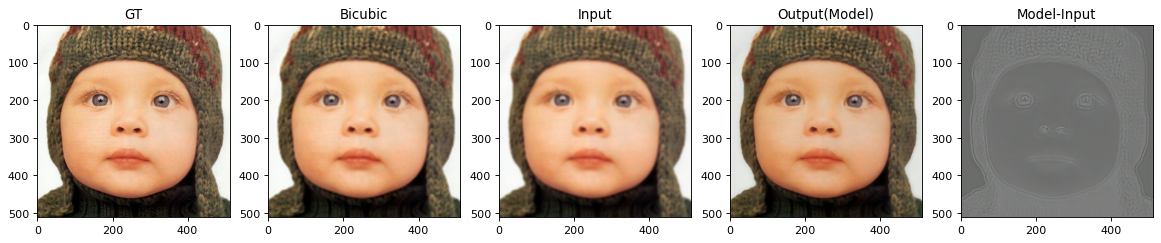

psnr for bicubic is 32.235298592507704dB
psnr for input is 31.668913764964234dB
psnr for Model is 29.179202799306974dB
PSNR improvement is -2.4897109656572596dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 24.910532272341808
Sharpness Measurement Input: 17.59731326031736
Sharpness Measurement Model: 114.23700021736077


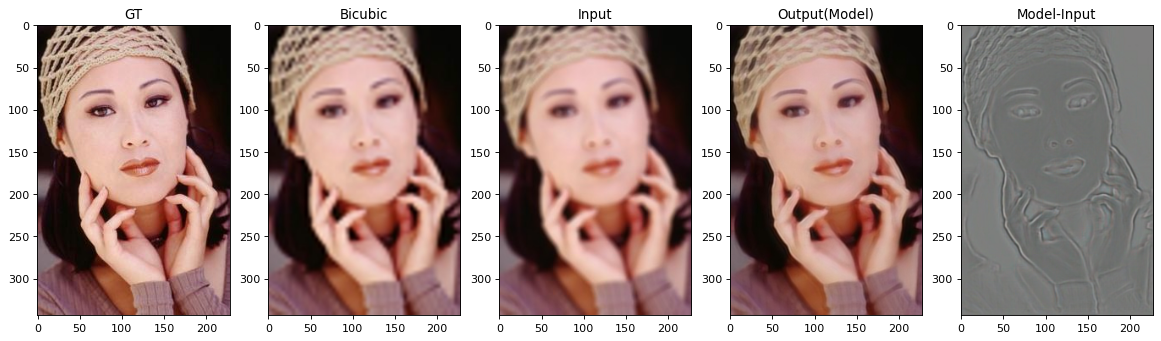

psnr for bicubic is 30.211868582917297dB
psnr for input is 29.93897837100613dB
psnr for Model is 28.61859659594554dB
PSNR improvement is -1.3203817750605893dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.43807946145535
Sharpness Measurement Input: 44.58279157336801
Sharpness Measurement Model: 415.74271081294864


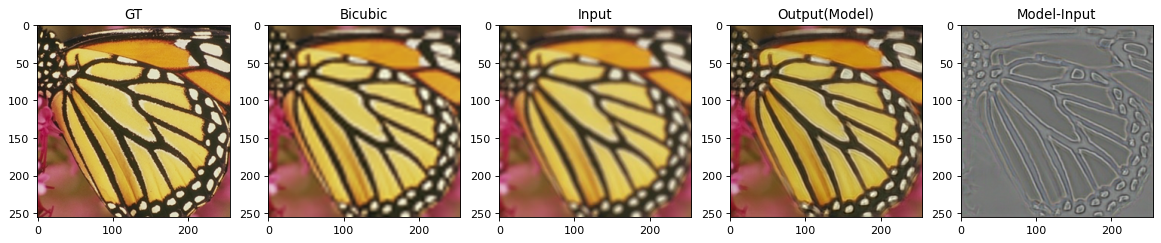

psnr for bicubic is 31.72207407894435dB
psnr for input is 31.40221787029553dB
psnr for Model is 30.32718833204694dB
PSNR improvement is -1.0750295382485895dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 5.852487158833559
Sharpness Measurement Input: 6.215204028920241
Sharpness Measurement Model: 22.18236803415244


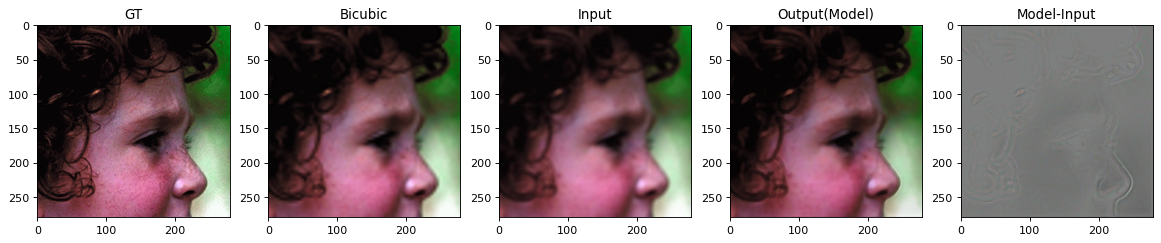

psnr for bicubic is 32.67973093611556dB
psnr for input is 31.561097762393885dB
psnr for Model is 30.49169419668616dB
PSNR improvement is -1.0694035657077237dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 15.434929803238646
Sharpness Measurement Input: 13.754676729308958
Sharpness Measurement Model: 64.02318100870394


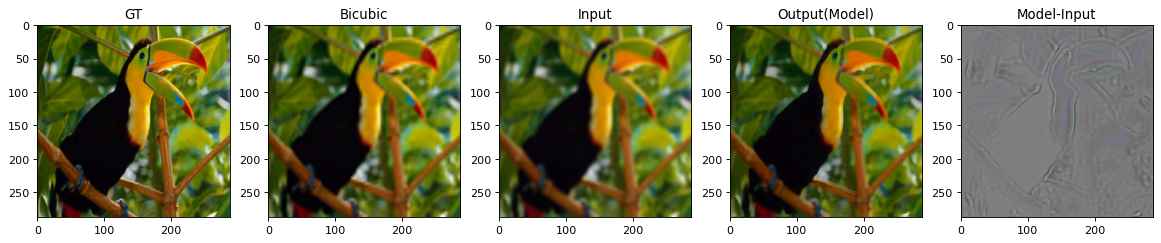

Bicubic average PSNR = 32.04782717725036
Model average PSNR = 29.441986873367775


In [58]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

# convert sample videos

In [59]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4')

In [60]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:28<00:00, 31.75it/s]


True

In [61]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 11/900 [00:00<00:08, 107.02it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 110.61it/s]


True

In [62]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:36, 24.31it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:37<00:00, 23.95it/s]


True

In [63]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 2/900 [00:00<01:13, 12.27it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:14<00:00, 12.15it/s]


True

In [64]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [65]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [66]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:28<00:00, 26.82it/s]


True

In [67]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [68]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [69]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [70]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [72]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 1/121409 [00:00<3:48:46,  8.85it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz4/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:17:39<00:00, 26.06it/s]


True

In [73]:
# Above will error out since channels is set to 3....

In [74]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [75]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su